# 📊 The Term Deposit Marketing Quest: A Data Story


## Chapter 1: Setting the Stage 🎬Before any great expedition, we must gather our tools. Let's assemble our data science toolkit...



Our journey begins in the world of banking, where understanding customer behavior can mean the difference between a successful campaign and wasted resources. We're about to embark on an analytical adventure to decode the mystery of **who subscribes to term deposits and why**.


In [51]:
## adding libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nbformat
from sklearn.compose import ColumnTransformer
import seaborn as sns
# import standard scaler and train test split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA

# Import utilities from tdm_utils module
import sys
from tdm_utils import *
sys.path.append("../../utils")

## Chapter 2: The First Glimpse 👀


Every story needs its characters, and ours are hidden within the data. Let's meet our dataset - thousands of customer interactions, each telling a small part of a larger tale.### Reading provided dataset


In [28]:
### reading provided dataset
customer_df = pd.read_csv('../../data/raw/term-deposit-marketing-2020.csv')


Like opening the first pages of a novel, let's peek at what our data looks like...

In [29]:
customer_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


### describing the dataframe 

In [30]:
customer_df.describe()  

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [31]:

customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


## Chapter 3: Understanding the Landscape 🗺️

As we explore deeper, we notice something peculiar - days are being treated as numbers when they should be categories. Time to fix that!

### week needs to be categorical

In [32]:
## week needs to be categorical
#customer_df['day'] = customer_df['day'].astype('object')
convert_day_to_week(customer_df, day_column='day', week_column='week')
customer_df['week'] = customer_df['week'].astype('category')

### Separating the heroes from the outcome


In every story, we must distinguish between our characters (features) and the outcome we seek (target). Let's separate our inputs from our goal: subscription success.

**dropping out the target variable from dataframe**


In [33]:
input_features = customer_df.drop('y', axis=1)
target_variable = customer_df['y']  # assuming 'y' is the target variable

### The great divide: Numbers vs. Categories


Our data speaks different languages - some features whisper in numbers, others speak in categories. Let's sort them out.


In [34]:
# Identify numerical and categorical features
#numerical_features = input_features.select_dtypes(include=[np.number]).columns.tolist()
#categorical_features = input_features.select_dtypes(include=['object']).columns.tolist()

#identify_feature_types(input_features)
categorical_features, numerical_features = identify_feature_types(input_features)
print("Categorical Features:", categorical_features)
print("\nNumerical Features:", numerical_features)


Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

Numerical Features: ['age', 'balance', 'day', 'duration', 'campaign']


### The mystery of the unknown 🔍


Some customers hide behind the veil of 'unknown' values. Let's uncover where these mysteries lurk...


In [35]:
# features having unknown values
categorical_features_with_unknown = find_unknown_values(input_features, categorical_features)

Column 'job' has 235 'unknown' values.
Column 'education' has 1531 'unknown' values.
Column 'contact' has 12765 'unknown' values.


### Translating success into numbers


Machines speak binary. Let's translate 'yes' and 'no' into the language of 1s and 0s.


In [36]:
## setting y to binary
target_variable = target_variable.map({'yes': 1, 'no': 0})


In [37]:
target_variable.unique()

array([0, 1])

## Chapter 4: Painting the Picture 🎨


Numbers alone don't tell stories - visualizations do! Let's bring our data to life with interactive charts that reveal hidden patterns.### Checking distribution of y and other features against y - plotting using plotly


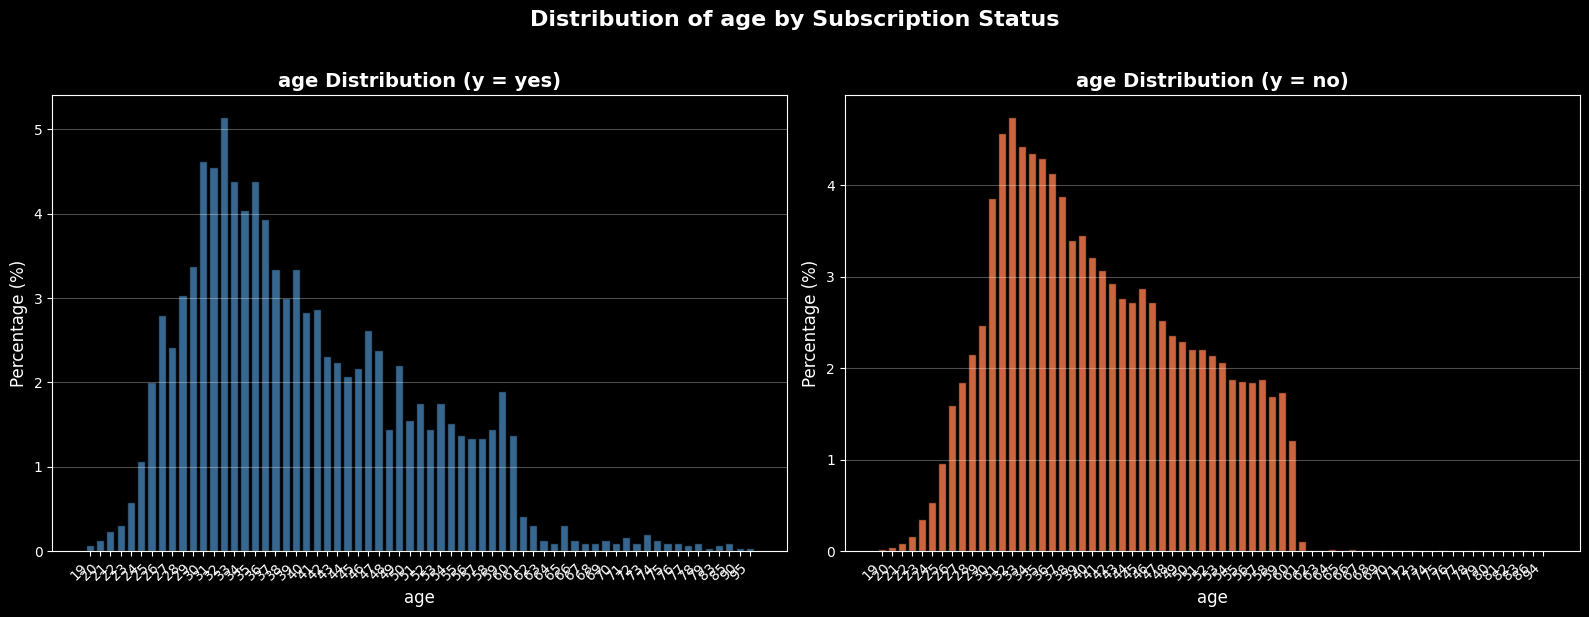

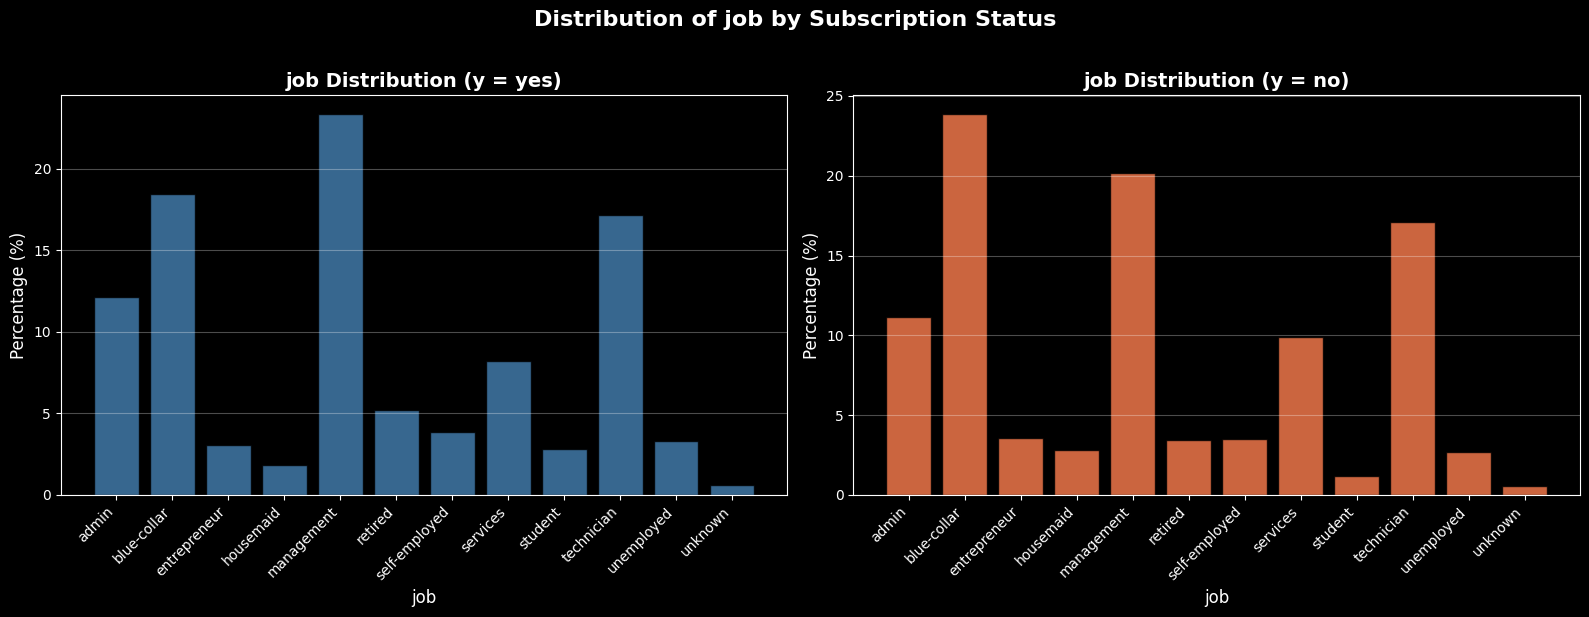

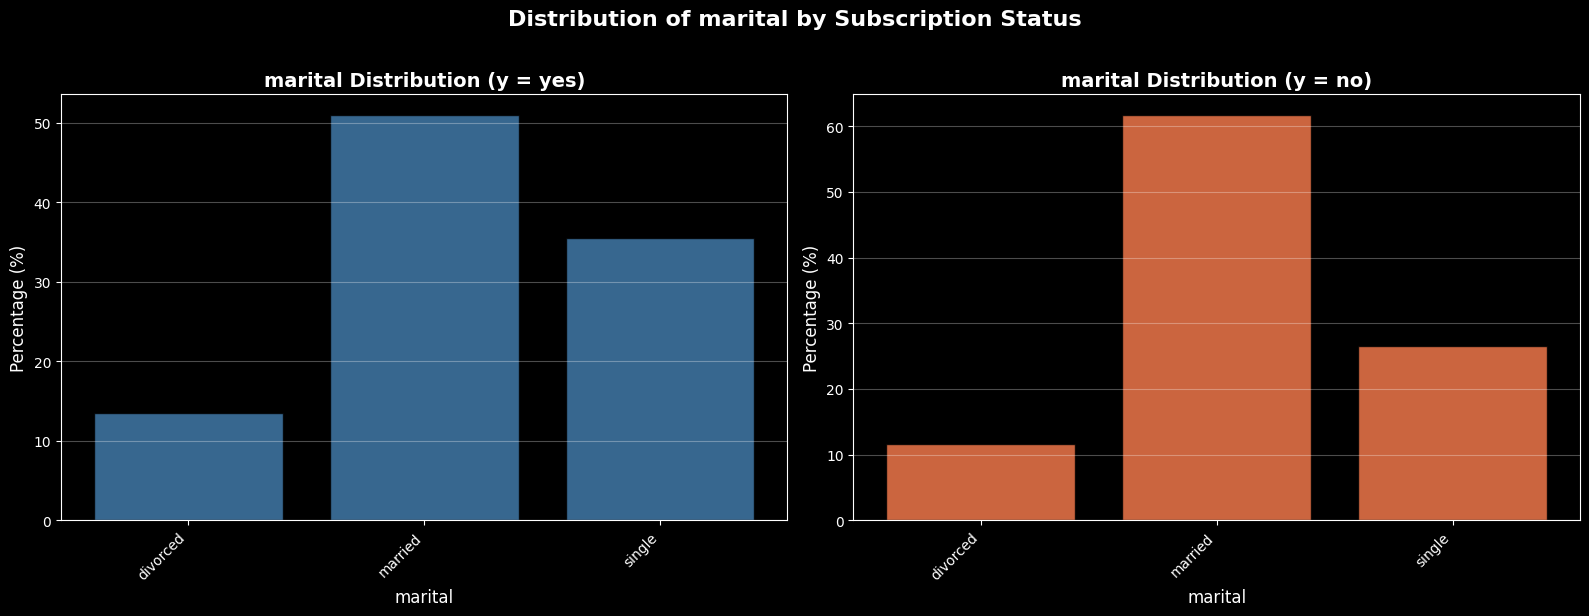

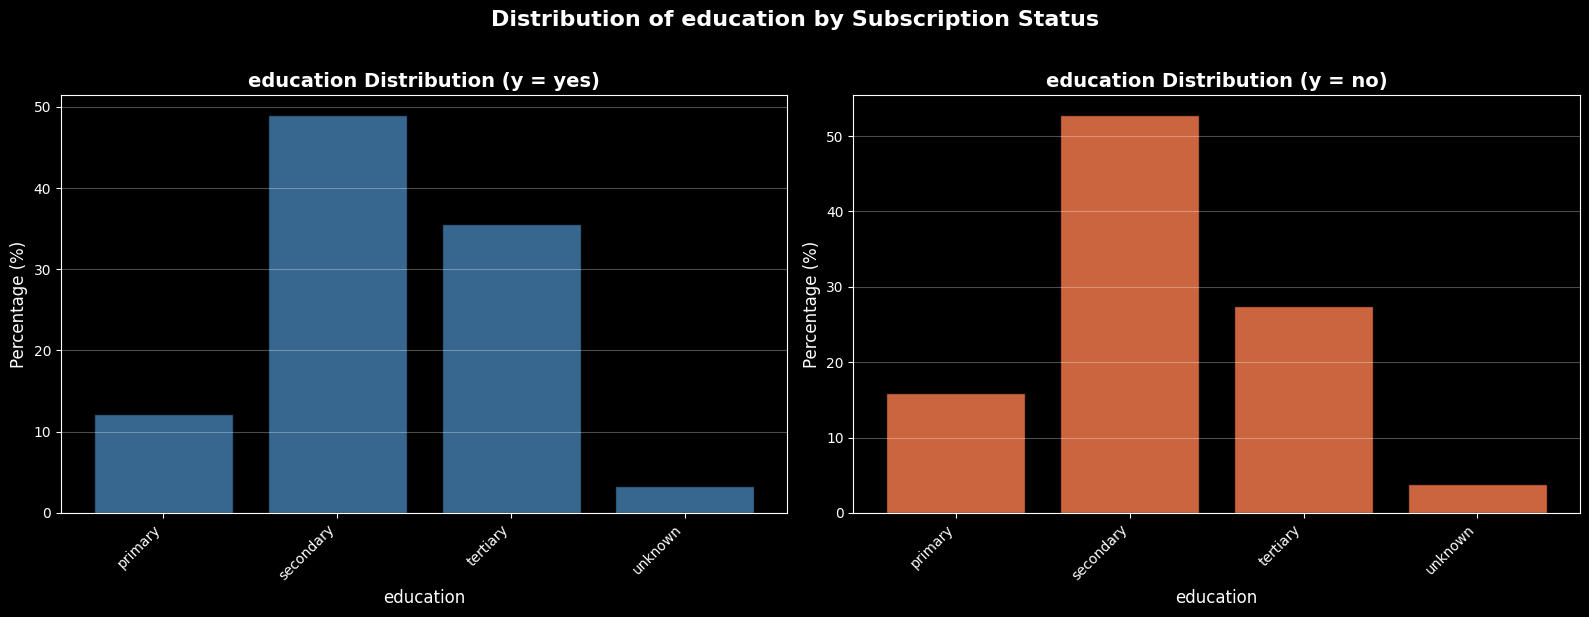

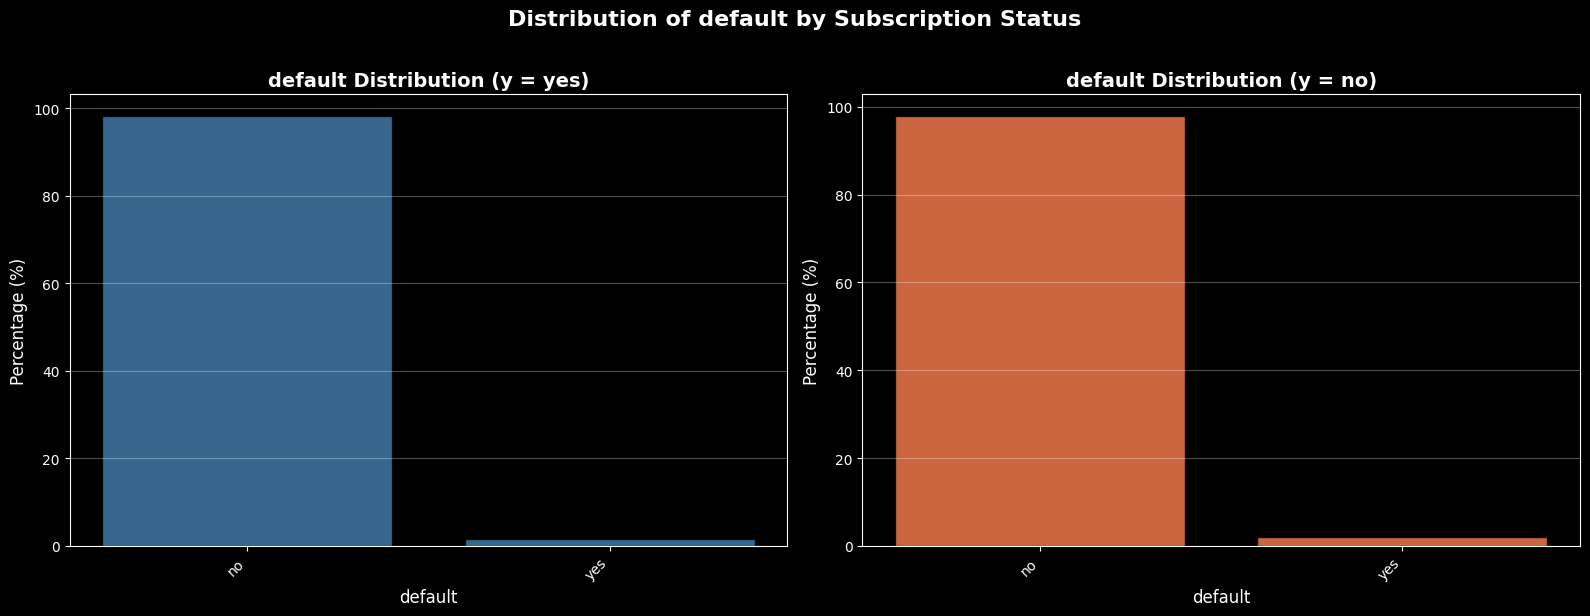

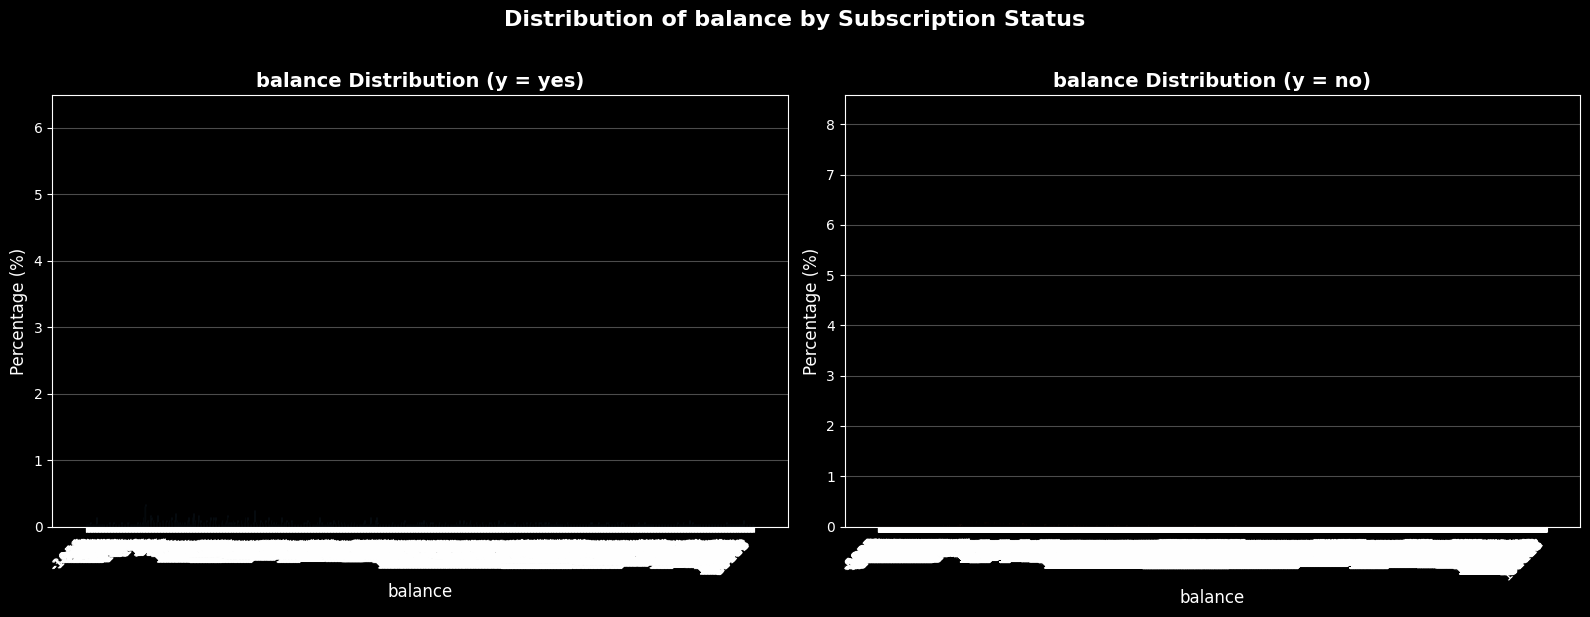

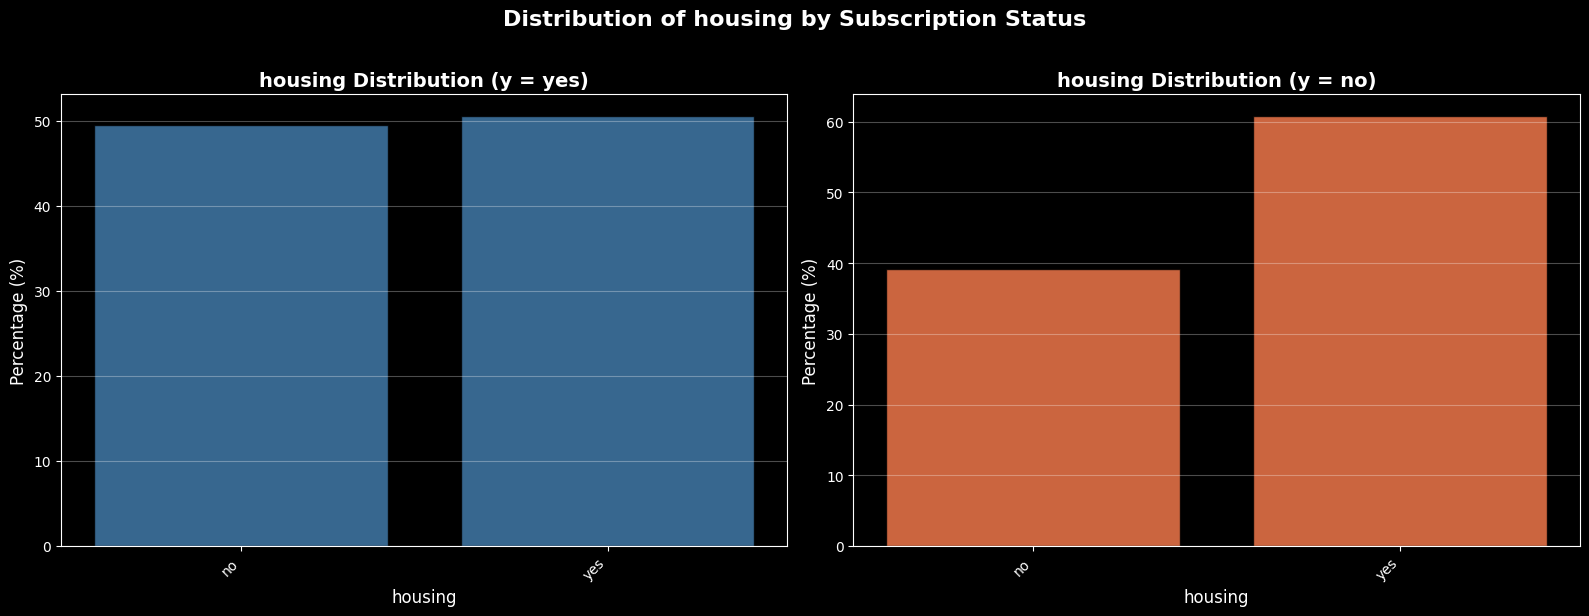

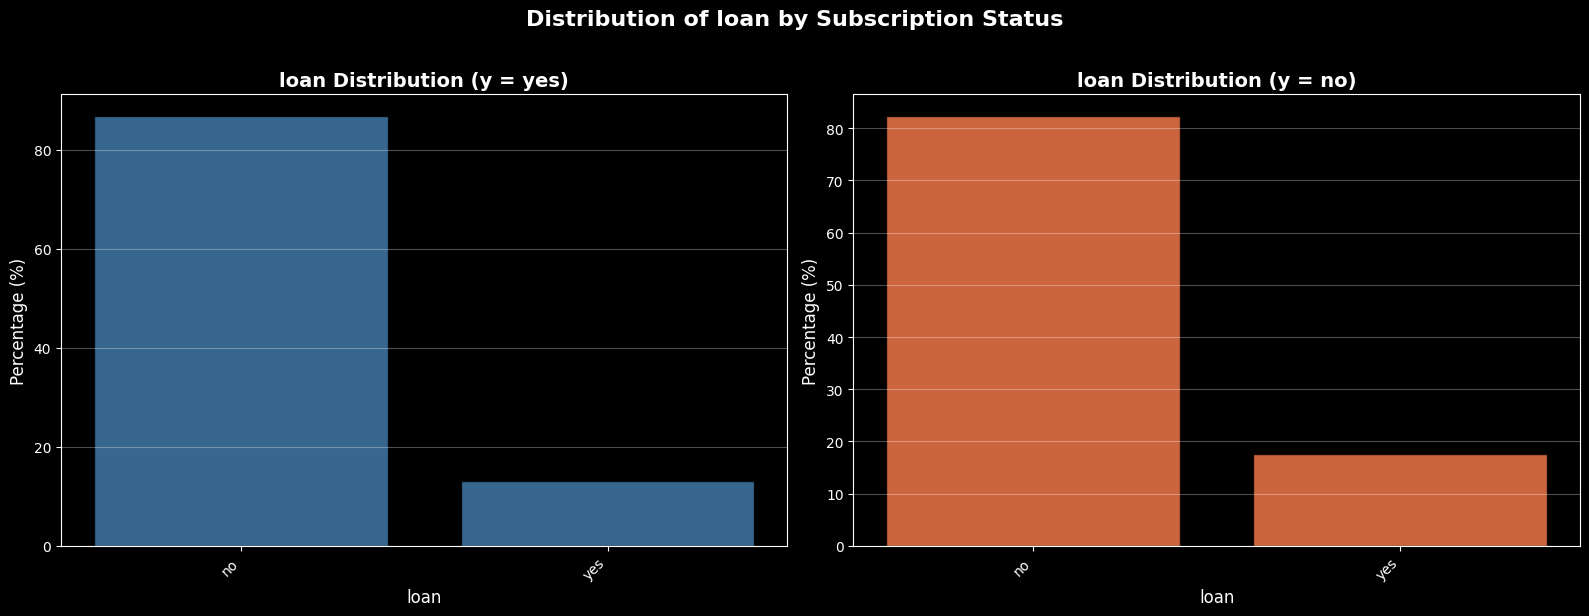

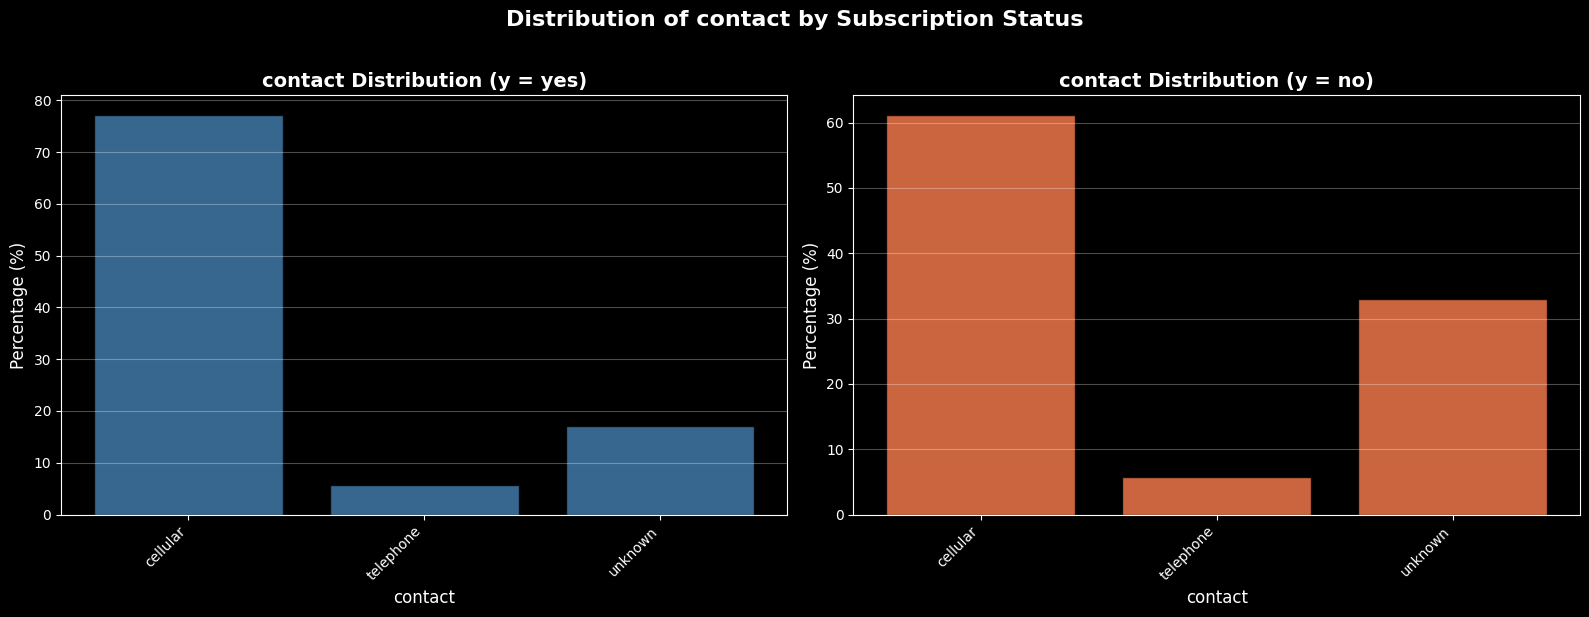

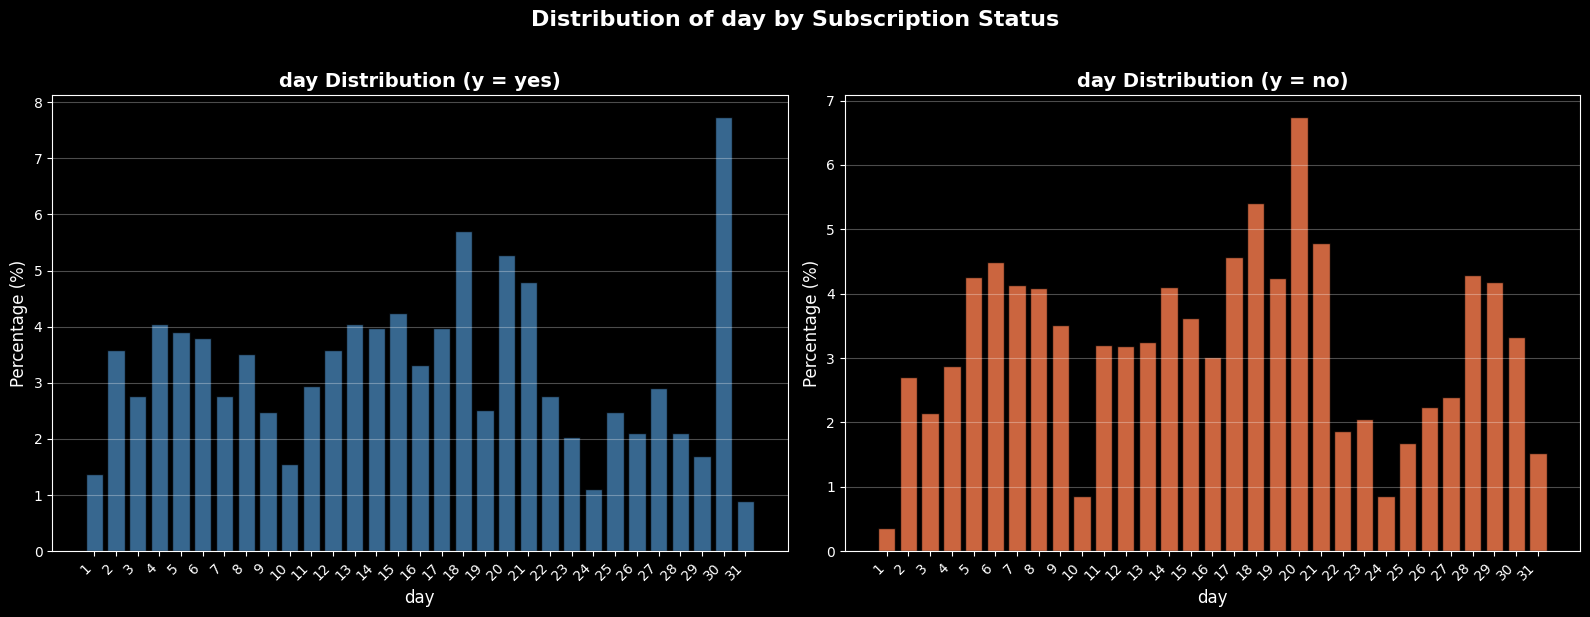

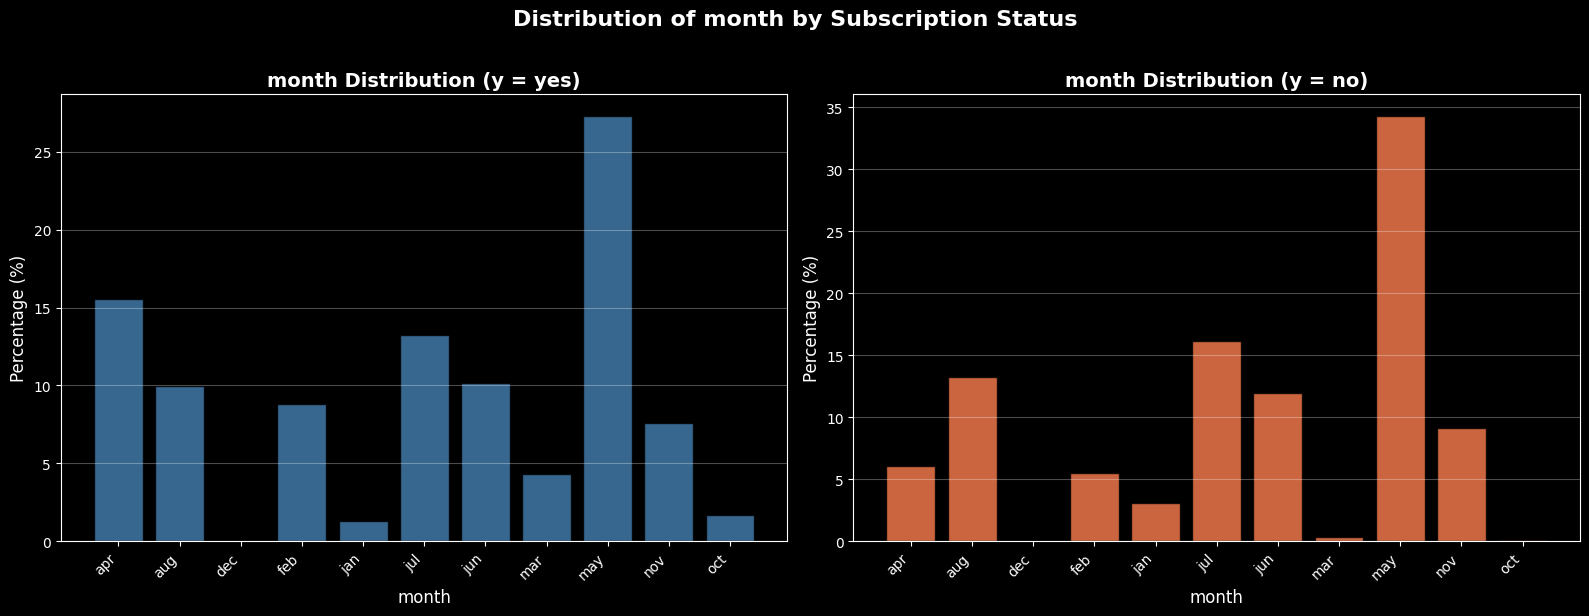

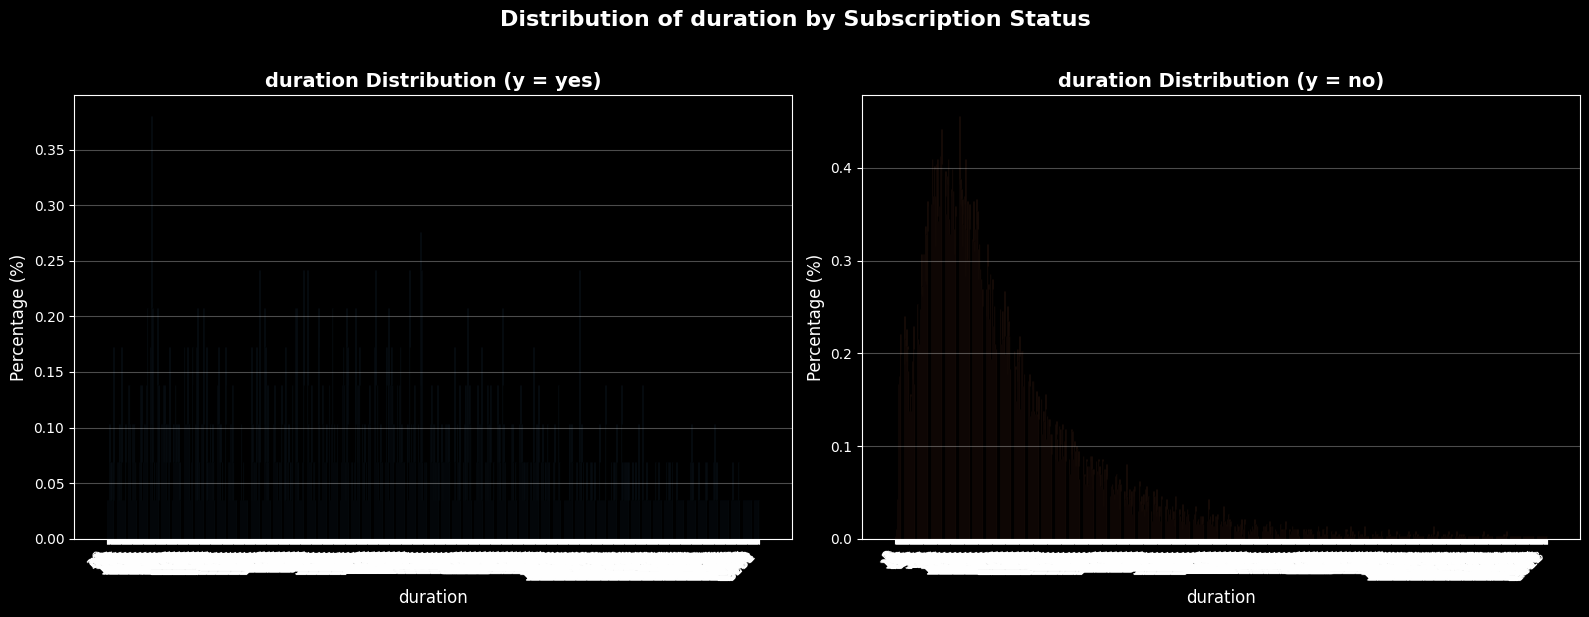

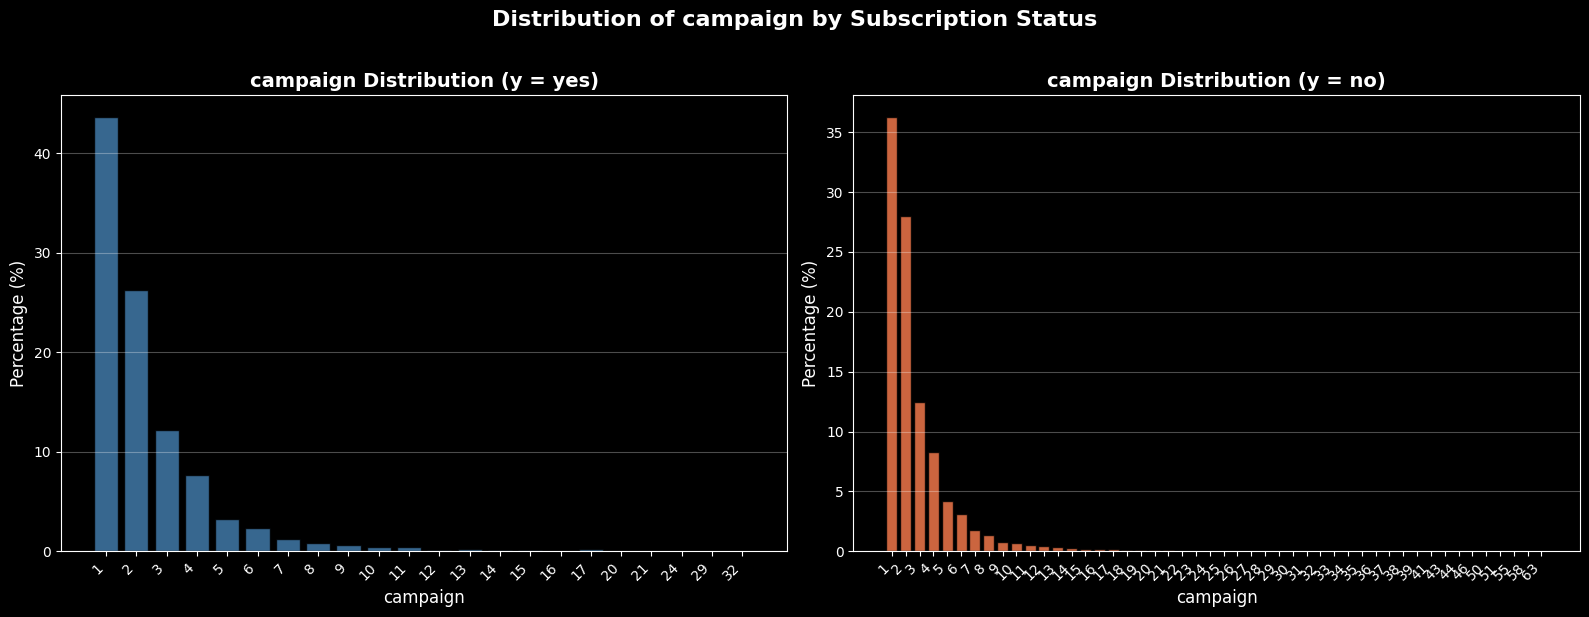

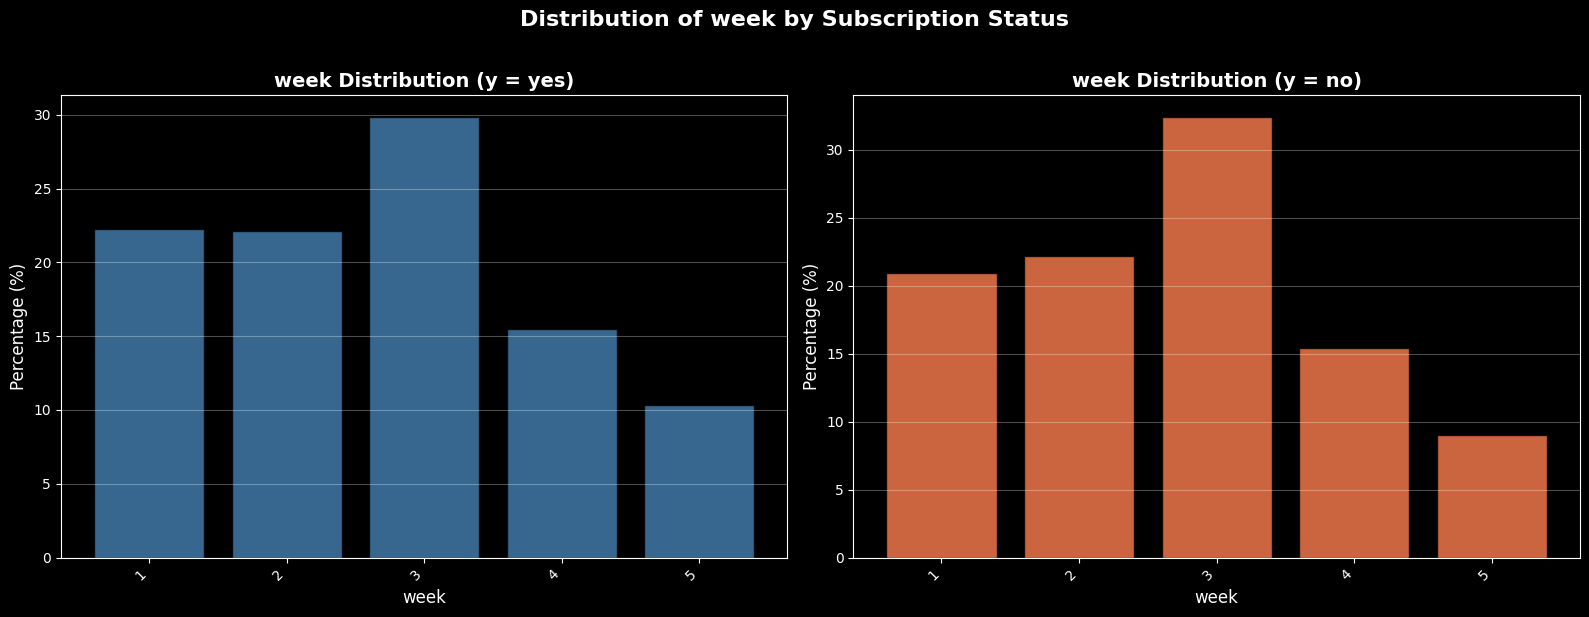

In [38]:
### checking distribution of features against y - using utility function
plot_feature_distribution_by_target(customer_df, input_features.columns.tolist(), 
                                   target_column='y', save_figures=True)

## 💡 Plot Twist: The Profile of Success Emerges!

The visualizations whisper secrets about our successful subscribers...

### Customers likely to have subscription:
- **Age sweet spot:** People in the age group between 30-40 hold the golden key
- **Timing is everything:** May emerges as the month of champions
- **Life stage matters:** Married individuals show stronger commitment
- **Education counts:** Secondary education holders lead the pack
- **Campaign efficiency:** Campaign type 1 works like magic
- **The power of conversation:** Call duration plays a starring role in conversions
- **Communication channel:** Cellular contact creates stronger connections

### feature exploration: Every feature tells a story

Let's dive deeper into each feature's individual narrative with  visualizations...

### Use matplotlib to create interactive visualizations

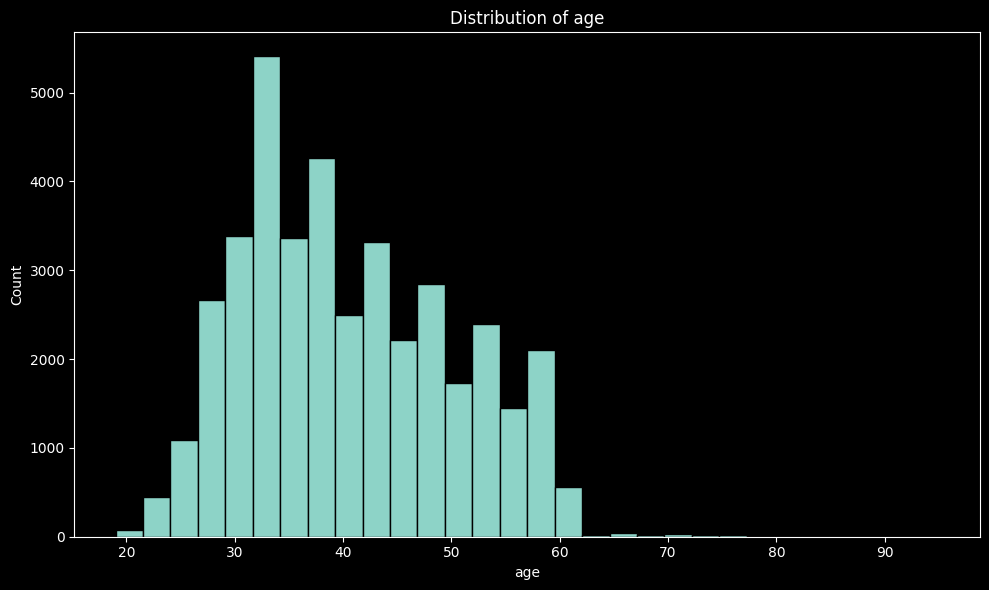

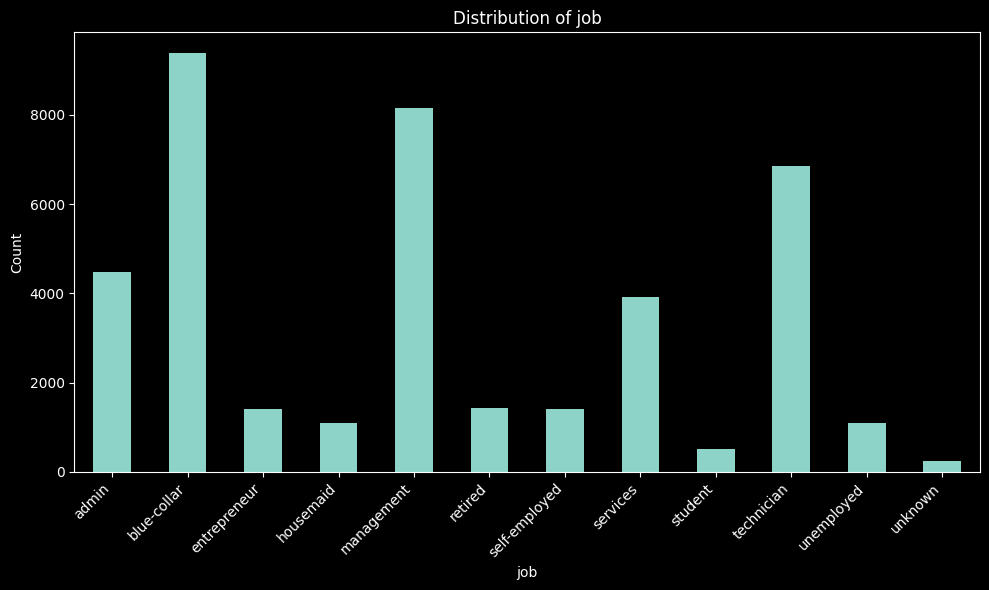

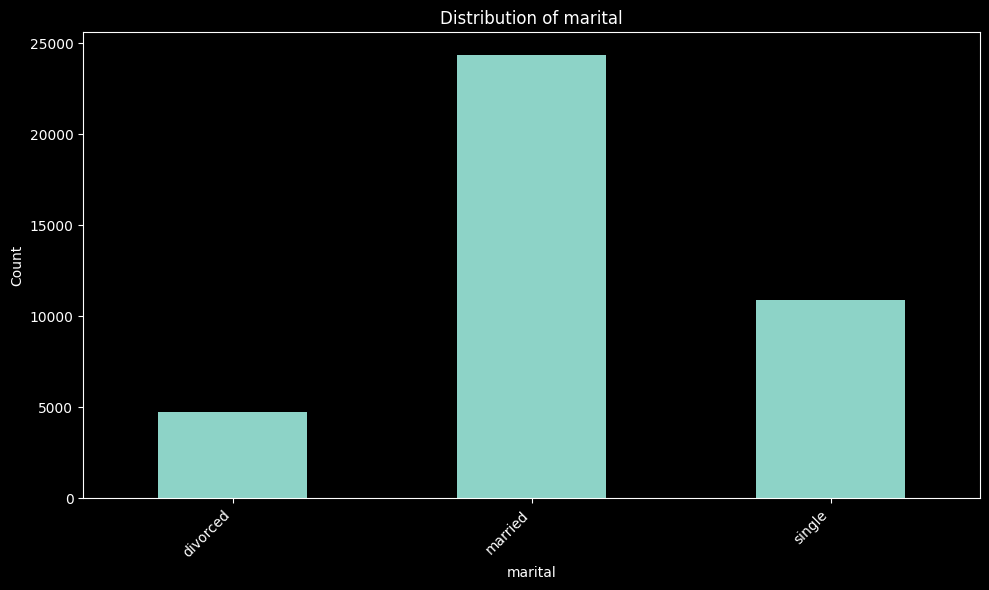

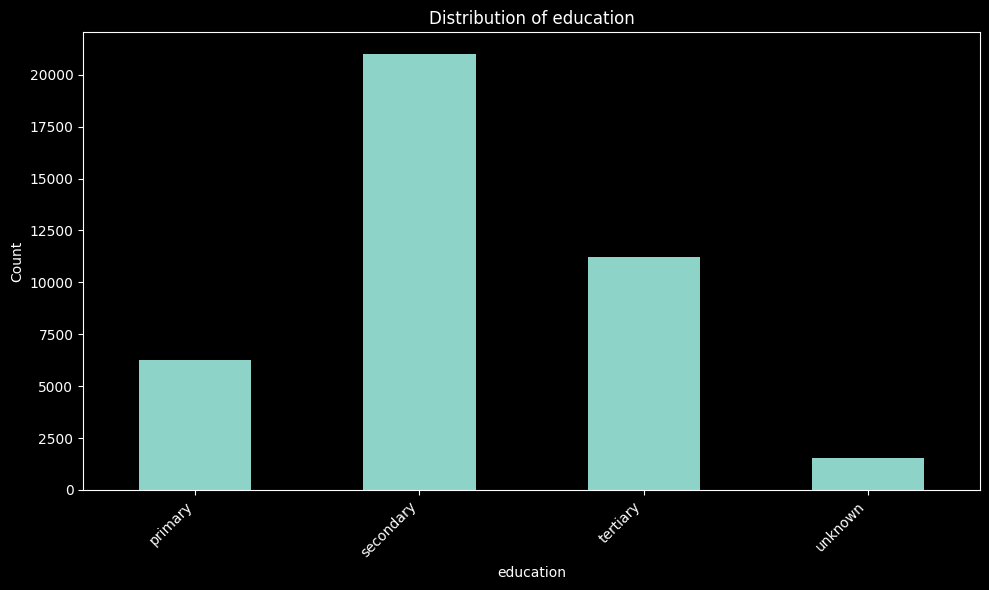

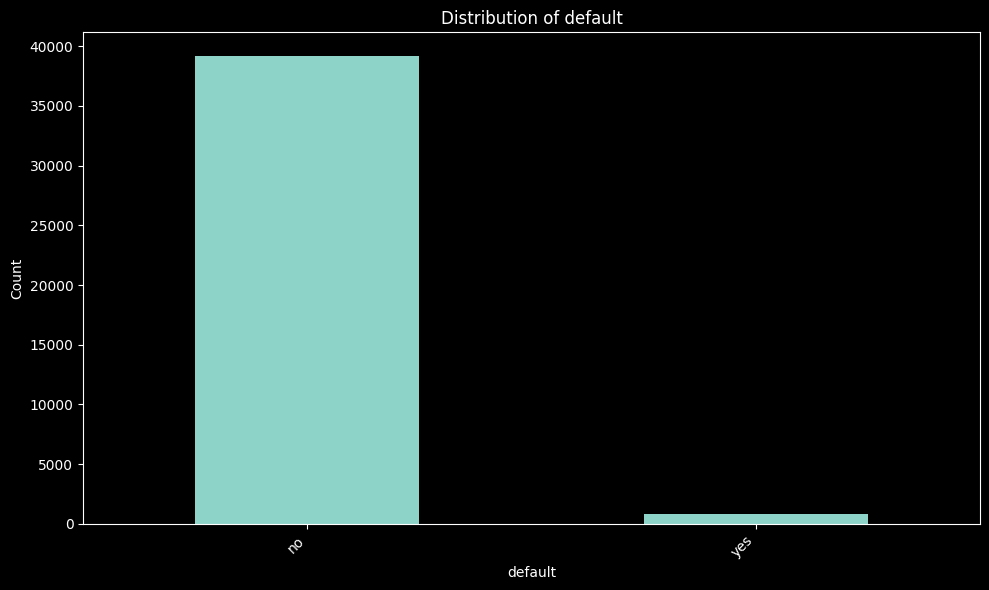

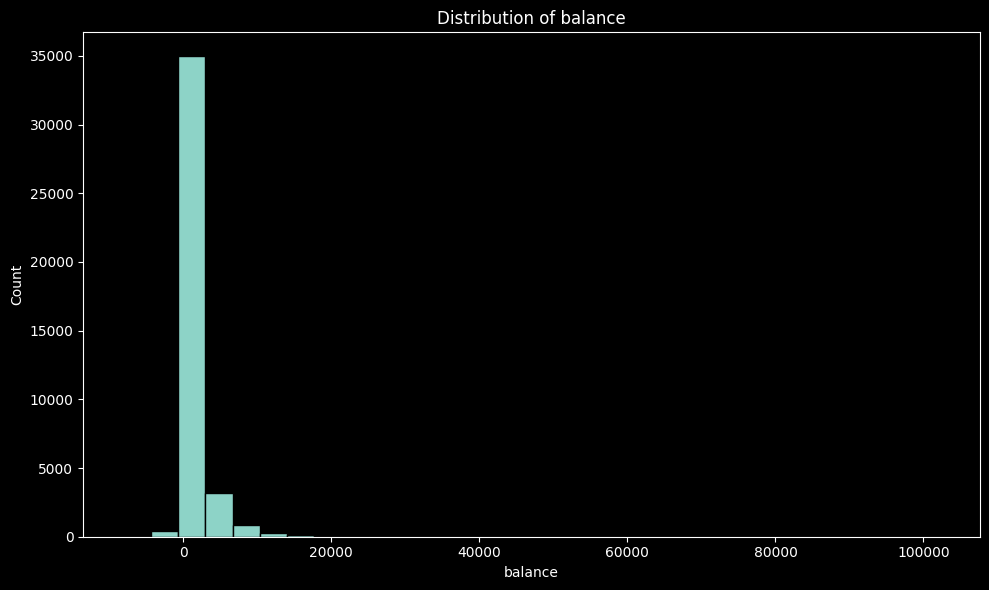

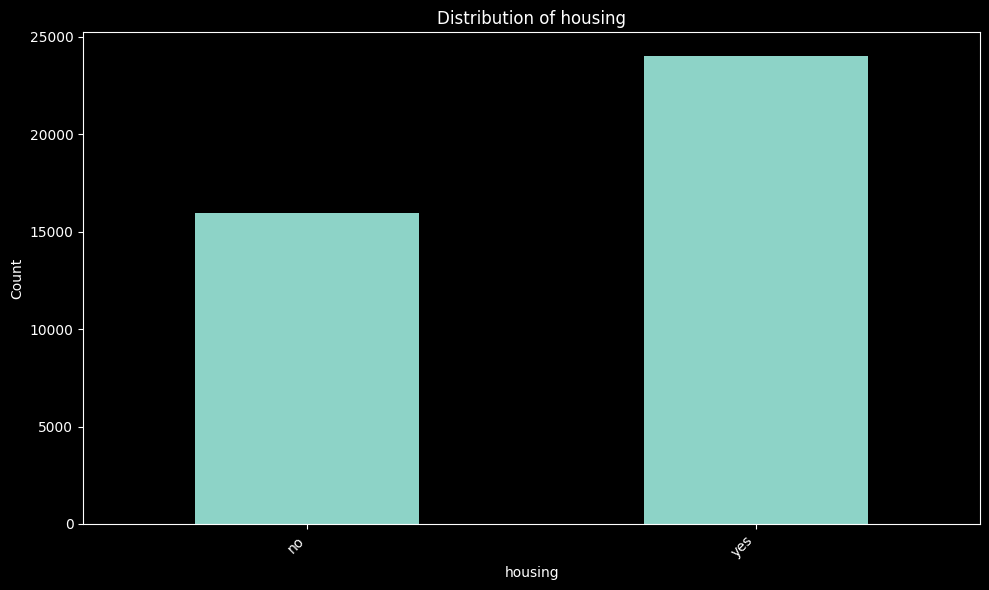

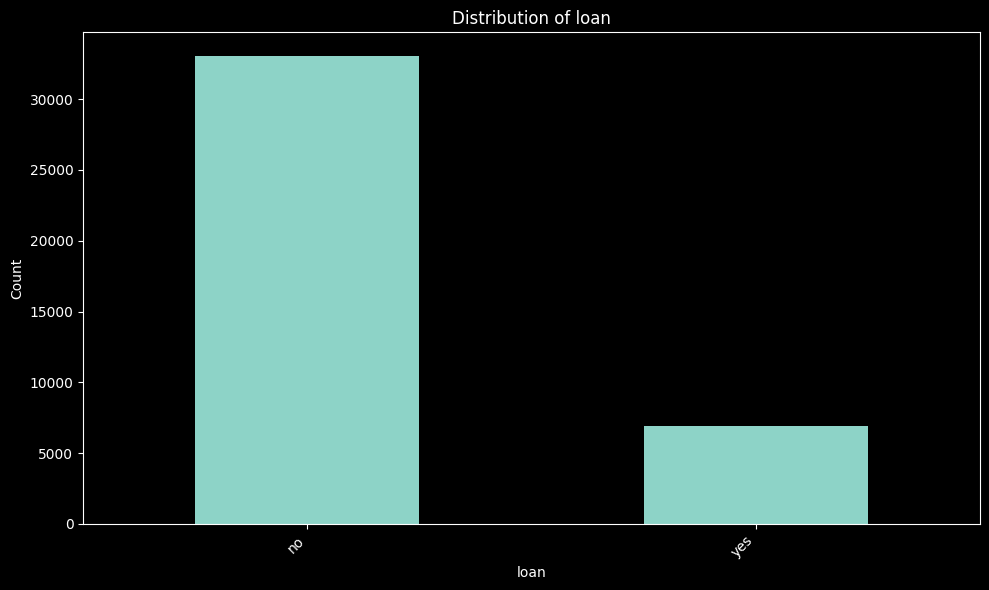

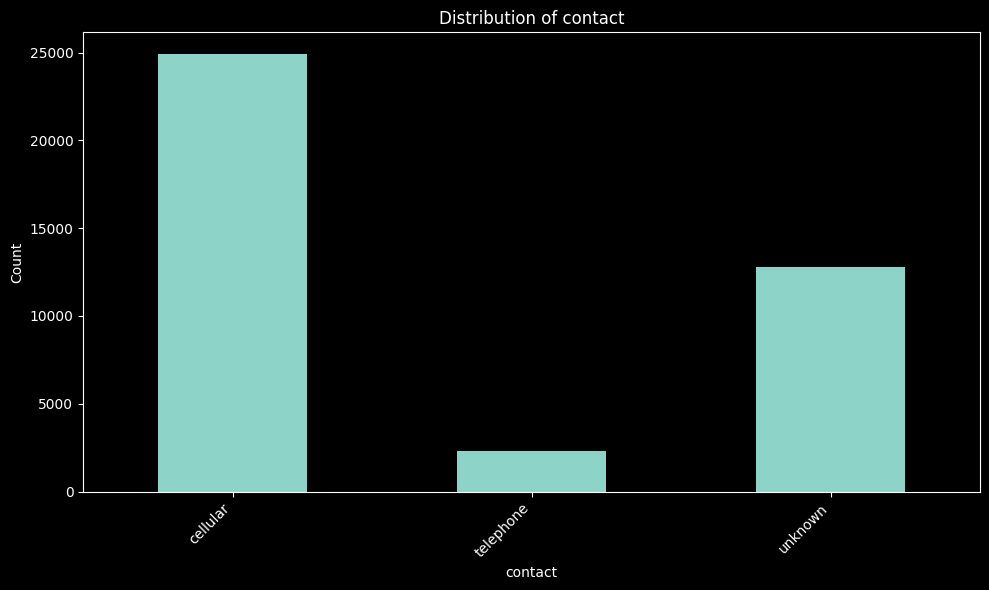

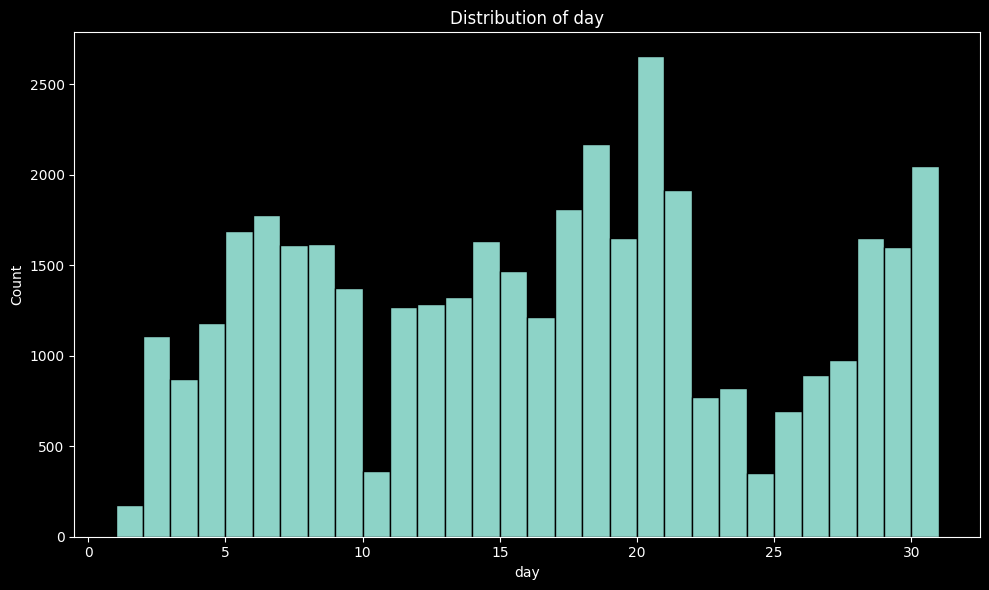

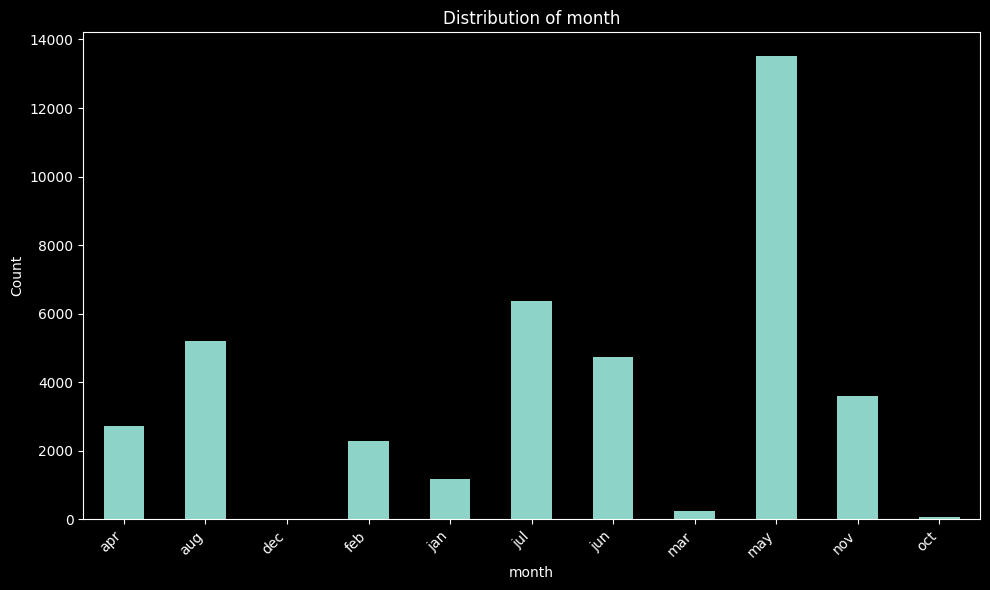

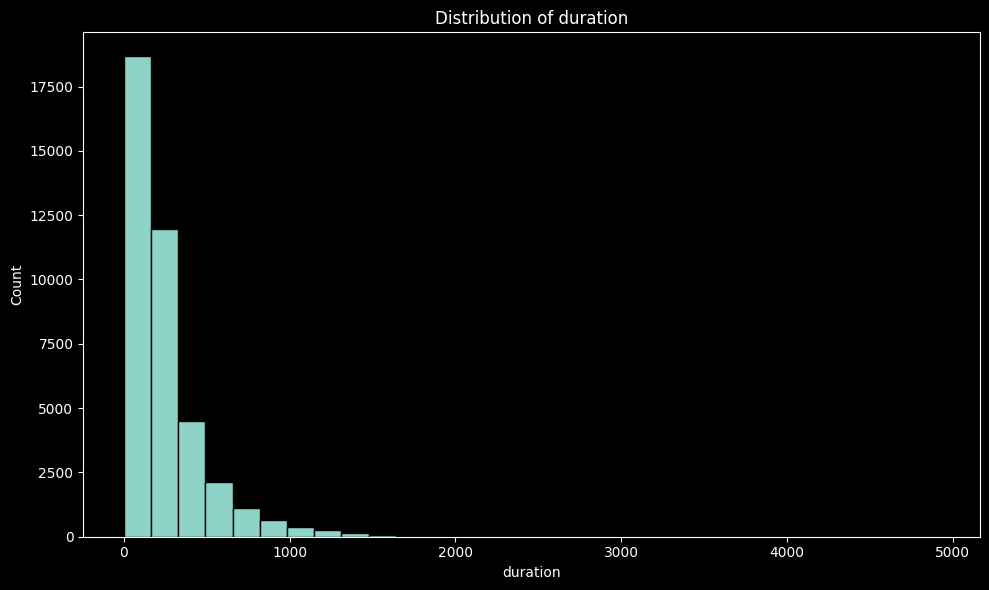

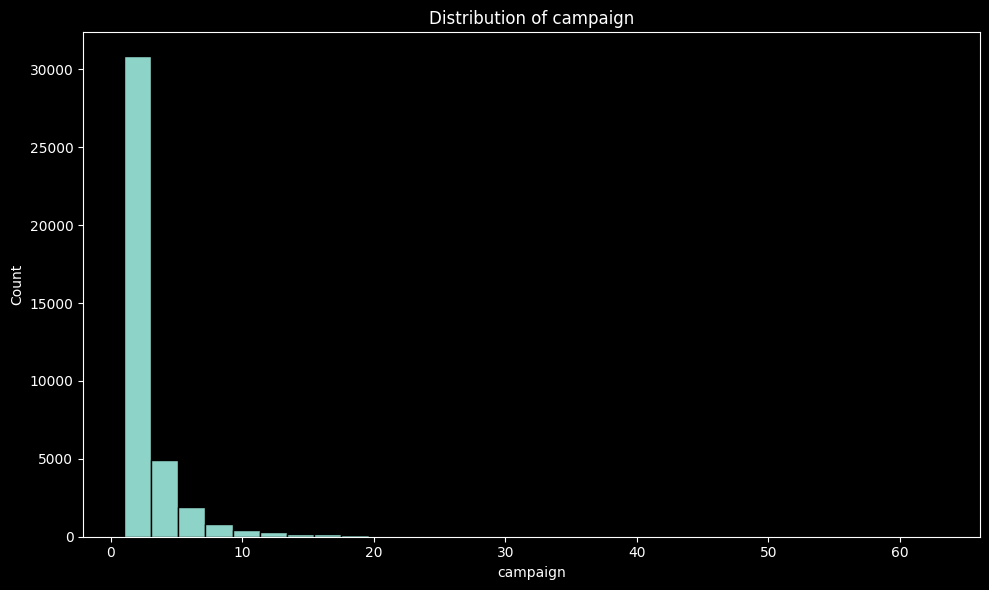

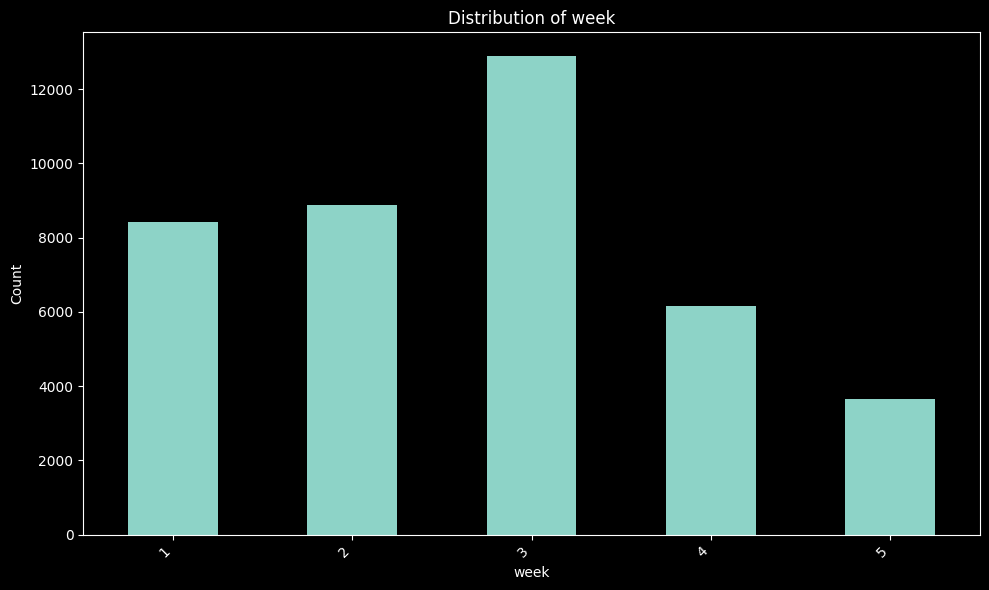

In [39]:
# use plotly to create interactive visualizations

plot_individual_features(customer_df, input_features)

## Chapter 5: The Imbalance Revelation ⚖️

A critical discovery: our dataset isn't balanced! This is the classic tale of imbalanced classes...

### Percentage distribution

In [40]:
# percentage distribution

calculate_class_distribution(target_variable)

Total samples: 40000
Class 0: 37104 (92.76%)
Class 1: 2896 (7.24%)


{0: {'count': 37104, 'percentage': 92.75999999999999},
 1: {'count': 2896, 'percentage': 7.24}}

### Leveling the playing field


To fight imbalance, we wield the weapon of class weights - giving minority class a voice!


In [41]:
## calculating class weights to handle class imbalance

compute_class_weights_balanced(target_variable)

Class weights: {0: np.float64(0.5390254420008624), 1: np.float64(6.906077348066298)}


{0: np.float64(0.5390254420008624), 1: np.float64(6.906077348066298)}

## 📉 The Imbalance Challenge


Our graph reveals an uncomfortable truth: the dataset is heavily imbalanced, with far more customers declining than subscribing to term deposits.- **Class weighting** to amplify the importance of rare positive cases

- **Undersampling** the majority class (non-subscribers)

This imbalance isn't just a statistical quirk - it's a real-world phenomenon that demands careful handling. We'll need to address this during model training using techniques like:- **Oversampling** the minority class (subscribers)

In [42]:
customer_df[categorical_features].describe()

,job,marital,education,default,housing,loan,contact,month
count,40000,40000,40000,40000,40000,40000,40000,40000
unique,12,3,4,2,2,2,3,11
top,blue-collar,married,secondary,no,yes,no,cellular,may
freq,9383,24386,20993,39191,24031,33070,24914,13532


In [43]:
customer_df[categorical_features].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        11
dtype: int64

### Seasonal patterns: When do campaigns succeed?


Time has its own rhythm in marketing. Let's decode the monthly patterns...

In [44]:
monthname = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
for month in monthname:
    print(f"{month}: {input_features[input_features['month'] == month]['month'].value_counts().get(month, 0)}")

jan: 1176
feb: 2296
mar: 258
apr: 2718
may: 13532
jun: 4734
jul: 6380
aug: 5215
sep: 0
oct: 80
nov: 3598
dec: 13


### The curious case of missing September 🍂


September remains silent in our dataset - a ghost month with no entries!


In [82]:
## there are no entries for september
input_features['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr'], dtype=object)

## Chapter 6: The Art of Feature Engineering 🔧

#### **Feature engineering**

Raw data is like uncut diamonds. Now comes the craftsmanship - transforming and creating features that truly shine!

In [46]:

# converting day to week

#convert_day_to_week(input_features, day_column='day', week_column='week')
input_features['week'].value_counts()
input_features['week'] = input_features['week'].astype('category')

### converting month to quarter


In [84]:
# converting month to quarter
#from tdm_utils import convert_month_to_quarter
convert_month_to_quarter(input_features, month_column='month', quarter_column='quarter')
input_features['quarter'].value_counts(dropna=False)
input_features['quarter'] = input_features['quarter'].astype('category')
input_features['quarter'].value_counts()



quarter
2    20984
3    11595
1     3730
4     3691
Name: count, dtype: int64

### add week and quarter to categorical features


In [55]:
### add week and quarter to categorical features
categorical_features.append('week')
categorical_features.append('quarter')

### Financial fingerprints: Creating wealth & debt indicators 💰

Let's craft features that capture financial health - high balances and loan burdens paint distinct customer portraits...

### Creating new features is_high_balance and loan_count

In [85]:
# creating new features is_high_balance and loan_count
is_high_balance = customer_df['balance'] > customer_df['balance'].median()
print(is_high_balance)
loan_count = customer_df['housing'].map({'yes':1, 'no':0}) + customer_df['loan'].map({'yes':1, 'no':0})
print(loan_count)

0         True
1        False
2        False
3         True
4        False
         ...  
39995    False
39996     True
39997    False
39998     True
39999     True
Name: balance, Length: 40000, dtype: bool
0        1
1        1
2        2
3        1
4        0
        ..
39995    0
39996    0
39997    0
39998    0
39999    1
Length: 40000, dtype: int64


### adding loan_count and is_high_balance to input features


In [57]:
## adding loan_count and is_high_balance to input features
input_features['is_high_balance'] = is_high_balance.astype(int)
input_features['loan_count'] = loan_count

### Campaign behavior signatures 📞

How customers respond to campaigns tells us volumes. Let's engineer features that capture engagement patterns...

### Adding campaign features

In [58]:
## adding campaign features
input_features['campaign_intensity'] = input_features['duration'] / (input_features['campaign'] + 1)
contacted_multiple_times = input_features['campaign'] > 1
input_features['contacted_multiple_times'] = contacted_multiple_times.astype(int)
is_last_call_long = input_features['duration'] > input_features['duration'].median()
input_features['is_last_call_long'] = is_last_call_long.astype(int)


### Life stage categorization: The age story 👶➡️👴

Age isn't just a number - it's a life stage. Let's group customers by their journey through life...

### Adding age binning

In [59]:
## adding age binning
age_bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['<18', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
input_features['age_group'] = pd.cut(input_features['age'], bins=age_bins, labels=age_labels, right=False)


In [60]:
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
input_features['month_num'] = input_features['month'].map(month_map)
input_features['is_quarter_end'] = input_features['month_num'].isin([3,6,9,12]).astype(int)



In [61]:
## has any loan
has_loan = ((input_features['housing'] == 'yes') | (input_features['loan'] == 'yes')).astype(int)

## education & job
education_job = input_features['education'] + "_" + input_features['job']

In [62]:
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
input_features['month_num'] = input_features['month'].map(month_map)
input_features['is_quarter_end'] = input_features['month_num'].isin([3,6,9,12]).astype(int)


In [63]:
## adding new features to input_features
#input_features['age_group'] = age_group
input_features['has_loan'] = has_loan
input_features['education_job'] = education_job
input_features['month_num'] = input_features['month_num']
input_features['is_quarter_end'] = input_features['is_quarter_end']
input_features.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'week',
       'quarter', 'is_high_balance', 'loan_count', 'campaign_intensity',
       'contacted_multiple_times', 'is_last_call_long', 'age_group',
       'month_num', 'is_quarter_end', 'has_loan', 'education_job'],
      dtype='object')

### merge input features and target variable for plotting


In [64]:
# merge input features and target variable for plotting
customer_df_updated = pd.concat([input_features, target_variable], axis=1)

In [65]:
customer_df_updated.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'week',
       'quarter', 'is_high_balance', 'loan_count', 'campaign_intensity',
       'contacted_multiple_times', 'is_last_call_long', 'age_group',
       'month_num', 'is_quarter_end', 'has_loan', 'education_job', 'y'],
      dtype='object')

### Visualizing our newly crafted features ✨

Time to see if our feature engineering pays off! Do these new features reveal clearer patterns?



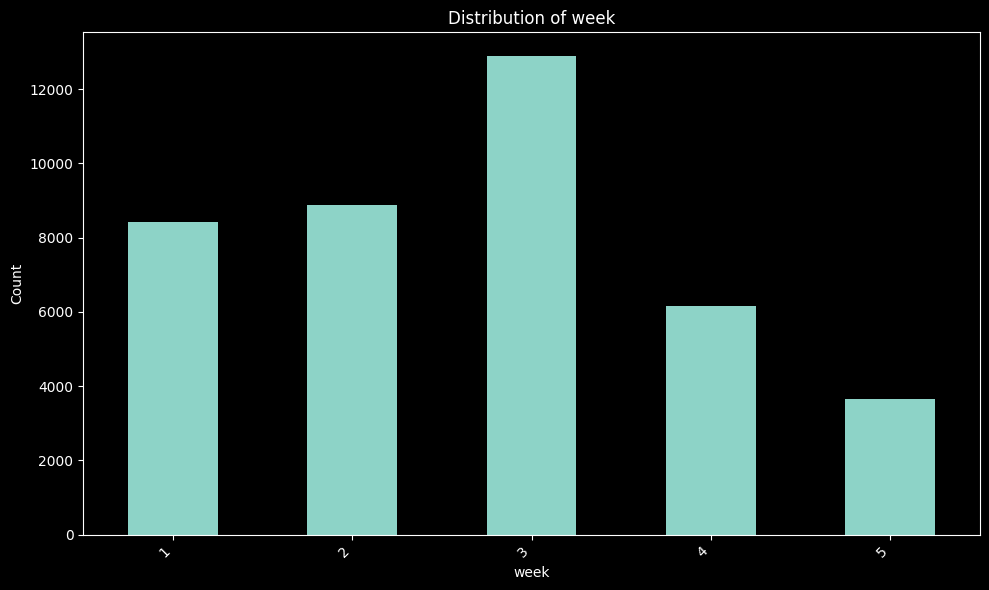

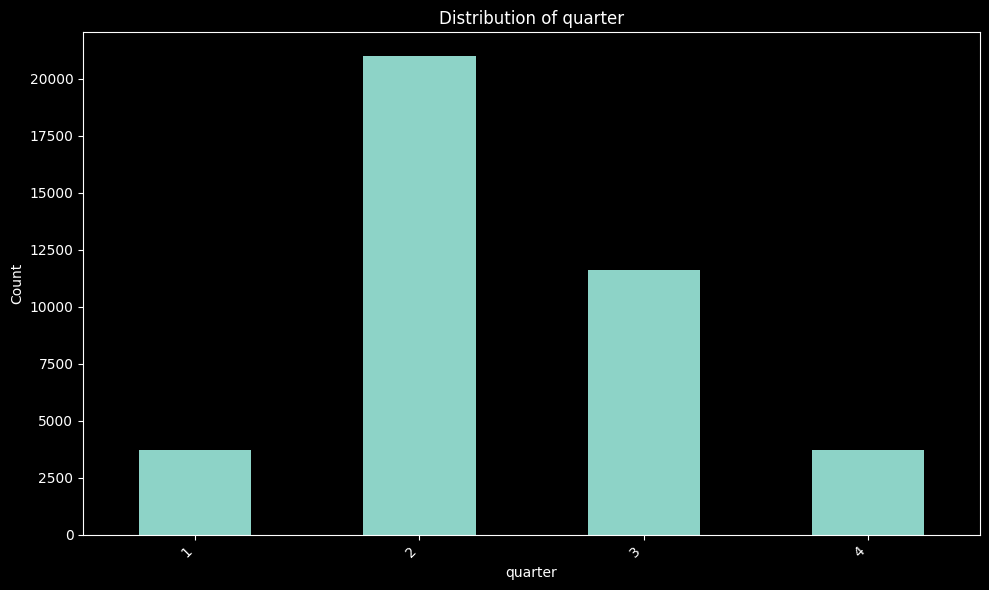

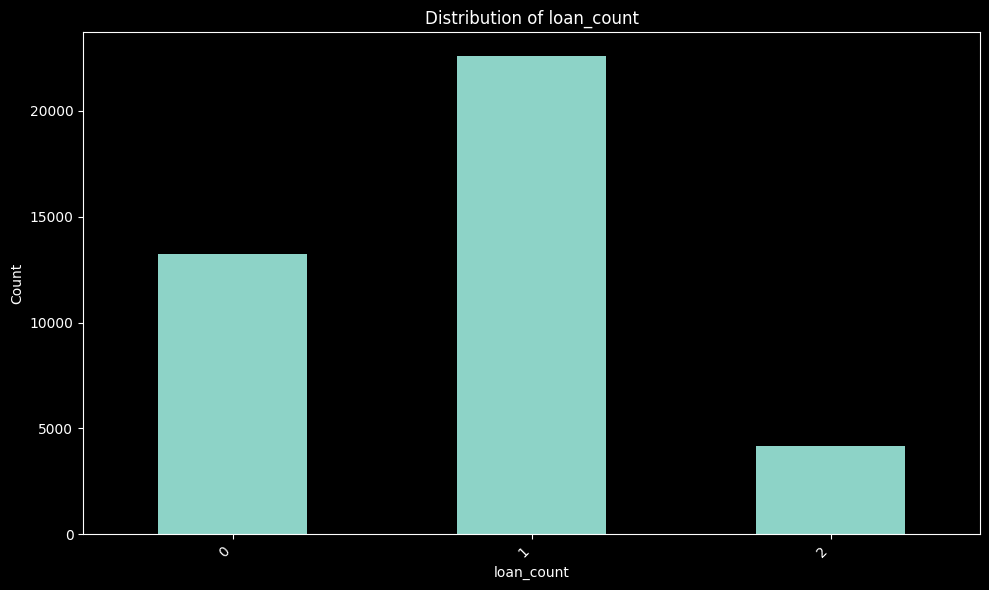

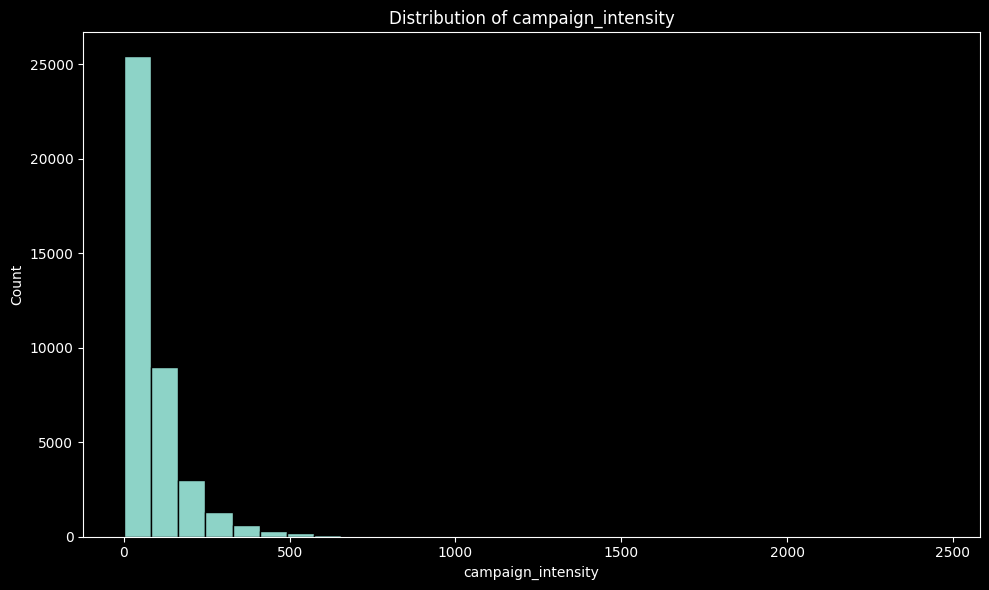

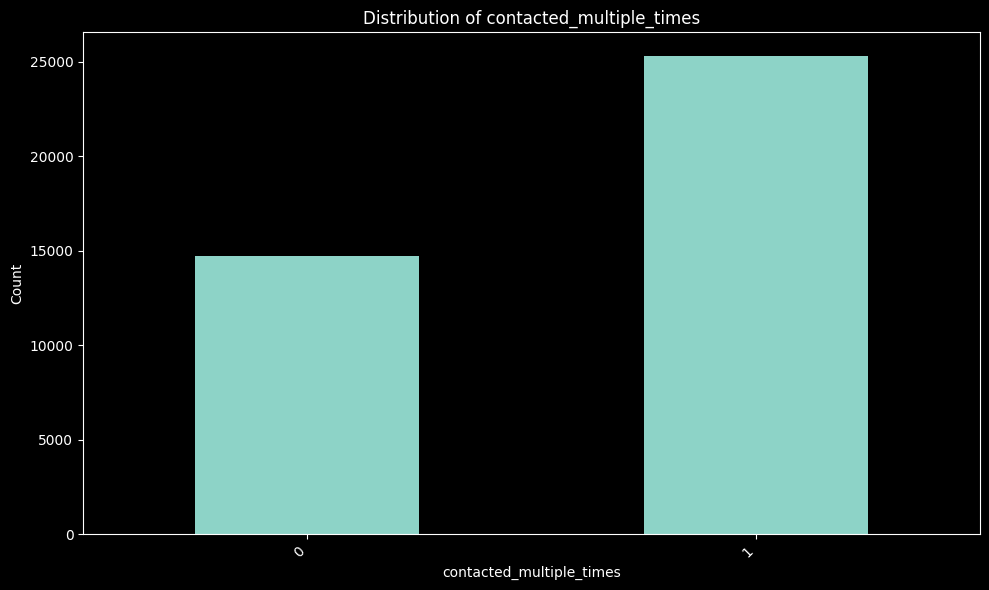

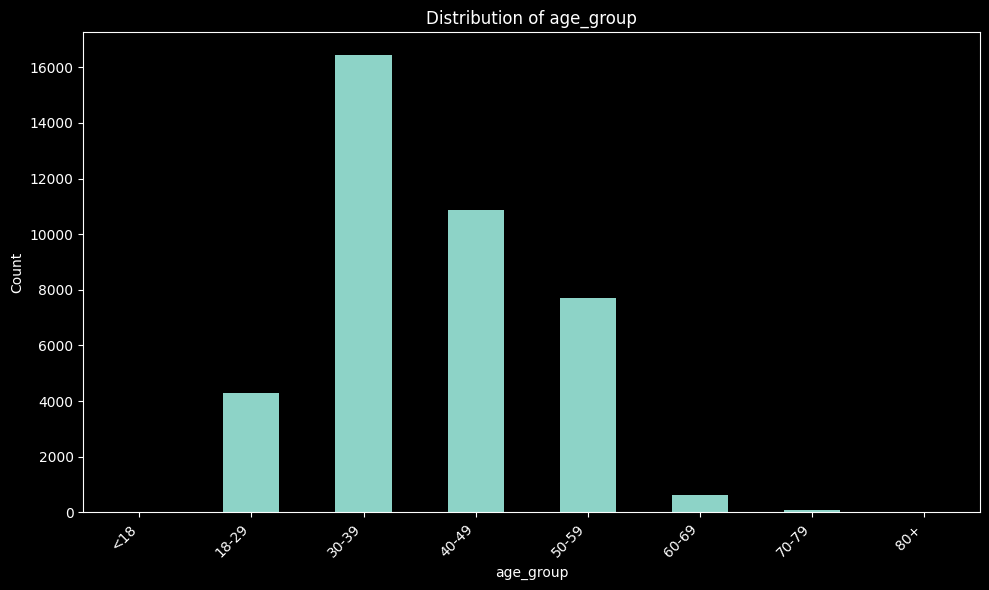

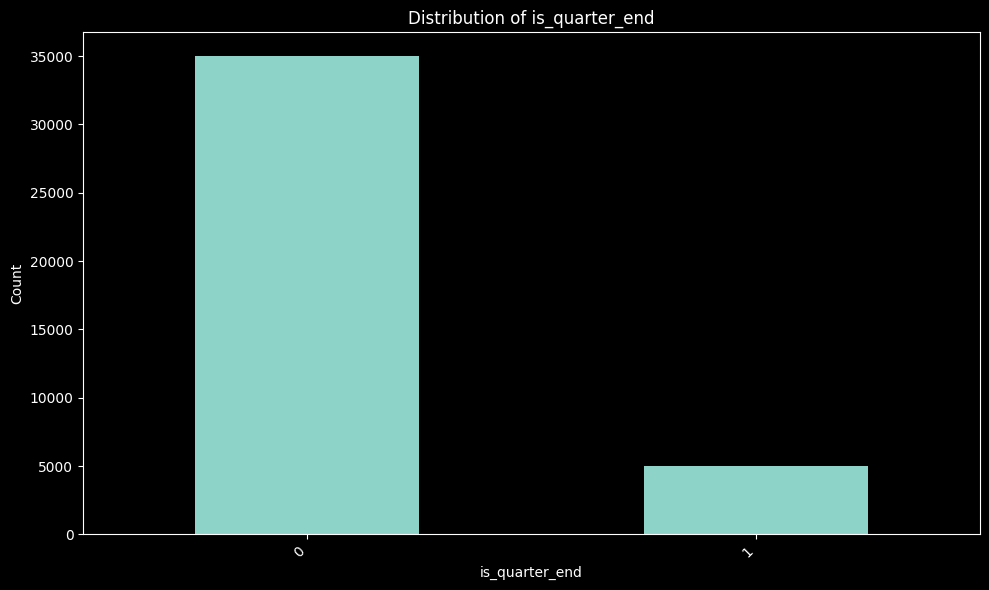

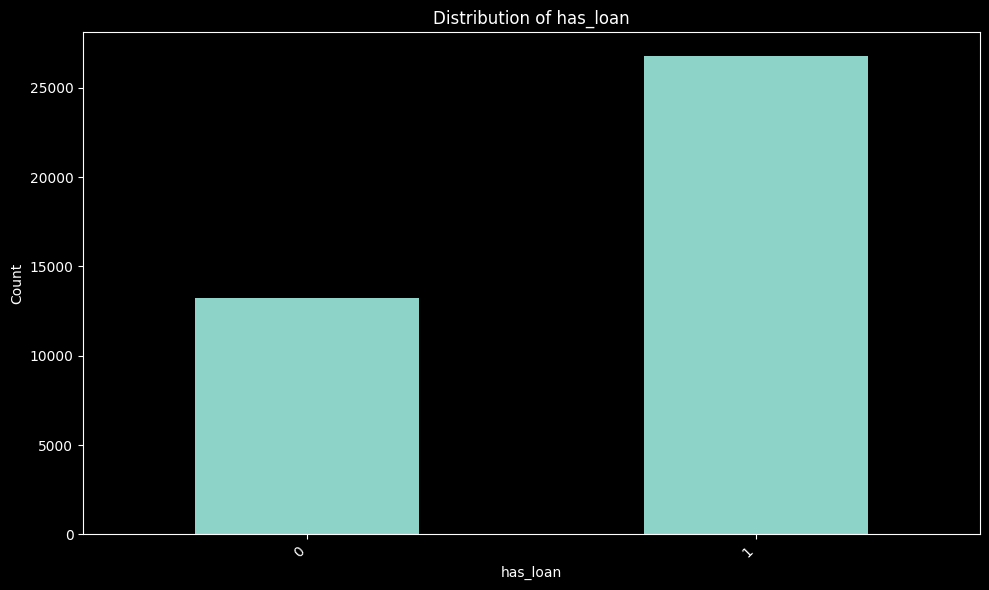

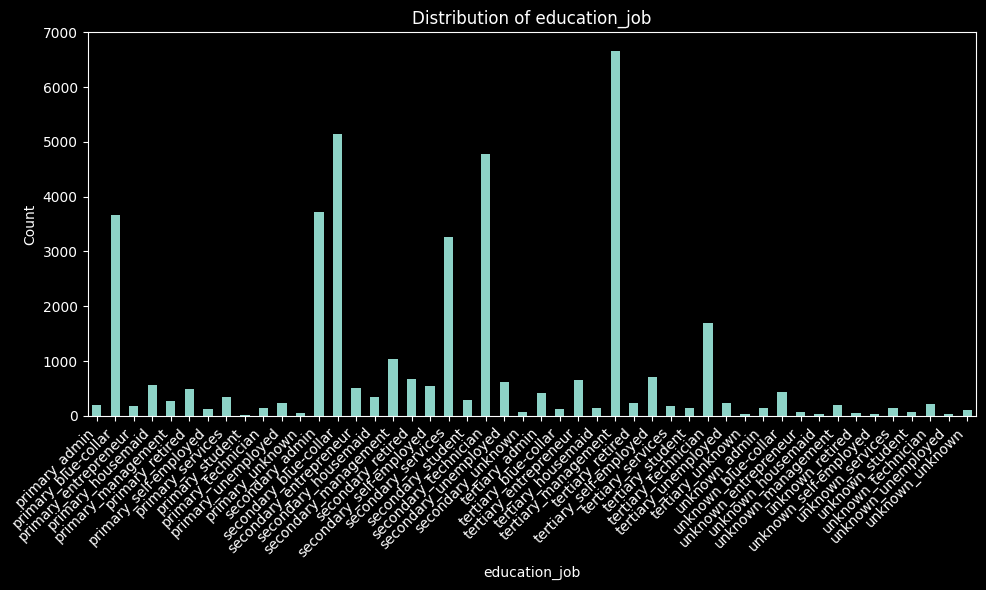

In [75]:
# plotting new features
plot_individual_features(customer_df_updated, features=['week',
       'quarter', 'loan_count', 'campaign_intensity',
       'contacted_multiple_times', 'age_group',
        'is_quarter_end', 'has_loan', 'education_job'])

### few important things to note about these new features with regards to customer subscription
- week 3 of month & quarter 2 seems to have highest number of subscriptions.
- people having one loan tend to get subscription.
- campaign intensity plays an important role in customer subscriptions.
- age group 30 - 39 have the highest tendency to get the subscription. 

### separating features again


In [76]:
## separating features again
numerical_features_updated = input_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_updated = input_features.select_dtypes(include=['object', 'category']).columns.tolist()


## Chapter 7: Preparing for Battle - The Preprocessing Arsenal ⚔️

### Setting up preprocessors using standard scaler for numeric columns and onehotencoder for categorical columns

Before our machine learning models can work their magic, we must transform our data into a language they understand.

In [77]:
## setting up preprocessors
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
binary_transformer = LabelEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features_updated),
        ('cat', categorical_transformer, categorical_features_updated)
        
    ]
)

### The sacred split: Train, Validate, Test 📊


Like a proper scientific experiment, we divide our data into three chambers - 70% for training, 15% for validation, and 15% for the final test.### TRAIN / VAL / TEST SPLIT (70 / 15 / 15)


In [78]:
# TRAIN / VAL / TEST SPLIT  (70 / 15 / 15)
X_train, X_temp, y_train, y_temp = train_test_split(
    input_features, target_variable, test_size=0.30, random_state=42, stratify=target_variable
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)


In [79]:
target_variable.unique()

array([0, 1])

In [80]:
customer_df['y'].value_counts()

y
no     37104
yes     2896
Name: count, dtype: int64

In [81]:
# calculate class weights for handling class imbalance
total = len(customer_df['y'])
# compute counts for each class (y contains 'yes'/'no' strings)
yes_count = (customer_df['y'] == 'yes').sum()
no_count = (customer_df['y'] == 'no').sum()

# avoid division by zero
if yes_count == 0 or no_count == 0:
    raise ValueError("One of the classes has zero samples; cannot compute class weights.")

# balanced class weights using sklearn formula: n_samples / (n_classes * n_samples_for_class)
cw_yes = total / (2 * yes_count)
print(f"Total samples: {total}")
print(f"Yes count: {yes_count}, No count: {no_count}")
print(f"Class weight for 'yes': {cw_yes:.2f}")
# class weight of no
cw_no = total / (2 * no_count)
print(f"Class weight for 'no': {cw_no:.2f}")

# Create dictionary for use in models
class_weight_dict = {'no': cw_no, 'yes': cw_yes}
print(f"\nClass weight dictionary: {class_weight_dict}")

Total samples: 40000
Yes count: 2896, No count: 37104
Class weight for 'yes': 6.91
Class weight for 'no': 0.54

Class weight dictionary: {'no': np.float64(0.5390254420008624), 'yes': np.float64(6.906077348066298)}


## Chapter 8: The Model Tournament Begins! 🏆

Now the real excitement begins! We'll pit multiple machine learning algorithms against each other, each competing to best predict customer subscriptions.

### Train logistic regression model

**First Contestant: Logistic Regression** - The classic, interpretable champion. Simple yet powerful!

In [326]:


# rebuild preprocessor to reflect the cleaned categorical_features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features_updated),
        ('cat', categorical_transformer, categorical_features_updated)
    ]
)


LogisticRegression Evaluation:
Accuracy: 0.9290
Precision: 0.7222
Recall: 0.0300
F1-Score: 0.0575

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5566
           1       0.72      0.03      0.06       434

    accuracy                           0.93      6000
   macro avg       0.83      0.51      0.51      6000
weighted avg       0.91      0.93      0.90      6000



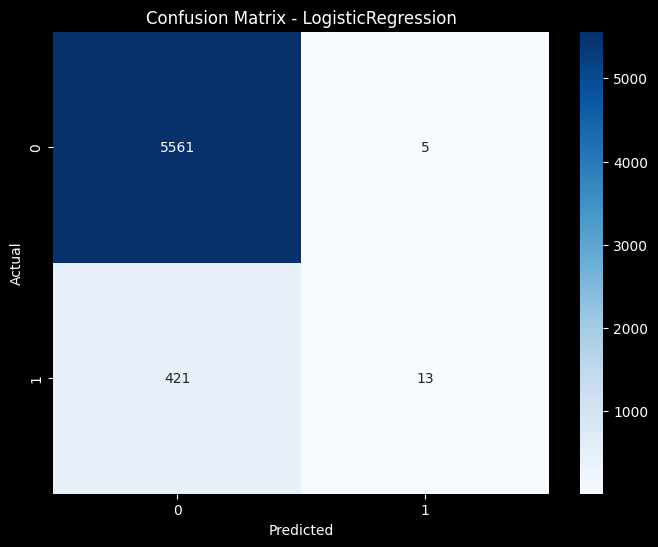

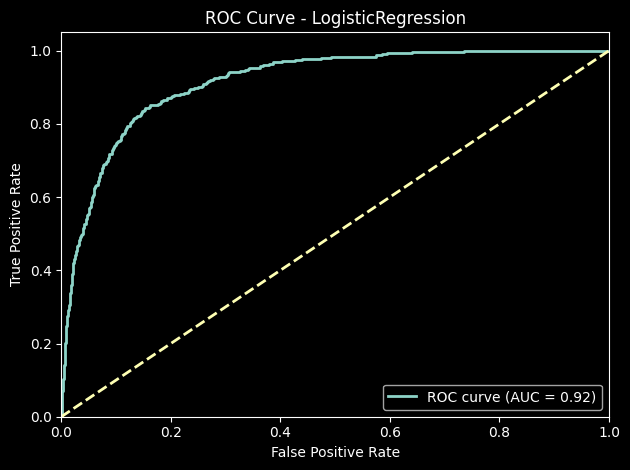

AUC (Logistic Regression): 0.9135257513110376


In [327]:
# Logistic Regression
class_weight_dict = {1: 1.0, 0: 6.0}
model_lr = LogisticRegression(class_weight=class_weight_dict, max_iter=1000, random_state=42)


#  fit the model
pipeline_lr = fit_model(model_lr, preprocessor, X_train, y_train)

# evaluate the model
model_name = type(pipeline_lr.named_steps['classifier']).__name__
evaluate_model(pipeline_lr, X_test, y_test, model_name=model_name)

#confusion matrix
model_name = type(pipeline_lr.named_steps['classifier']).__name__
y_pred_lr = pipeline_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

# ROC / AUC
model_name = type(pipeline_lr.named_steps['classifier']).__name__
y_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_proba_lr, title=f"ROC Curve - {model_name}")

#auc_lr = calculate_auc_score(pipeline_lr, X_test, y_test)
print("AUC (Logistic Regression):", auc_lr)

### using knn classifier : second one in the contest!



KNeighborsClassifier Evaluation:
Accuracy: 0.9312
Precision: 0.5471
Recall: 0.2811
F1-Score: 0.3714

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      5566
           1       0.55      0.28      0.37       434

    accuracy                           0.93      6000
   macro avg       0.75      0.63      0.67      6000
weighted avg       0.92      0.93      0.92      6000



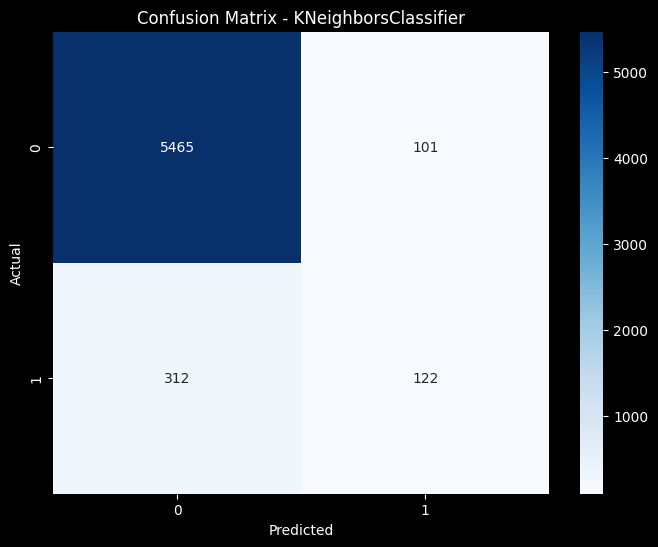

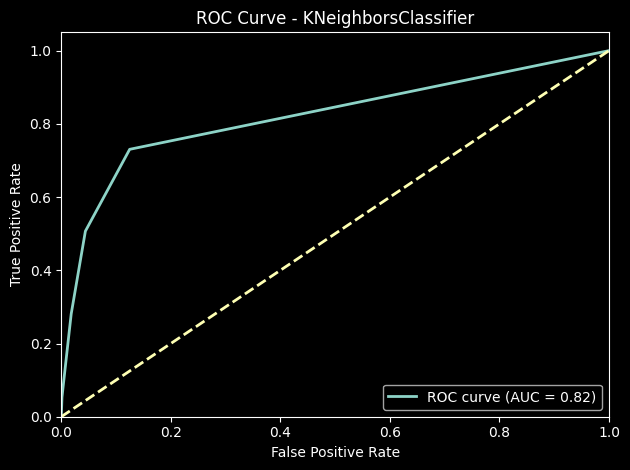

AUC (Logistic Regression): 0.8202477269001559


In [ ]:
### using knn classifier
class_weight_dict = {0: 1.0, 1: 6} 
weight_val ='6'

model_knn = KNeighborsClassifier(weights='uniform', n_neighbors=5)
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model_knn)])
#  fit the model
pipeline_knn = fit_model(model_knn, preprocessor, X_train, y_train)

# evaluate the model
model_name = type(pipeline_knn.named_steps['classifier']).__name__
evaluate_model(pipeline_knn, X_test, y_test, model_name=model_name)
#confusion matrix
model_name = type(pipeline_knn.named_steps['classifier']).__name__
y_pred_knn = pipeline_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

# ROC / AUC
model_name = type(pipeline_knn.named_steps['classifier']).__name__
y_proba_knn = pipeline_knn.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_proba_knn, title=f"ROC Curve - {model_name}")

auc_knn = calculate_auc_score(pipeline_knn, X_test, y_test)
print("AUC (Logistic Regression):", auc_knn)

### train Random Forest Classifier - the 3rd one!



RandomForestClassifier Evaluation:
Accuracy: 0.9335
Precision: 0.5897
Recall: 0.2650
F1-Score: 0.3657

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.96      5566
           1       0.59      0.26      0.37       434

    accuracy                           0.93      6000
   macro avg       0.77      0.63      0.67      6000
weighted avg       0.92      0.93      0.92      6000



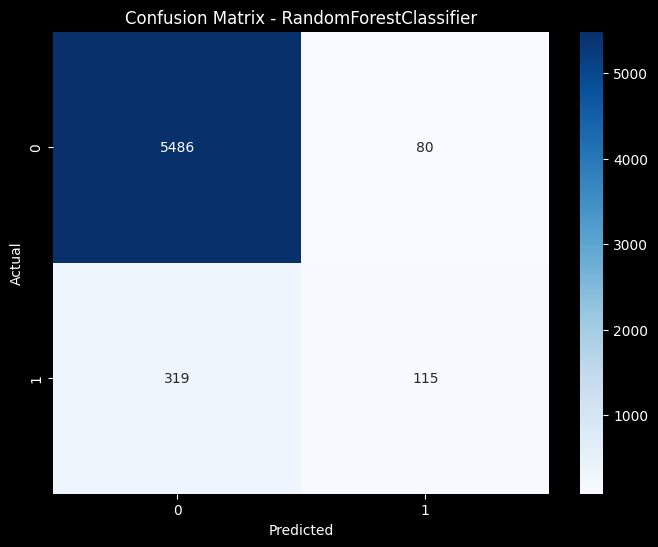

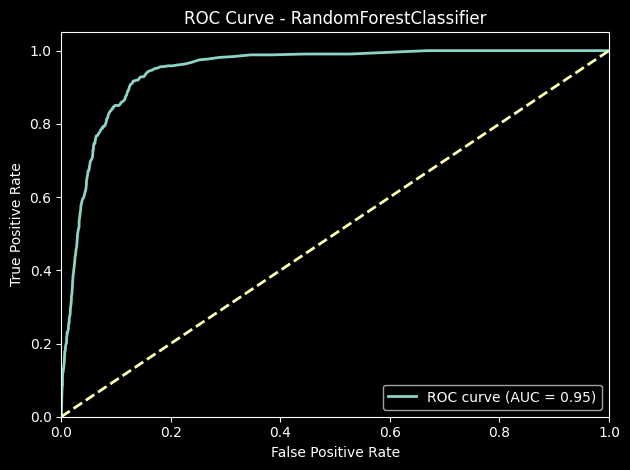

AUC (Random Forest): 0.945685912328141


In [373]:
## train Random Forest Classifier
class_weight_dict = {0: 1.0, 1: 5}  # keeping class weight of no as 1.0
model_rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight=class_weight_dict)
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_rf)])

#  fit the model
pipeline_rf = fit_model(model_rf, preprocessor, X_train, y_train)

# evaluate the model
model_name = type(pipeline_rf.named_steps['classifier']).__name__
evaluate_model(pipeline_rf, X_test, y_test, model_name=model_name)
#confusion matrix
model_name = type(pipeline_rf.named_steps['classifier']).__name__
y_pred_rf = pipeline_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

# ROC / AUC
model_name = type(pipeline_rf.named_steps['classifier']).__name__
y_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_proba_rf, title=f"ROC Curve - {model_name}")

## AUC score
auc_rf = calculate_auc_score(pipeline_rf, X_test, y_test)
print("AUC (Random Forest):", auc_rf)

### Fourth Contender: XGBoost ⚡

The gradient boosting powerhouse - iteratively learning from mistakes to achieve perfection! XGBoost has dominated ML competitions worldwide with its speed and accuracy.

### Train XGBoost Classifier


XGBClassifier Evaluation:
Accuracy: 0.9275
Precision: 0.4990
Recall: 0.5691
F1-Score: 0.5318

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5566
           1       0.50      0.57      0.53       434

    accuracy                           0.93      6000
   macro avg       0.73      0.76      0.75      6000
weighted avg       0.93      0.93      0.93      6000



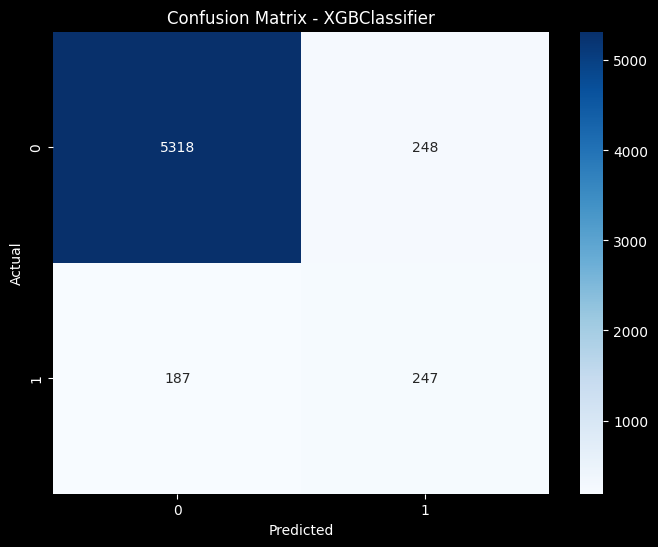

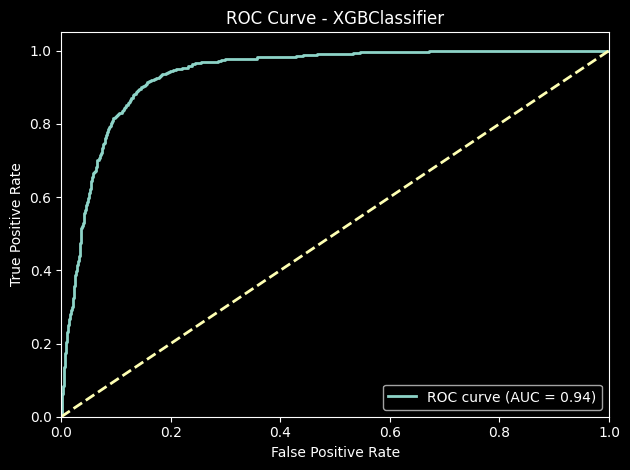

AUC (XGBoost): 0.9354996017625113


In [374]:
## train xgboost Classifier
model_xgb = xgb(n_estimators=300, random_state=42, scale_pos_weight=6,
                max_depth=6)
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_xgb)])

#  fit the model
pipeline_xgb = fit_model(model_xgb, preprocessor, X_train, y_train)

# evaluate the model
model_name = type(pipeline_xgb.named_steps['classifier']).__name__
evaluate_model(pipeline_xgb, X_test, y_test, model_name=model_name)
#confusion matrix
model_name = type(pipeline_xgb.named_steps['classifier']).__name__
y_pred_xgb = pipeline_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

# ROC / AUC
model_name = type(pipeline_xgb.named_steps['classifier']).__name__
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_proba_xgb, title=f"ROC Curve - {model_name}")

## AUC score
auc_xgb = calculate_auc_score(pipeline_xgb, X_test, y_test)
print("AUC (XGBoost):", auc_xgb)

### Fifth Gladiator: LightGBM 💡

The lightning-fast gradient booster - speed meets accuracy!


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 2027, number of negative: 25973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318920 -> initscore=-0.758741
[LightGBM] [Info] Start training from score -0.758741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

LGBMClassifier Evaluation:
Accuracy: 0.9197
Precision: 0.4653
Recall: 0.7419
F1-Score: 0.5719

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      5566
           1       0.47      0.74      0.57       434

    accuracy                           0.92      6000
   macro avg       0.72      0.84      0.76      6000
weighted avg       0.94      0.92      0.93      6000



c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


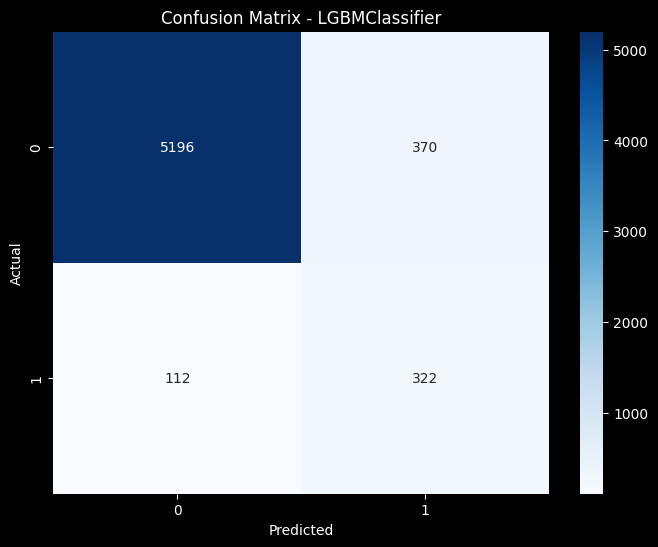

c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


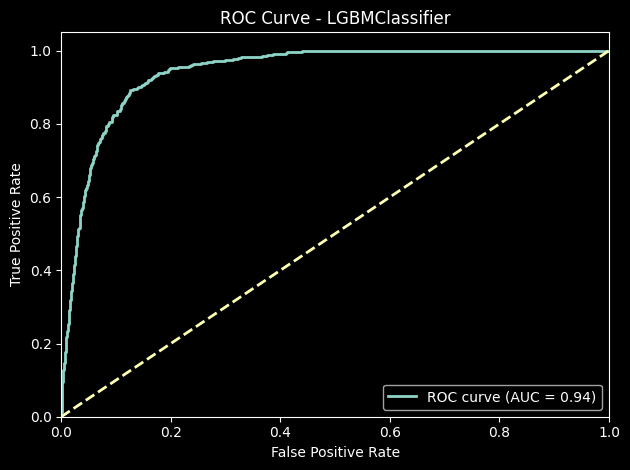

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
AUC (LightGBM): 0.9422365216066606


c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [375]:
### using lightgbm classifier
import lightgbm as lgb
class_weight_dict = {0: 1.0, 1: 6}  # keeping class weight of no as 1.0
model_lgb = lgb.LGBMClassifier(n_estimators=300, random_state=42
, class_weight=class_weight_dict, max_depth=6, num_leaves=31, min_data_in_leaf=20, min_split_gain=0.0)
pipeline_lgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_lgb)])


#  fit the model
pipeline_lgb = fit_model(model_lgb, preprocessor, X_train, y_train)

# evaluate the model
model_name = type(pipeline_lgb.named_steps['classifier']).__name__
evaluate_model(pipeline_lgb, X_test, y_test, model_name=model_name)
#confusion matrix
model_name = type(pipeline_lgb.named_steps['classifier']).__name__
y_pred_lgb = pipeline_lgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lgb)
plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

# ROC / AUC
model_name = type(pipeline_lgb.named_steps['classifier']).__name__
y_proba_lgb = pipeline_lgb.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_proba_lgb, title=f"ROC Curve - {model_name}")

## AUC score
auc_lgb = calculate_auc_score(pipeline_lgb, X_test, y_test)
print("AUC (LightGBM):", auc_lgb)



### Sixth Competitor: Decision Tree 🌳

The single tree - simple, visual, and interpretable (but prone to overfitting!)



DecisionTreeClassifier Evaluation:
Accuracy: 0.8997
Precision: 0.4007
Recall: 0.7811
F1-Score: 0.5297

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      5566
           1       0.40      0.78      0.53       434

    accuracy                           0.90      6000
   macro avg       0.69      0.85      0.74      6000
weighted avg       0.94      0.90      0.91      6000



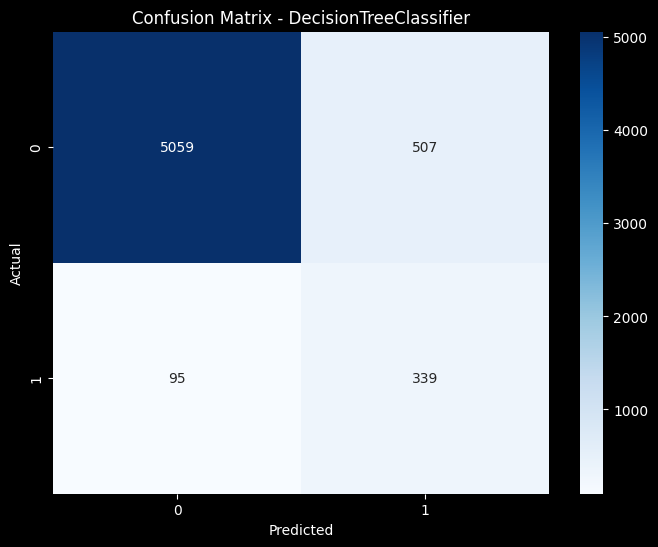

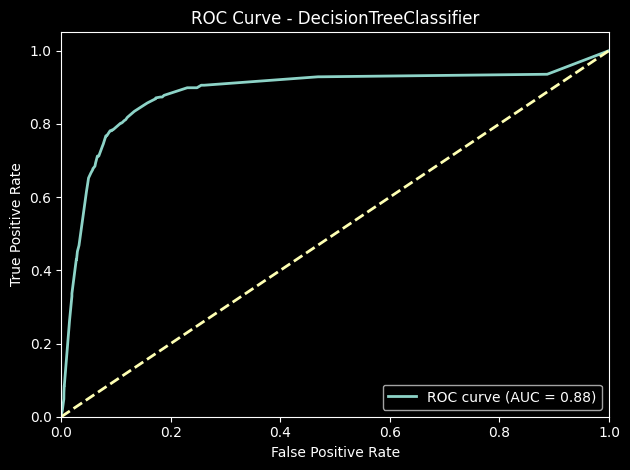

AUC (Decision Tree): 0.8838860361874514


In [376]:
### using decision tree classifier
class_weight_dict = {0: 1.0, 1: 6}  # keeping class weight of no as 1.0
model_dt = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict,max_depth=8)
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_dt)])


#  fit the model
pipeline_dt = fit_model(model_dt, preprocessor, X_train, y_train)

# evaluate the model
model_name = type(pipeline_dt.named_steps['classifier']).__name__
evaluate_model(pipeline_dt, X_test, y_test, model_name=model_name)
#confusion matrix
model_name = type(pipeline_dt.named_steps['classifier']).__name__
y_pred_dt = pipeline_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

# ROC / AUC
model_name = type(pipeline_dt.named_steps['classifier']).__name__
y_proba_dt = pipeline_dt.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_proba_dt, title=f"ROC Curve - {model_name}")

## AUC score
auc_dt = calculate_auc_score(pipeline_dt, X_test, y_test)
print("AUC (Decision Tree):", auc_dt)

### Seventh Champion: CatBoost 🐱

The categorical features specialist - handles categories like a boss!



CatBoostClassifier Evaluation:
Accuracy: 0.9120
Precision: 0.4394
Recall: 0.7857
F1-Score: 0.5636

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      5566
           1       0.44      0.79      0.56       434

    accuracy                           0.91      6000
   macro avg       0.71      0.85      0.76      6000
weighted avg       0.94      0.91      0.92      6000



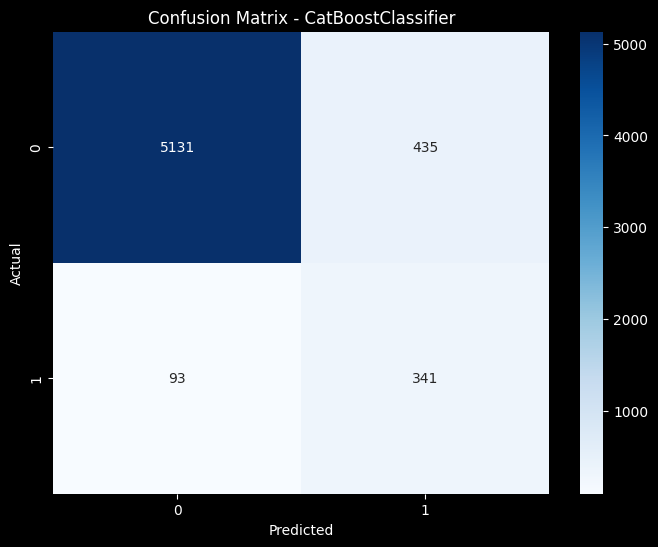

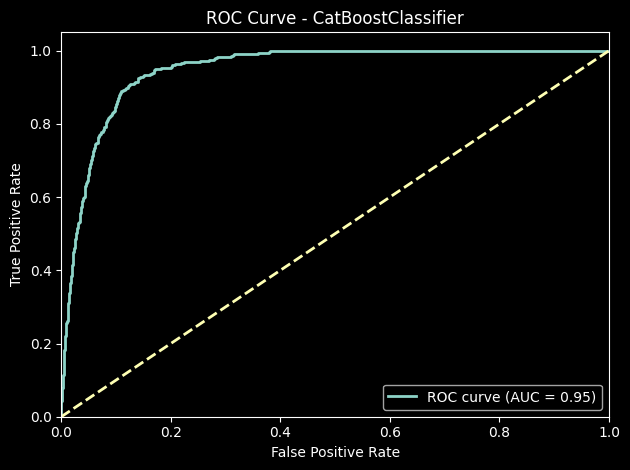

AUC (CatBoost): 0.94876562937254


In [377]:
### using catboost classifier
class_weight_dict = {0: 1.0, 1: 6}  # keeping class weight of no as 1.0
model_cat = CatBoostClassifier(iterations=300, random_state=42, class_weights=class_weight_dict, depth=6, learning_rate=0.1, verbose=0)
pipeline_cat = Pipeline(steps=[('preprocessor', preprocessor), 
                              ('classifier', model_cat)])


#  fit the model
pipeline_cat = fit_model(model_cat, preprocessor, X_train, y_train)

# evaluate the model
model_name = type(pipeline_cat.named_steps['classifier']).__name__
evaluate_model(pipeline_cat, X_test, y_test, model_name=model_name)
#confusion matrix
model_name = type(pipeline_cat.named_steps['classifier']).__name__
y_pred_cat = pipeline_cat.predict(X_test)
cm = confusion_matrix(y_test, y_pred_cat)
plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

# ROC / AUC
model_name = type(pipeline_cat.named_steps['classifier']).__name__
y_proba_cat = pipeline_cat.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_proba_cat, title=f"ROC Curve - {model_name}")

# AUC score
auc_cat = calculate_auc_score(pipeline_cat, X_test, y_test)
print("AUC (CatBoost):", auc_cat)

## 🏅 The Grand Comparison: Who Wins the Crown?

The moment of truth! Let's see which model reigns supreme in the battle for AUC scores...

### Plotting using AUC scores

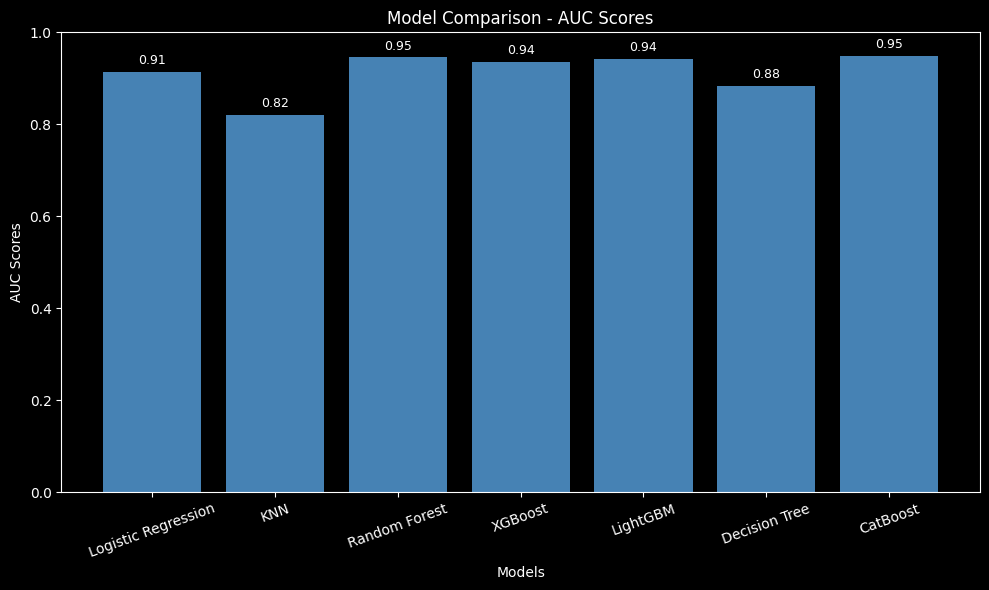

In [378]:
### model comparison - AUC scores
# Fixed bar plot for AUC comparison
models = ['Logistic Regression', 'KNN', 'Random Forest', 'XGBoost', 'LightGBM', 'Decision Tree', 'CatBoost']
auc_val = [auc_lr, auc_knn, auc_rf, auc_xgb, auc_lgb, auc_dt, auc_cat]
plt.figure(figsize=(10, 6))
bars = plt.bar(models, auc_val, color='steelblue')
plt.xlabel('Models')
plt.ylabel('AUC Scores')
plt.title('Model Comparison - AUC Scores')
plt.ylim(0, 1.0)
plt.xticks(rotation=20)
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.01, f'{h:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

## Chapter 9: Feature Importance - What Really Matters? 🔍

Not all features are created equal! Let's discover which variables hold the real predictive power...

### Feature selection using random forest

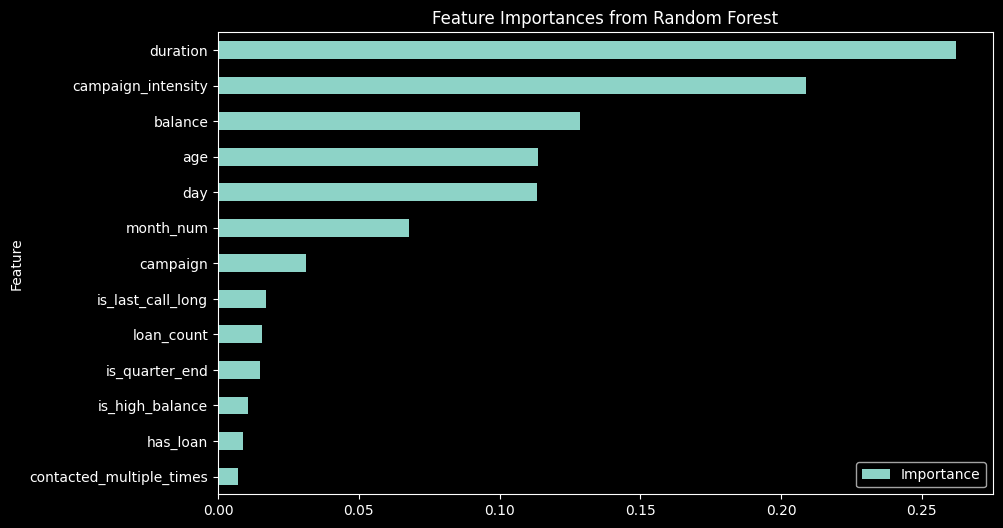

<Figure size 640x480 with 0 Axes>

In [379]:
### feature selection using random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(input_features.select_dtypes(include=[np.number]), target_variable)
importances = rf.feature_importances_
importances_df = pd.DataFrame({'Feature': input_features.select_dtypes(include=[np.number]).columns, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df.head(15).sort_values(by='Importance', ascending=True).plot(kind='barh', x='Feature', y='Importance', figsize=(10,6), title='Feature Importances from Random Forest')
plt.show()
##save feature importance plot
plt.savefig('../../reports/figures/feature_importances_random_forest.png')



### The top performers revealed! 🌟

These are the MVPs - the features that truly drive subscription decisions...

### Importance of top 6 features

In [381]:
# importance of top 6 features
print(importances_df.head(6))


               Feature  Importance
3             duration    0.262215
7   campaign_intensity    0.208922
1              balance    0.128700
0                  age    0.113594
2                  day    0.113418
10           month_num    0.067733


## 💎 The Power Players: Features That Drive Success

**The Critical Six:**
- 📞 **Duration of call** - The longer the conversation, the stronger the connection
- ⚡ **Campaign intensity** - Quality of engagement trumps quantity
- 💰 **Balance** - Financial capacity speaks volumes
- 👤 **Age of customer** - Life stage determines financial priorities
- 📅 **Month & Week** - Timing can make or break a campaign

### Pruning the dead wood 🪓

Time to be ruthless! Features with minimal importance only add noise. Let's remove them and see if our models improve...

### Remove features with low importance

In [382]:
### remove features with low importance
low_importance_features = importances_df[importances_df['Importance'] < 0.01]['Feature'].tolist()
print("Low importance features to be removed:", low_importance_features)

Low importance features to be removed: ['has_loan', 'contacted_multiple_times']


In [383]:
input_features_reduced = input_features.drop(columns=low_importance_features)
input_features_reduced.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'week',
       'quarter', 'is_high_balance', 'loan_count', 'campaign_intensity',
       'is_last_call_long', 'age_group', 'month_num', 'is_quarter_end',
       'education_job'],
      dtype='object')

In [384]:
updated_numerical_features_2 = input_features_reduced.select_dtypes(include=[np.number]).columns.tolist()
updated_categorical_features_2 = input_features_reduced.select_dtypes(include=['object', 'category']).columns.tolist()

### Rebuilding with our refined feature set 🔄

With deadweight removed, let's rebuild our preprocessing pipeline...

### Preprocessing steps with updated features

In [385]:

## preprocessing steps with updated features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
binary_transformer = LabelEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, updated_numerical_features_2),
        ('cat', categorical_transformer, updated_categorical_features_2)
            ]
)

### Testing the refined model 🧪

Does less really equal more? Let's retrain Catboost with our streamlined features...

### Using catboost classifier


CatBoostClassifier Evaluation:
Accuracy: 0.9120
Precision: 0.4394
Recall: 0.7857
F1-Score: 0.5636

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      5566
           1       0.44      0.79      0.56       434

    accuracy                           0.91      6000
   macro avg       0.71      0.85      0.76      6000
weighted avg       0.94      0.91      0.92      6000



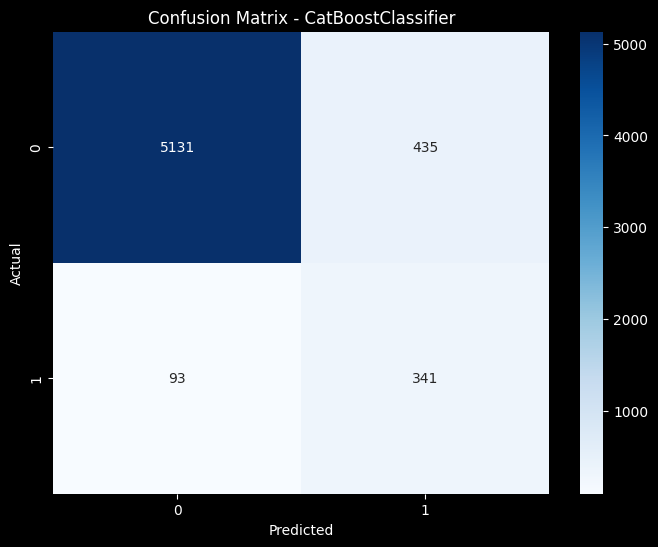

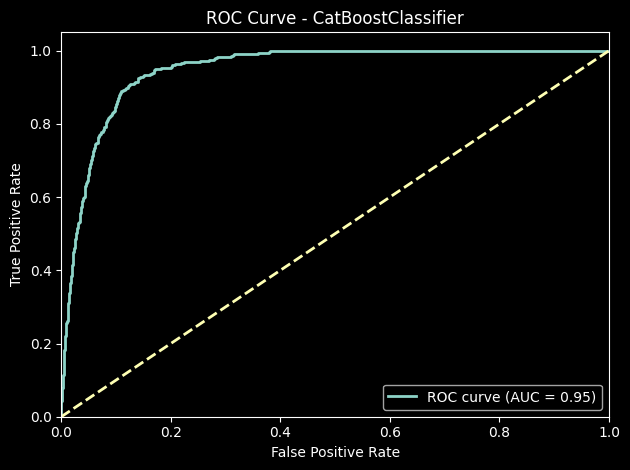

AUC (CatBoost): 0.94876562937254


In [386]:
### using catboost classifier
class_weight_dict = {0: 1.0, 1: 6}  # keeping class weight of no as 1.0
model_cat = CatBoostClassifier(iterations=300, random_state=42, class_weights=class_weight_dict, depth=6, learning_rate=0.1, verbose=0)
pipeline_cat = Pipeline(steps=[('preprocessor', preprocessor), 
                              ('classifier', model_cat)])


#  fit the model
pipeline_cat = fit_model(model_cat, preprocessor, X_train, y_train)

# evaluate the model
model_name = type(pipeline_cat.named_steps['classifier']).__name__
evaluate_model(pipeline_cat, X_test, y_test, model_name=model_name)
#confusion matrix
model_name = type(pipeline_cat.named_steps['classifier']).__name__
y_pred_cat = pipeline_cat.predict(X_test)
cm = confusion_matrix(y_test, y_pred_cat)
plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

# ROC / AUC
model_name = type(pipeline_cat.named_steps['classifier']).__name__
y_proba_cat = pipeline_cat.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_proba_cat, title=f"ROC Curve - {model_name}")

# AUC score
auc_cat = calculate_auc_score(pipeline_cat, X_test, y_test)
print("AUC (CatBoost):", auc_cat)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 2027, number of negative: 25973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318920 -> initscore=-0.758741
[LightGBM] [Info] Start training from score -0.758741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

LGBMClassifier Evaluation:
Accuracy: 0.9197
Precision: 0.4653
Recall: 0.7419
F1-Score: 0.5719

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      5566
           1       0.47      0.74      0.57       434

    accuracy                           0.92      6000
   macro avg       0.72      0.84      0.76      6000
weighted avg       0.94      0.92      0.93      6000



c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


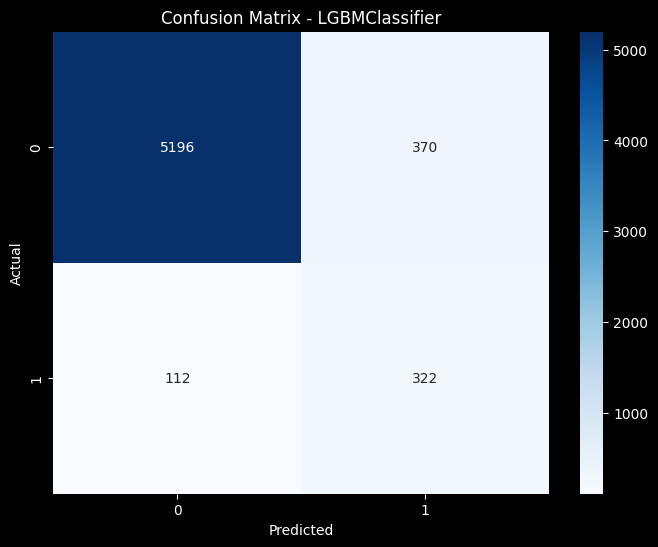

c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


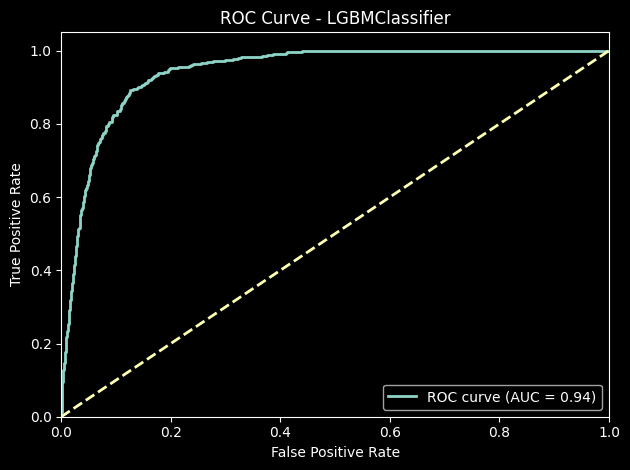

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
AUC (LightGBM): 0.9422365216066606


c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [387]:
### using lightgbm classifier
import lightgbm as lgb
class_weight_dict = {0: 1.0, 1: 6}  # keeping class weight of no as 1.0
model_lgb = lgb.LGBMClassifier(n_estimators=300, random_state=42
, class_weight=class_weight_dict, max_depth=6, num_leaves=31, min_data_in_leaf=20, min_split_gain=0.0)
pipeline_lgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_lgb)])


#  fit the model
pipeline_lgb = fit_model(model_lgb, preprocessor, X_train, y_train)

# evaluate the model
model_name = type(pipeline_lgb.named_steps['classifier']).__name__
evaluate_model(pipeline_lgb, X_test, y_test, model_name=model_name)
#confusion matrix
model_name = type(pipeline_lgb.named_steps['classifier']).__name__
y_pred_lgb = pipeline_lgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lgb)
plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

# ROC / AUC
model_name = type(pipeline_lgb.named_steps['classifier']).__name__
y_proba_lgb = pipeline_lgb.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_proba_lgb, title=f"ROC Curve - {model_name}")

## AUC score
auc_lgb = calculate_auc_score(pipeline_lgb, X_test, y_test)
print("AUC (LightGBM):", auc_lgb)



## 🤔 The Surprising Truth

#### Apparently no improvement even with the removal of the low importance features

Sometimes in data science, our hypotheses don't pan out. The low-importance features weren't causing harm - they were just along for the ride. This teaches us an important lesson: **feature importance ≠ feature redundancy**.

## Chapter 10: The Segmentation Saga 🗺️

Classification is powerful, but what about understanding the **subscribers themselves**? Time to shift gears from prediction to comprehension!

### Performing clustering on the subscriber population and perform the analysis on the clusters to identify common characteristics. Performing a customer segmentation analysis

Our new quest: uncover the hidden tribes within our subscriber base...

### Isolating our champions 🏆

Let's focus exclusively on the customers who said "YES!" - they hold the secrets to success...

### Loading the final dataset with subscribed customers only

In [88]:
### loading the final dataset with subscribed customers only
subscribed_customers= customer_df[customer_df['y']=='yes']
### saving to a file
subscribed_customers.to_csv('../../data/processed/subscribed_customers.csv', index=False)

### 🎯 Preparing for the Journey

Before we can discover the hidden tribes, we must **drop the target variable** - clustering is an unsupervised adventure where we let patterns emerge naturally!

In [89]:
# drop target variable for clustering
subscribed_customers_features = subscribed_customers.drop('y', axis=1)

In [90]:
subscribed_customers.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y', 'week'],
      dtype='object')

### Feature engineering redux - subscriber edition 🛠️

We'll apply the same feature engineering magic to our subscriber-only dataset...

### Feature engineering on subscribed customers dataset

In [91]:
## feature engineering on subscribed customers dataset
## day needs to be categorical
subscribed_customers_features['day'] = subscribed_customers_features['day'].astype('int')

subscribed_customers_features['week'] = subscribed_customers_features['day'].apply(lambda x: (int(x)-1)//7 + 1)
subscribed_customers_features['week'] = subscribed_customers_features['week'].astype('category')
subscribed_customers_features['balance_log'] = np.log1p(subscribed_customers_features['balance'] - subscribed_customers_features['balance'].min() + 1)

### converting month to quarter


In [92]:
# # converting month to quarter
# monthname = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# # normalize month values and map to quarter
# subscribed_customers_features['month_norm'] = subscribed_customers_features['month'].astype(str).str.lower()

# def month_to_quarter(m):
# 	try:
# 		return (monthname.index(m) // 3) + 1
# 	except ValueError:
# 		return np.nan
convert_month_to_quarter(subscribed_customers_features,month_column='month', quarter_column='quarter', 
                            drop_month=False)

subscribed_customers_features['quarter'] = subscribed_customers_features['quarter'].astype('category')
#subscribed_customers_features.drop(columns=['month_norm'], inplace=True)
subscribed_customers_features['quarter'].value_counts(dropna=False)

quarter
2    1536
3     672
1     418
4     270
Name: count, dtype: int64

In [93]:
subscribed_customers_features['quarter'].unique()

[2, 3, 4, 1]
Categories (4, int64): [1 < 2 < 3 < 4]

### 💰 Engineering Financial Signals

Creating **is_high_balance** and **loan_count** - these binary and count features will help our clustering algorithm distinguish the financially secure from those still building wealth!

In [94]:
# creating new features is_high_balance and loan_count
is_high_balance = subscribed_customers_features['balance'] > subscribed_customers_features['balance'].median()
print(is_high_balance)
loan_count = subscribed_customers_features['housing'].map({'yes':1, 'no':0}) + subscribed_customers_features['loan'].map({'yes':1, 'no':0})
print(loan_count)

83        True
86       False
87        True
129       True
168      False
         ...  
39986     True
39988     True
39990     True
39996     True
39997    False
Name: balance, Length: 2896, dtype: bool
83       1
86       0
87       1
129      1
168      0
        ..
39986    1
39988    0
39990    1
39996    0
39997    0
Length: 2896, dtype: int64


### 📞 Campaign Behavior Markers

How customers respond to outreach tells a story - **campaign_intensity**, **contacted_multiple_times**, and **is_last_call_long** capture engagement patterns that differentiate subscriber types!

In [95]:
## adding campaign features
subscribed_customers_features['campaign_intensity'] = subscribed_customers_features['duration'] / (subscribed_customers_features['campaign'] + 1)
contacted_multiple_times = subscribed_customers_features['campaign'] > 1
subscribed_customers_features['contacted_multiple_times'] = contacted_multiple_times.astype(int)
is_last_call_long = subscribed_customers_features['duration'] > subscribed_customers_features['duration'].median()
subscribed_customers_features['is_last_call_long'] = is_last_call_long.astype(int)

### 👥 Life Stage Categorization

Age isn't just a number - it's a **life stage indicator**! Binning age into groups (18-29, 30-39, etc.) helps reveal generational patterns in financial behavior.

In [96]:
## adding age binning
age_bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['<18', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
subscribed_customers_features['age_group'] = pd.cut(subscribed_customers_features['age'], bins=age_bins, labels=age_labels, right=False)

### 🧩 Assembling the Complete Picture

All engineered features come together - **financial signals**, **temporal patterns**, **demographic bins**, and **behavioral markers**. Our dataset is now primed for clustering discovery!

In [97]:
### adding all new features to subscribed_customers_features
subscribed_customers_features['is_high_balance'] = is_high_balance.astype(int)
subscribed_customers_features['loan_count'] = loan_count
subscribed_customers_features['age_group'] = subscribed_customers_features['age_group']
subscribed_customers_features['week'] = subscribed_customers_features['week']
subscribed_customers_features['quarter'] = subscribed_customers_features['quarter']
subscribed_customers_features['campaign_intensity'] = subscribed_customers_features['campaign_intensity']
subscribed_customers_features['contacted_multiple_times'] = subscribed_customers_features['contacted_multiple_times']
subscribed_customers_features['is_last_call_long'] = subscribed_customers_features['is_last_call_long']
subscribed_customers_features['month_num'] = subscribed_customers_features['month'].map(month_map)
subscribed_customers_features['is_quarter_end'] = subscribed_customers_features['month_num'].isin([3,6,9,12]).astype(int)


In [98]:
subscribed_customers_features.describe()

,age,balance,day,duration,campaign,balance_log,campaign_intensity,contacted_multiple_times,is_last_call_long,is_high_balance,loan_count,month_num,is_quarter_end
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000
mean,39.844959,1588.495856,15.827003,682.958564,2.414365,8.342092,239.396247,0.563536,0.499309,0.499655,0.636740,5.649171,0.145028
std,11.001984,2924.894429,8.557604,431.287174,2.306015,0.419144,173.881517,0.496032,0.500086,0.500086,0.619167,2.369171,0.352189
min,19.000000,-3058.000000,1.000000,8.000000,1.000000,0.693147,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,31.000000,141.000000,8.000000,364.000000,1.000000,8.071219,110.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
50%,37.000000,620.000000,16.000000,629.000000,2.000000,8.210668,203.000000,1.000000,0.000000,0.000000,1.000000,5.000000,0.000000
75%,47.000000,1820.500000,22.000000,913.000000,3.000000,8.493003,324.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.000000
max,95.000000,45248.000000,31.000000,3881.000000,32.000000,10.785352,1626.500000,1.000000,1.000000,1.000000,2.000000,12.000000,1.000000


### Preparing features for clustering magic ✨

Clustering algorithms are sensitive - we need to prepare our data with care...

### Separating numerical and categorical features

In [99]:
## separating numerical and categorical features
numerical_features_subscribed = subscribed_customers_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_subscribed = subscribed_customers_features.select_dtypes(include=['object', 'category']).columns.tolist()
print(numerical_features_subscribed)
print(categorical_features_subscribed)

['age', 'balance', 'day', 'duration', 'campaign', 'balance_log', 'campaign_intensity', 'contacted_multiple_times', 'is_last_call_long', 'is_high_balance', 'loan_count', 'month_num', 'is_quarter_end']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'week', 'quarter', 'age_group']


### Scaling for fairness ⚖️

Numbers have different scales - balance matters! A difference of 1000 in balance shouldn't overpower a difference of 1 in age...

### Scaling numerical features

In [100]:
## scaling numerical features
scaler = StandardScaler()
numerical_features_subscribed_scaled = scaler.fit_transform(subscribed_customers_features[numerical_features_subscribed])
numerical_features_subscribed_scaled_df = pd.DataFrame(numerical_features_subscribed_scaled, columns=numerical_features_subscribed)

### One-hot encoding: Teaching machines about categories 🎭

Categories need translation - "married" and "single" must become numbers the algorithm can understand...

### Encoding categorical features

In [101]:
## encoding categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_features_subscribed_encoded = encoder.fit_transform(subscribed_customers_features[categorical_features_subscribed])
categorical_feature_names = encoder.get_feature_names_out(categorical_features_subscribed)
categorical_features_subscribed_encoded_df = pd.DataFrame(categorical_features_subscribed_encoded, columns=categorical_feature_names)

### 🔗 Merging Transformed Features

Bringing scaled numerics and encoded categoricals together - creating our final feature matrix ready for K-Means clustering!

In [102]:
subscribed_customers_features_processed = pd.concat([numerical_features_subscribed_scaled_df.reset_index(drop=True), categorical_features_subscribed_encoded_df.reset_index(drop=True)], axis=1)

## Chapter 11: Finding the Optimal Clusters 🎯

How many tribes exist within our subscribers? Two powerful methods will guide us to the answer...

The Elbow Method and Silhouette Analysis will reveal the natural groupings hidden in our data!

### K-means clustering - The Quest for Optimal K

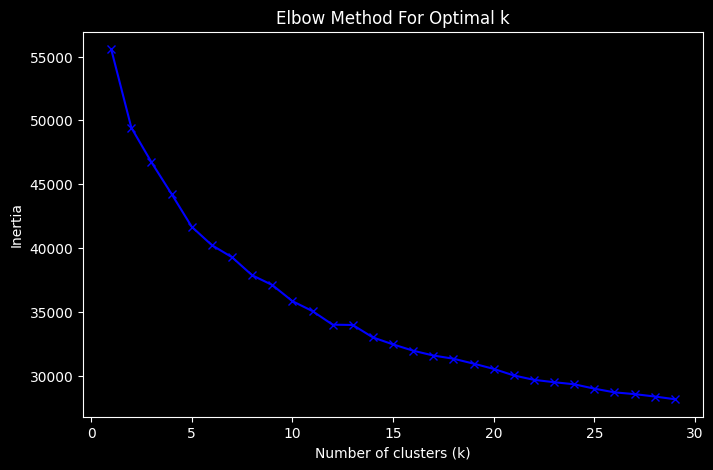

In [104]:
### k-means clustering

inertia = []
K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(subscribed_customers_features_processed)
    inertia.append(kmeans.inertia_)
# plot the elbow method
# plt.figure(figsize=(8, 5))
# plt.plot(K, inertia, 'bx-')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method For Optimal k')
# plt.show()
# ## saving elbow method plot
# plt.savefig('../../reports/figures/elbow_method_kmeans.png')
# plot using plotly
# fig = px.line(x=K, y=inertia, title='Elbow Method For Optimal k', labels={'x':'Number of clusters (k)', 'y':'Inertia'})
# fig.show()
# fig.write_image('../../reports/figures/elbow_method_kmeans.png')

fig = plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.savefig('../../reports/figures/elbow_method_kmeans.png')
plt.show()
    

## 📍 The Elbow Speaks!

**K seem to be between 2 - 5 giving an optimal value.**



### Double-checking with silhouette scores 🔍

The elbow method gave us a hint, but let's validate with silhouette analysis - measuring cluster cohesion and separation...

### Find optimal number of clusters using silhouette score

For n_clusters = 2, the average silhouette_score is : 0.11029827183017205
For n_clusters = 3, the average silhouette_score is : 0.11147143588541501
For n_clusters = 3, the average silhouette_score is : 0.11147143588541501
For n_clusters = 4, the average silhouette_score is : 0.10365848036058112
For n_clusters = 4, the average silhouette_score is : 0.10365848036058112
For n_clusters = 5, the average silhouette_score is : 0.10299897576398413
For n_clusters = 5, the average silhouette_score is : 0.10299897576398413
For n_clusters = 6, the average silhouette_score is : 0.08815200148741803
For n_clusters = 6, the average silhouette_score is : 0.08815200148741803
For n_clusters = 7, the average silhouette_score is : 0.09592049191040387
For n_clusters = 7, the average silhouette_score is : 0.09592049191040387
For n_clusters = 8, the average silhouette_score is : 0.0872930308520041
For n_clusters = 8, the average silhouette_score is : 0.0872930308520041
For n_clusters = 9, the average silhouet

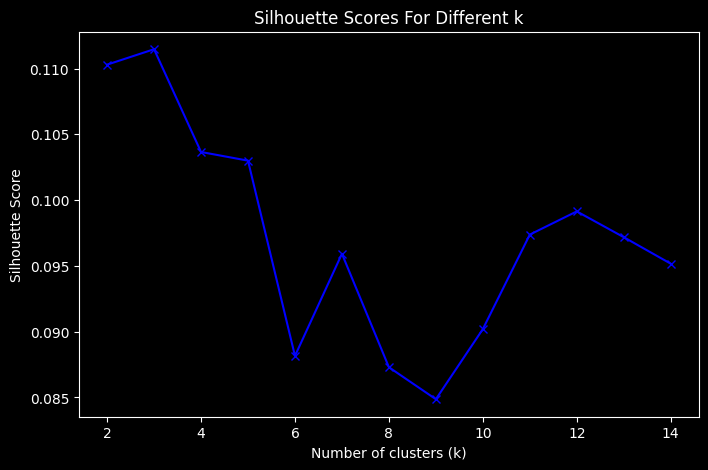

In [106]:
## find optimal number of clusters using silhouette score
silhouette_scores = []

# transform features once to avoid repeated work
#X_clust = preprocessor.fit_transform(subscribed_customers_features)

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(subscribed_customers_features_processed)
    silhouette_avg = silhouette_score(subscribed_customers_features_processed, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")

# # plot silhouette scores
# fig = px.line(x=list(range(2, 15)), y=silhouette_scores,
#               title='Silhouette Scores For Different k',
#               labels={'x':'Number of clusters (k)', 'y':'Silhouette Score'})
# fig.show()
# fig.write_image('../../reports/figures/silhouette_scores_kmeans.png')


# plot silhouette scores using matplotlib
fig = plt.figure(figsize=(8, 5))
plt.plot(range(2, 15), silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Different k')
plt.savefig('../../reports/figures/silhouette_scores_kmeans.png')
plt.show()

## ✅ Confirmed: 3 is the Magic Number!

**From silhouette graph, the optimal value is 3 as there is a steep drop after 3.**

our subscriber base seem to form **three distinct segments**!

### Creating the three tribes 🏛️

Time to assign each subscriber to their cluster - revealing the hidden structure within our customer base...

### Final kmeans with optimal clusters (say 3)

In [107]:
# final kmeans with optimal clusters (say 3)
kmeans_final = KMeans(n_clusters=3, random_state=42)
kmeans_final.fit(subscribed_customers_features_processed)
subscribed_customers_features_processed['cluster'] = kmeans_final.labels_
subscribed_customers_features_processed['cluster'].value_counts()

cluster
1    1297
0    1193
2     406
Name: count, dtype: int64

In [111]:
## PCA for visualization

pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(subscribed_customers_features_processed.drop('cluster', axis=1))
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = subscribed_customers_features_processed['cluster'].values
# plot PCA clusters
fig = px.scatter(pca_df, x='PC1', y='PC2', color='cluster',
                 title='PCA of Subscribed Customers Clusters',
                 labels={'PC1':'Principal Component 1', 'PC2':'Principal Component 2'}) 
fig.show()
fig.write_image('../../reports/figures/pca_clusters_kmeans.png')

## 3-D PCA plot
pca_3d = PCA(n_components=3, random_state=42)
principal_components_3d = pca_3d.fit_transform(subscribed_customers_features_processed.drop('cluster', axis=1))
pca_3d_df = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])
pca_3d_df['cluster'] = subscribed_customers_features_processed['cluster'].values
# plot 3D PCA clusters
fig = px.scatter_3d(pca_3d_df, x='PC1', y='PC2', z='PC3', color='cluster',
                    title='3D PCA of Subscribed Customers Clusters',
                    labels={'PC1':'Principal Component 1', 'PC2':'Principal Component 2', 'PC3':'Principal Component 3'})

fig.show()

fig.write_image('../../reports/figures/pca_3d_clusters_kmeans.png')

## Chapter 12: Meeting the Three Tribes 👥

Each cluster represents a unique customer archetype with distinct behaviors, demographics, and financial patterns. Let's profile them!

### Cluster profiling - Who are these people?

In [364]:
### cluster profiling
cluster_profiles = {}
for cluster in range(3):
    cluster_data = subscribed_customers_features_processed[subscribed_customers_features_processed['cluster'] == cluster]
    profile = {}
    for col in subscribed_customers_features_processed.columns:
        if col != 'cluster':
            if col in numerical_features_subscribed:
                profile[col] = cluster_data[col].mean()
            else:
                profile[col] = cluster_data[col].mode()[0]
    cluster_profiles[cluster] = profile
print(cluster_profiles)

{0: {'age': np.float64(0.0015213198401644896), 'balance': np.float64(0.06202352020868162), 'day': np.float64(0.17108917883913094), 'duration': np.float64(-0.7226166508957903), 'campaign': np.float64(-0.1080989110143306), 'balance_log': np.float64(0.07015577998301394), 'campaign_intensity': np.float64(-0.5678596251240201), 'contacted_multiple_times': np.float64(-0.17796968627143664), 'is_last_call_long': np.float64(-0.9952668420248335), 'is_high_balance': np.float64(0.023322633413895684), 'loan_count': np.float64(-0.16604567293449946), 'month_num': np.float64(-0.125431586824289), 'is_quarter_end': np.float64(-0.41185972485347644), 'job_admin': np.float64(0.0), 'job_blue-collar': np.float64(0.0), 'job_entrepreneur': np.float64(0.0), 'job_housemaid': np.float64(0.0), 'job_management': np.float64(0.0), 'job_retired': np.float64(0.0), 'job_self-employed': np.float64(0.0), 'job_services': np.float64(0.0), 'job_student': np.float64(0.0), 'job_technician': np.float64(0.0), 'job_unemployed': np

### 📝 Profiling the Three Tribes

Numbers come alive when formatted beautifully! Let's see the defining characteristics of each of our **three customer segments** in readable format...

In [365]:
### pretty print cluster profiles
for cluster, profile in cluster_profiles.items():
    print(f"\nCluster {cluster} Profile:")
    for feature, value in profile.items():
        print(f"  {feature}: {value}")


Cluster 0 Profile:
  age: 0.0015213198401644896
  balance: 0.06202352020868162
  day: 0.17108917883913094
  duration: -0.7226166508957903
  campaign: -0.1080989110143306
  balance_log: 0.07015577998301394
  campaign_intensity: -0.5678596251240201
  contacted_multiple_times: -0.17796968627143664
  is_last_call_long: -0.9952668420248335
  is_high_balance: 0.023322633413895684
  loan_count: -0.16604567293449946
  month_num: -0.125431586824289
  is_quarter_end: -0.41185972485347644
  job_admin: 0.0
  job_blue-collar: 0.0
  job_entrepreneur: 0.0
  job_housemaid: 0.0
  job_management: 0.0
  job_retired: 0.0
  job_self-employed: 0.0
  job_services: 0.0
  job_student: 0.0
  job_technician: 0.0
  job_unemployed: 0.0
  job_unknown: 0.0
  marital_divorced: 0.0
  marital_married: 1.0
  marital_single: 0.0
  education_primary: 0.0
  education_secondary: 0.0
  education_tertiary: 0.0
  education_unknown: 0.0
  default_no: 1.0
  default_yes: 0.0
  housing_no: 1.0
  housing_yes: 0.0
  loan_no: 1.0
  

### 🔬 Executing the Clustering Algorithm

Time to invoke our clustering function with **k=3** - watching the algorithm partition our subscribers into three meaningful segments based on hidden patterns!

In [366]:
get_clusters(3, subscribed_customers_features_processed)

,age,balance,day,duration,campaign,balance_log,campaign_intensity,contacted_multiple_times,is_last_call_long,is_high_balance,...,quarter_4,age_group_18-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70-79,age_group_80+,cluster,class
0,1.741354,0.258004,-1.265409,0.832632,-0.613443,0.602802,1.619795,-1.136283,1.001382,1.000691,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
1,1.468629,-0.527801,-1.265409,1.818224,-0.613443,-0.719025,2.842102,-1.136283,1.001382,-0.999310,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
2,0.105003,-0.108910,-1.265409,1.637339,-0.613443,0.074524,2.617773,-1.136283,1.001382,1.000691,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,2
3,1.377720,0.303484,-1.265409,-0.241084,-0.613443,0.660830,0.288199,-1.136283,-0.998620,1.000691,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
4,1.286812,-0.480270,-1.265409,-0.023094,-0.179720,-0.614524,-0.086642,0.880062,1.001382,-0.999310,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,-0.985898,-0.325366,-1.499160,-0.795335,-0.613443,-0.302609,-0.399170,-1.136283,-0.998620,1.000691,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
2892,1.377720,0.271682,-1.499160,-0.213256,-0.179720,0.620403,-0.243865,0.880062,-0.998620,1.000691,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0
2893,-1.258623,-0.122246,-1.499160,-0.690978,-0.179720,0.052934,-0.638838,0.880062,-0.998620,1.000691,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
2894,-0.894989,0.598930,-1.499160,-1.031877,0.254004,1.006894,-1.034770,0.880062,-0.998620,1.000691,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,0


### Visualizing the tribal differences 📊

Numbers tell one story, visualizations tell another. Let's see how each feature distributes across our **three clusters** - revealing the distinctive patterns that define each segment!

### Understanding feature distributions across clusters

C:\Users\My-PC\AppData\Local\Temp\ipykernel_9548\2850626316.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



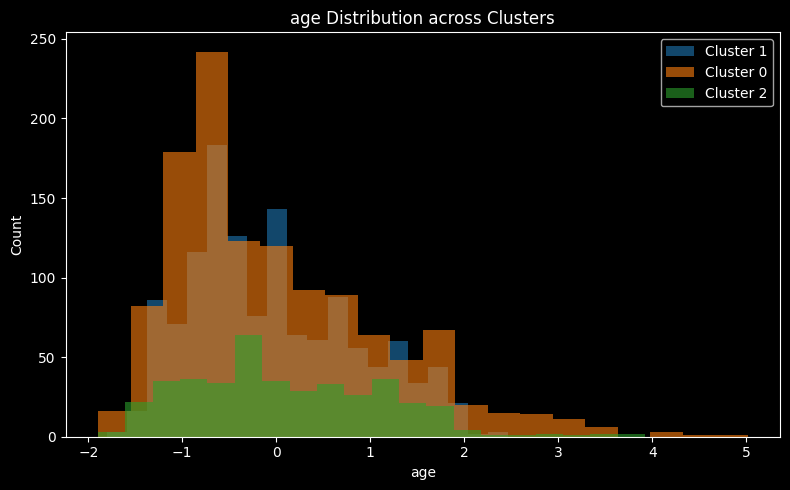

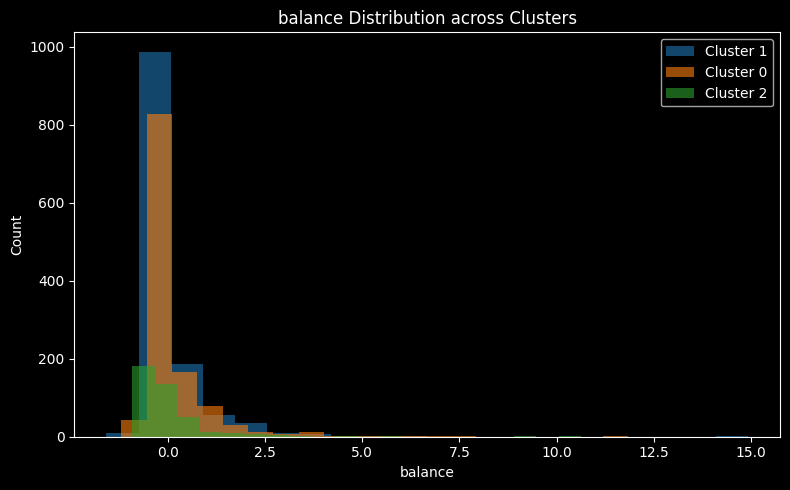

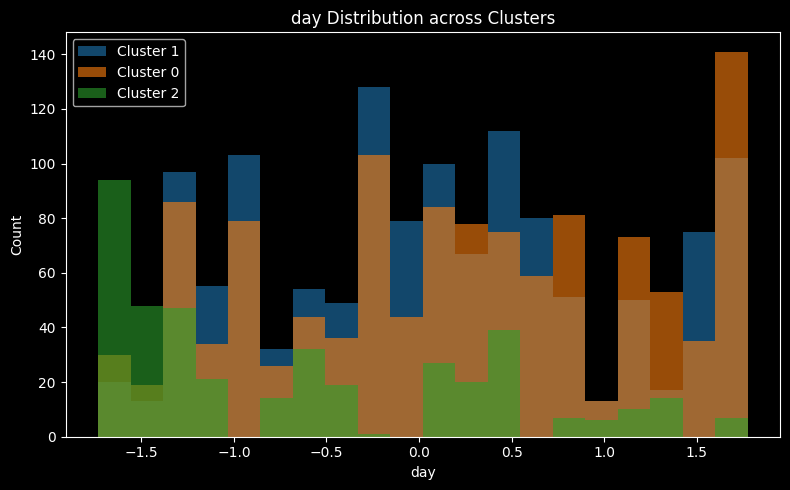

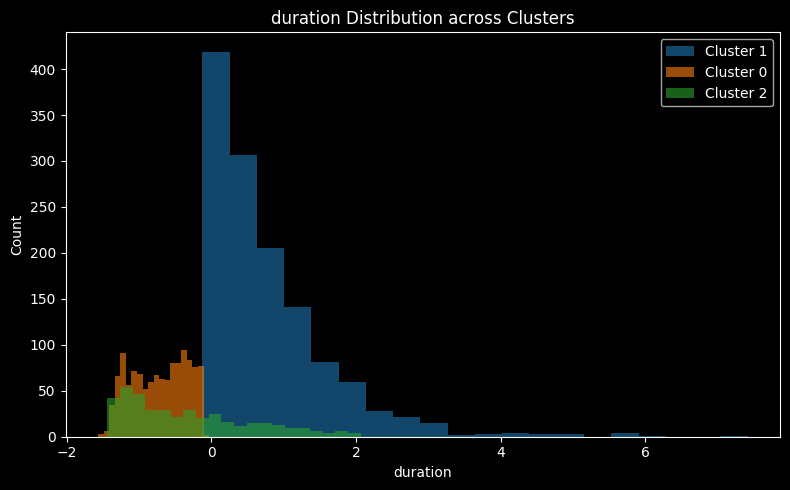

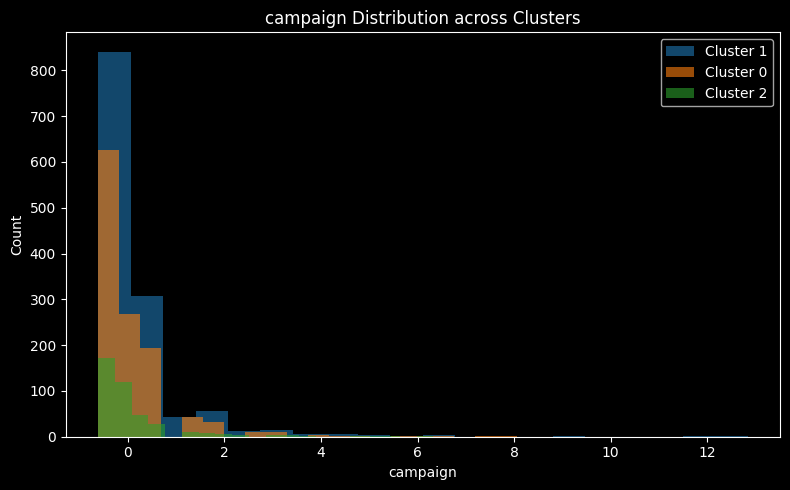

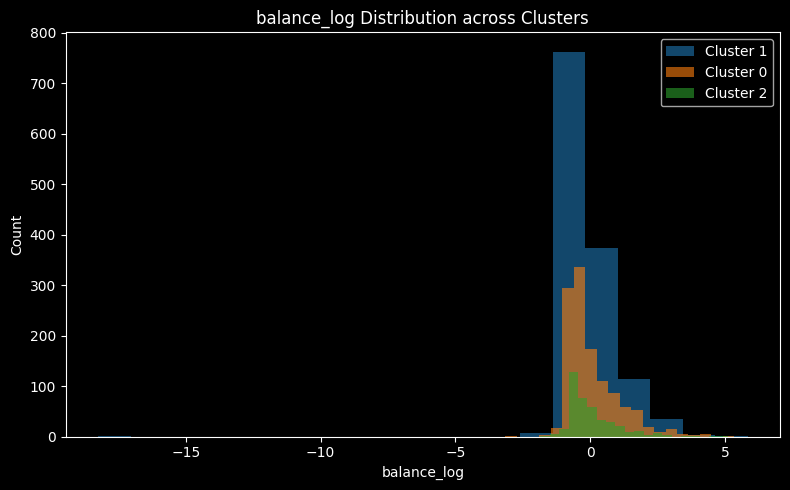

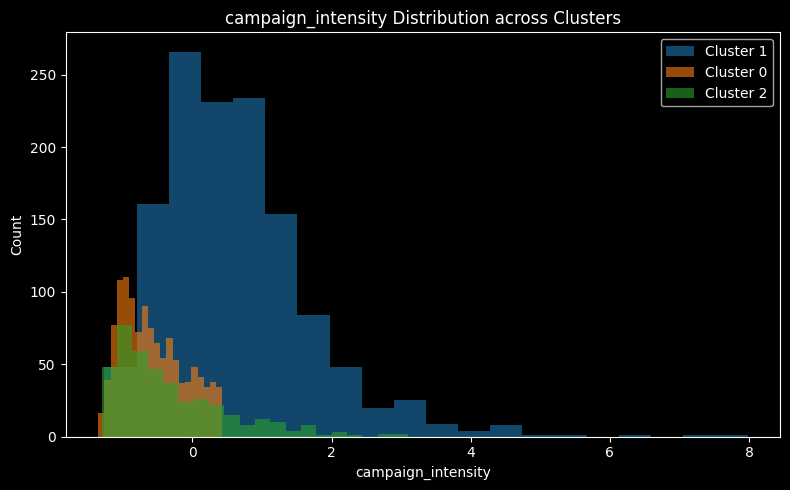

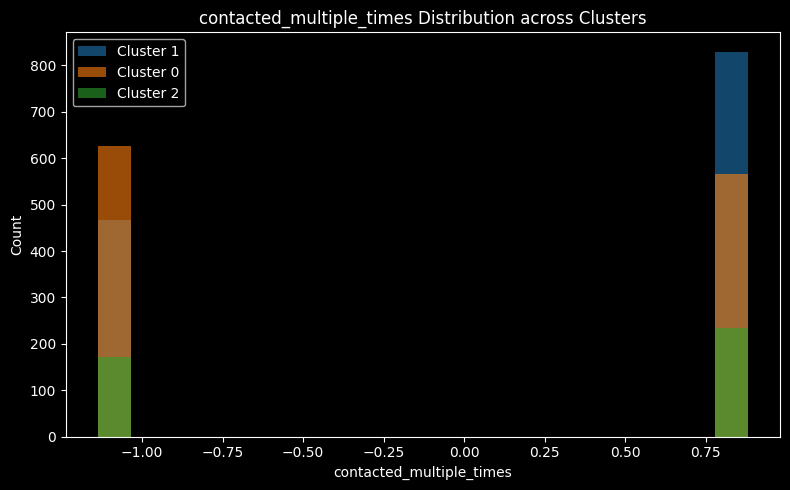

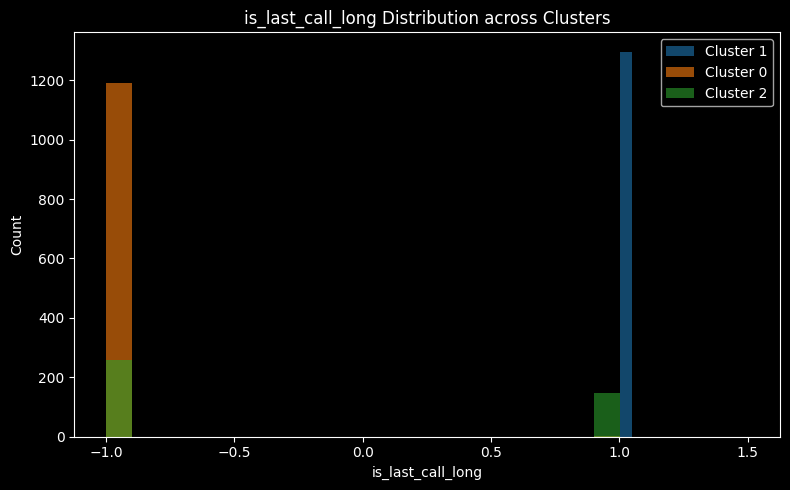

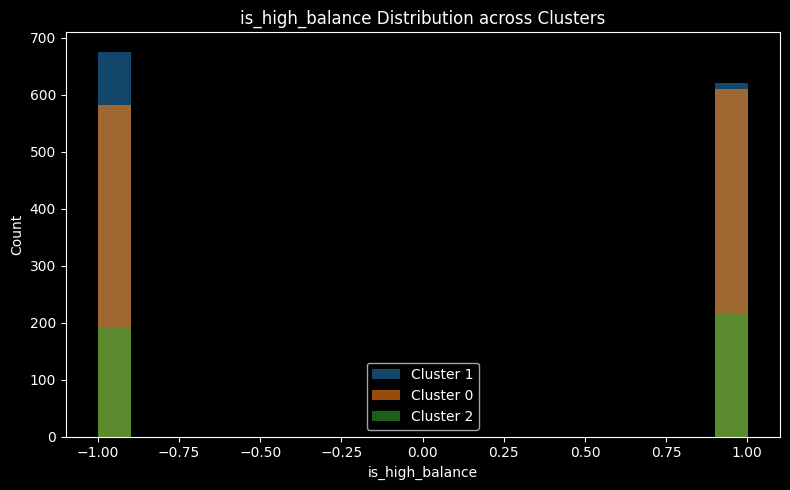

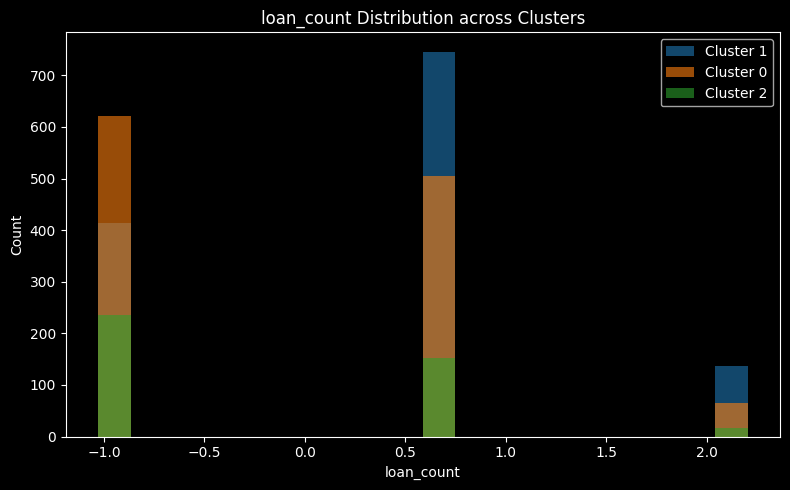

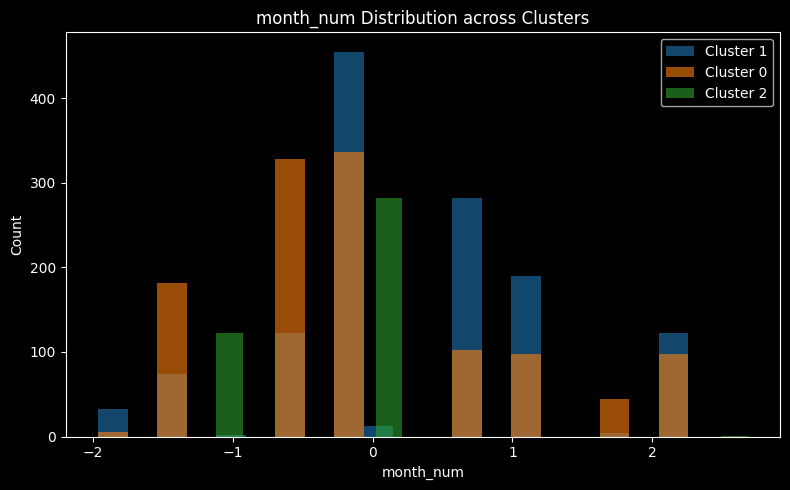

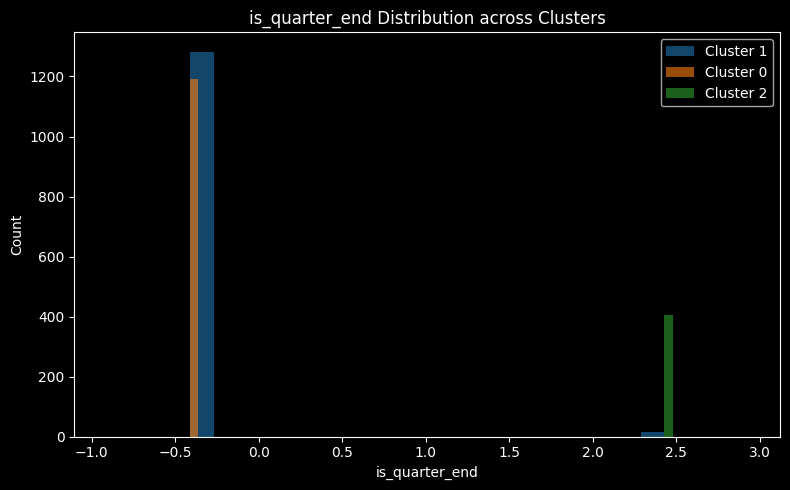

In [367]:
# decode categorical features for better interpretability (matplotlib version with improved color scheme)
import matplotlib.cm as cm
colors = cm.get_cmap('tab10')
for idx, feature in enumerate(numerical_features_subscribed):
    plt.figure(figsize=(8, 5))
    clusters = subscribed_customers_features_processed['cluster'].unique()
    for i, cluster in enumerate(clusters):
        subset = subscribed_customers_features_processed[subscribed_customers_features_processed['cluster'] == cluster]
        plt.hist(subset[feature], bins=20, alpha=0.6, label=f'Cluster {cluster}', color=colors(i % 10))
    plt.title(f'{feature} Distribution across Clusters')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../../reports/figures/cluster_distribution_{feature}.png')
    plt.show()

### Translating machine-speak back to human 🗣️

Encoded categories are great for algorithms, but terrible for humans! Let's decode them for interpretability...

### Decode categorical features for better interpretability

In [368]:
### decode categorical features for better interpretability
decoded_categorical_features = encoder.inverse_transform(subscribed_customers_features_processed[categorical_feature_names])
decoded_categorical_features_df = pd.DataFrame(decoded_categorical_features, columns=categorical_features_subscribed)
subscribed_customers_features_final = pd.concat([subscribed_customers_features_processed[numerical_features_subscribed].reset_index(drop=True), decoded_categorical_features_df.reset_index(drop=True), subscribed_customers_features_processed['cluster'].reset_index(drop=True)], axis=1)
subscribed_customers_features_final.head()


,age,balance,day,duration,campaign,balance_log,campaign_intensity,contacted_multiple_times,is_last_call_long,is_high_balance,...,education,default,housing,loan,contact,month,week,quarter,age_group,cluster
0,1.741354,0.258004,-1.265409,0.832632,-0.613443,0.602802,1.619795,-1.136283,1.001382,1.000691,...,secondary,no,yes,no,unknown,may,1,2,50-59,1
1,1.468629,-0.527801,-1.265409,1.818224,-0.613443,-0.719025,2.842102,-1.136283,1.001382,-0.999310,...,secondary,no,no,no,unknown,may,1,2,50-59,1
2,0.105003,-0.108910,-1.265409,1.637339,-0.613443,0.074524,2.617773,-1.136283,1.001382,1.000691,...,secondary,no,yes,no,unknown,may,1,2,40-49,1
3,1.377720,0.303484,-1.265409,-0.241084,-0.613443,0.660830,0.288199,-1.136283,-0.998620,1.000691,...,secondary,no,yes,no,unknown,may,1,2,50-59,0
4,1.286812,-0.480270,-1.265409,-0.023094,-0.179720,-0.614524,-0.086642,0.880062,1.001382,-0.999310,...,tertiary,no,no,no,unknown,may,1,2,50-59,1


### Reversing the scaling spell 🔄

Scaled numbers are meaningless to business stakeholders. Let's transform them back to original scales for clarity...

### Addressing numerical features back to original scale for better interpretability

In [369]:
### addressing numerical features back to original scale for better interpretability
numerical_features_original_scale = scaler.inverse_transform(subscribed_customers_features_processed[numerical_features_subscribed])
numerical_features_original_scale_df = pd.DataFrame(numerical_features_original_scale, columns=numerical_features_subscribed)
subscribed_customers_features_final_original_scale = pd.concat([numerical_features_original_scale_df.reset_index(drop=True), decoded_categorical_features_df.reset_index(drop=True), subscribed_customers_features_processed['cluster'].reset_index(drop=True)], axis=1)
subscribed_customers_features_final_original_scale.head()

,age,balance,day,duration,campaign,balance_log,campaign_intensity,contacted_multiple_times,is_last_call_long,is_high_balance,...,education,default,housing,loan,contact,month,week,quarter,age_group,cluster
0,59.0,2343.0,5.0,1042.0,1.0,8.594710,521.000000,0.0,1.0,1.0,...,secondary,no,yes,no,unknown,may,1,2,50-59,1
1,56.0,45.0,5.0,1467.0,1.0,8.040769,733.500000,0.0,1.0,0.0,...,secondary,no,no,no,unknown,may,1,2,50-59,1
2,41.0,1270.0,5.0,1389.0,1.0,8.373323,694.500000,0.0,1.0,1.0,...,secondary,no,yes,no,unknown,may,1,2,40-49,1
3,55.0,2476.0,5.0,579.0,1.0,8.619027,289.500000,0.0,0.0,1.0,...,secondary,no,yes,no,unknown,may,1,2,50-59,0
4,54.0,184.0,5.0,673.0,2.0,8.084562,224.333333,1.0,1.0,0.0,...,tertiary,no,no,no,unknown,may,1,2,50-59,1


### Final visualization: The true picture emerges 🖼️

With data back in human-readable form, let's create our final visual profiles of each cluster...

### Understanding feature distributions across clusters

C:\Users\My-PC\AppData\Local\Temp\ipykernel_9548\3156736947.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



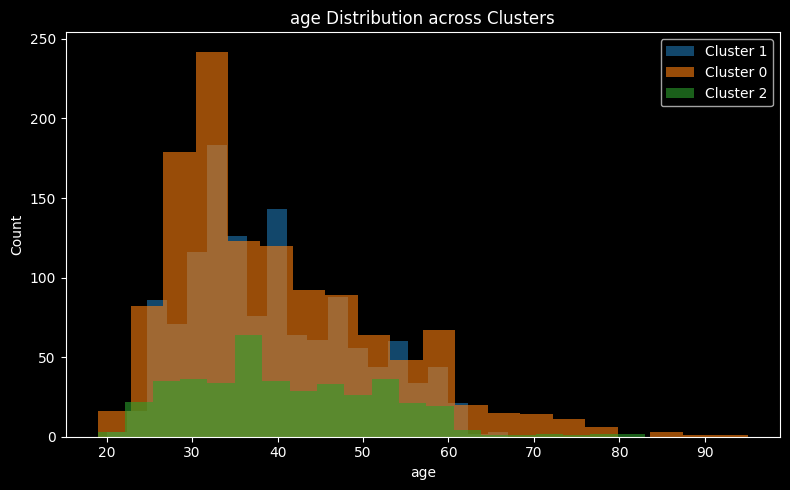

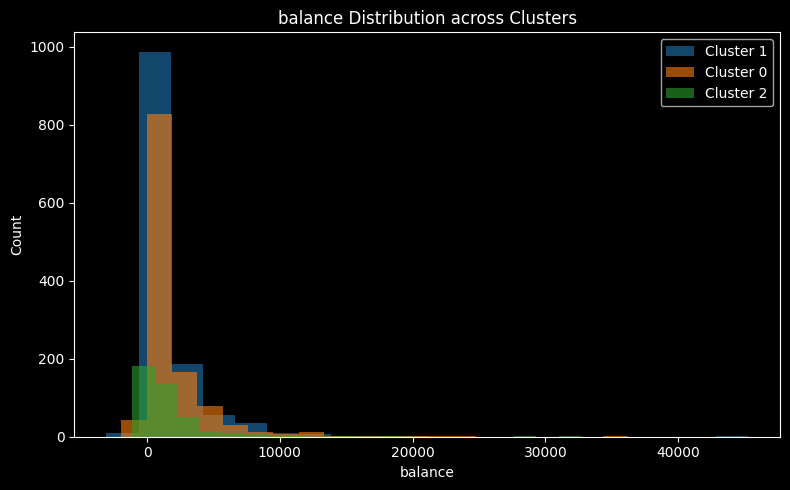

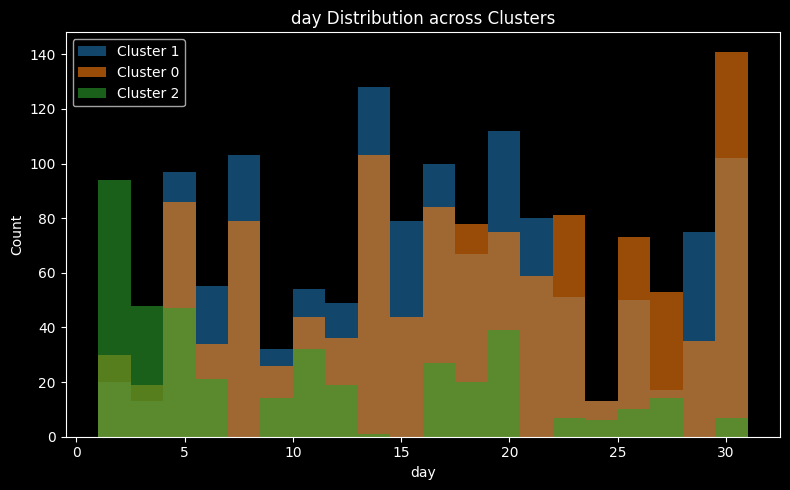

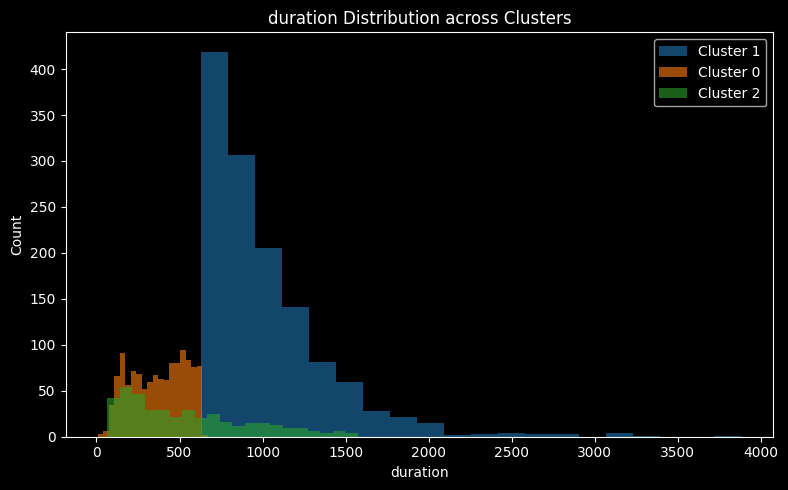

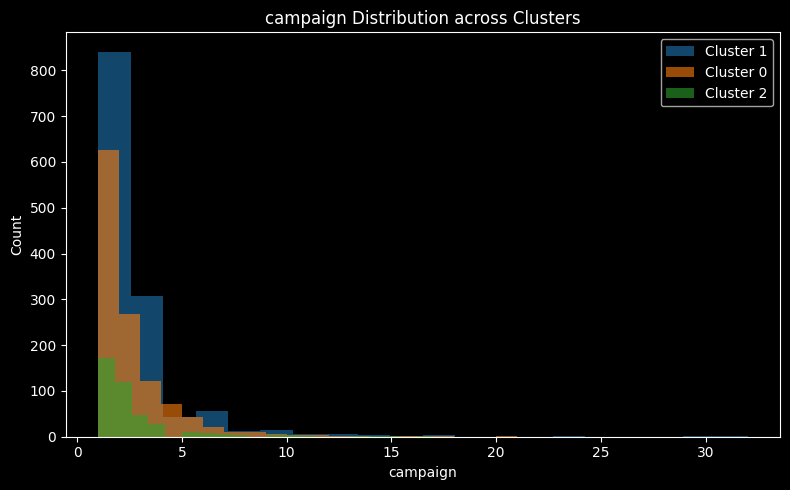

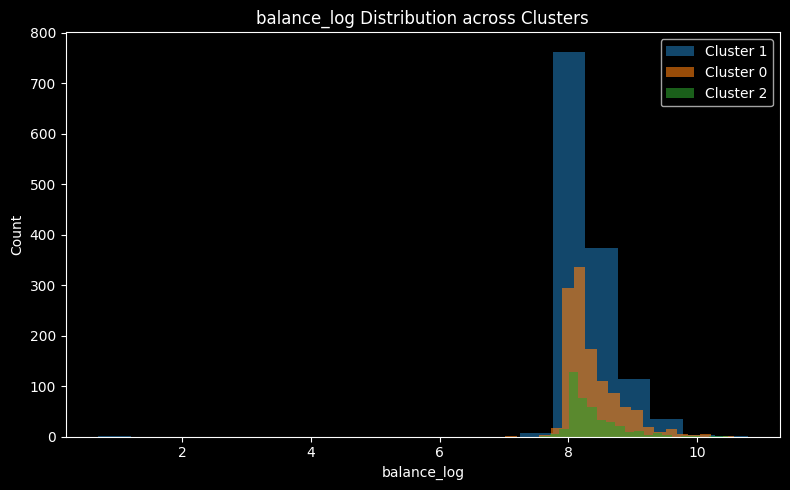

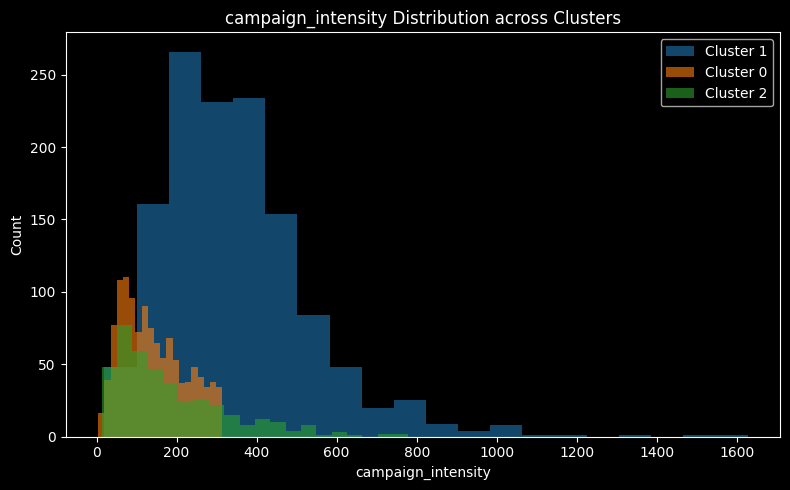

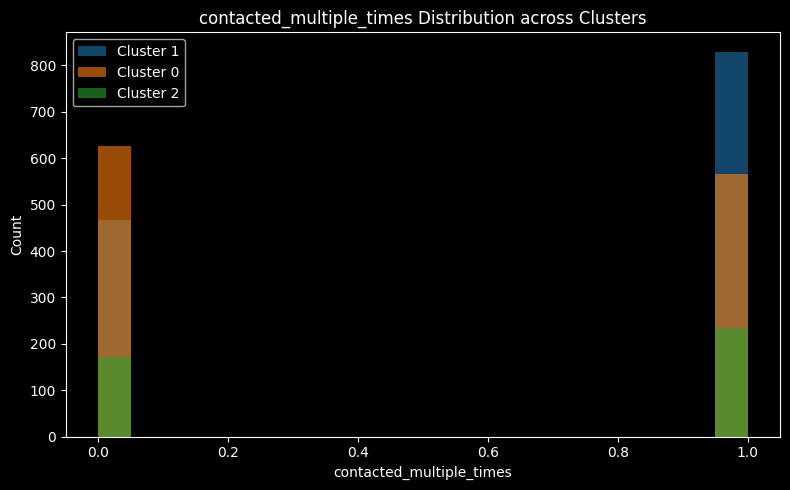

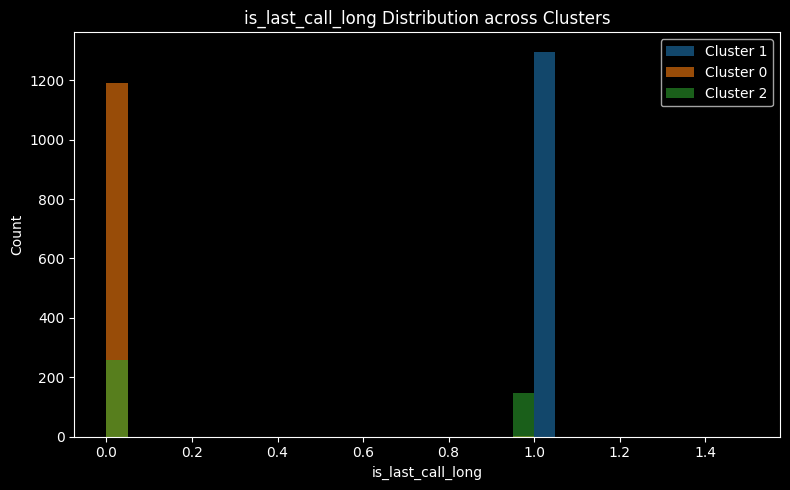

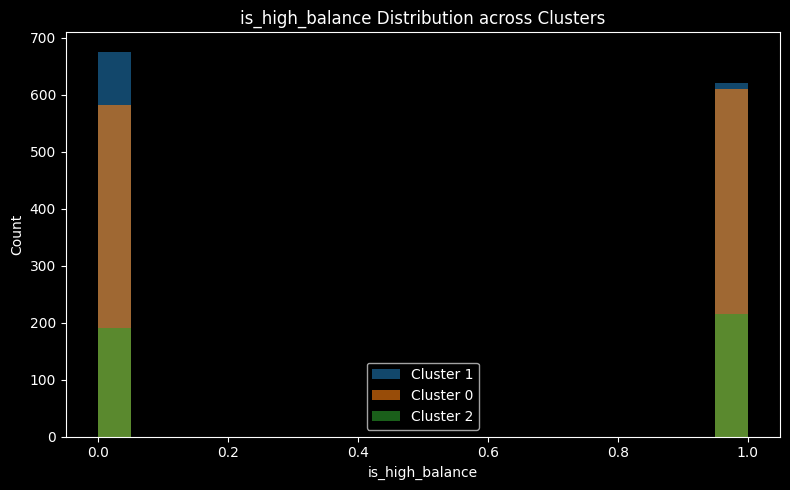

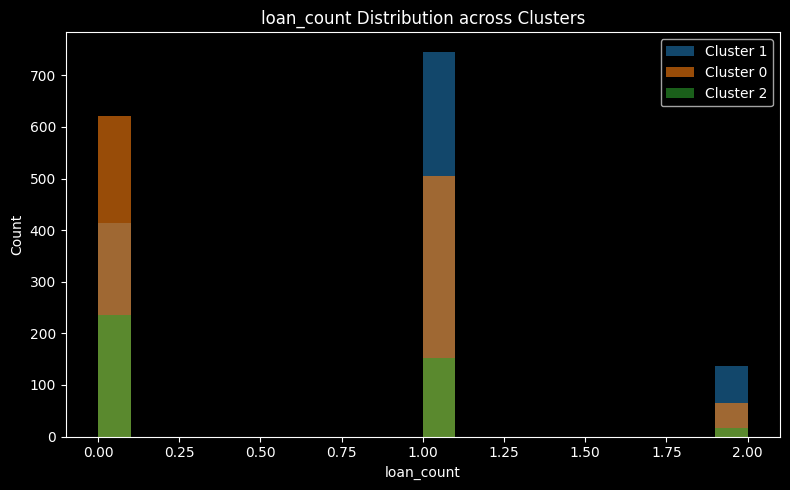

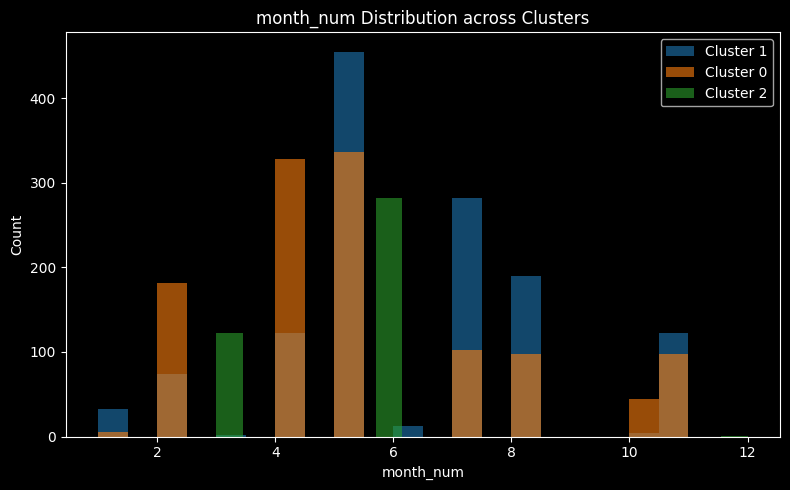

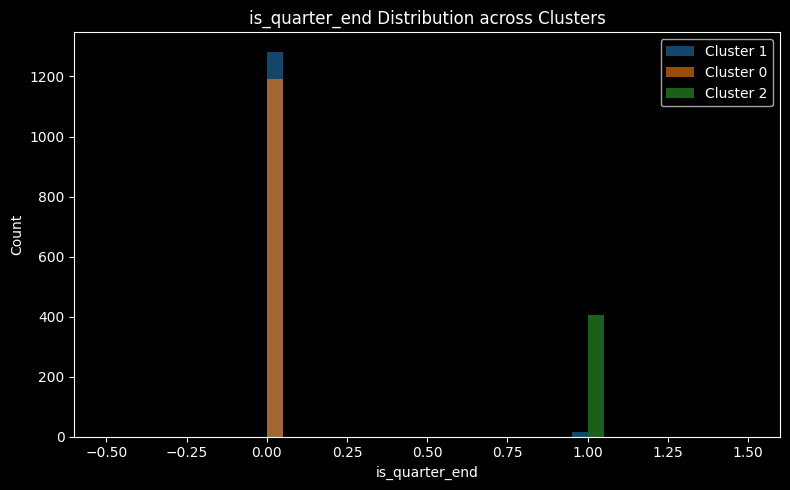

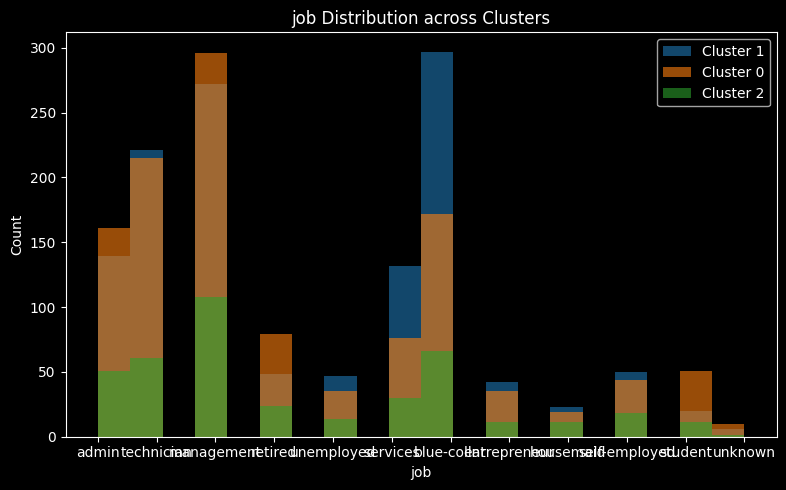

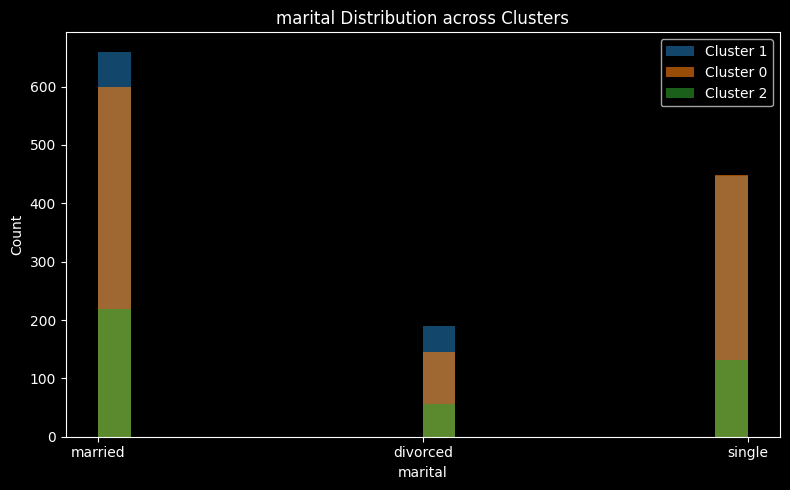

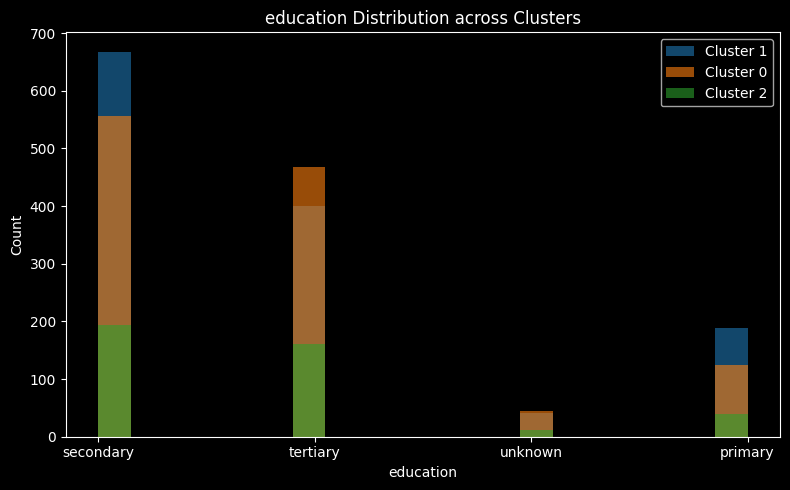

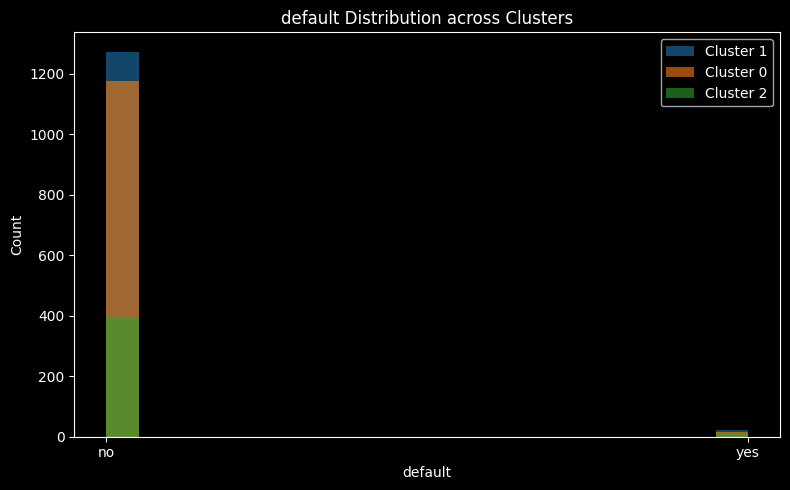

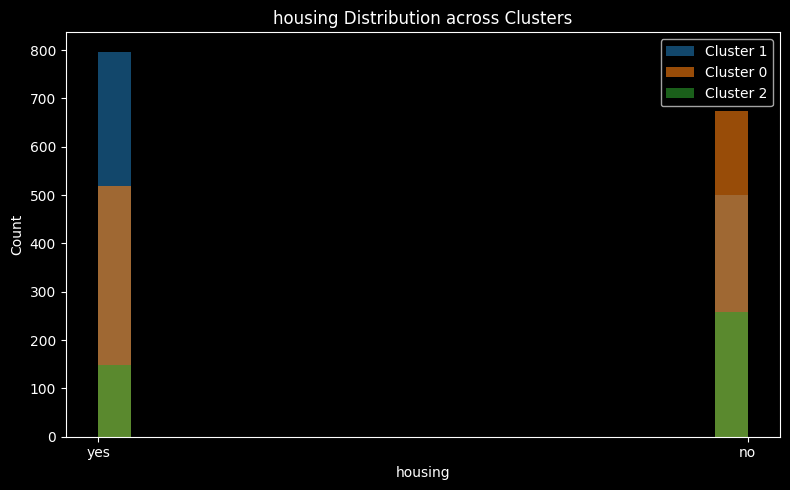

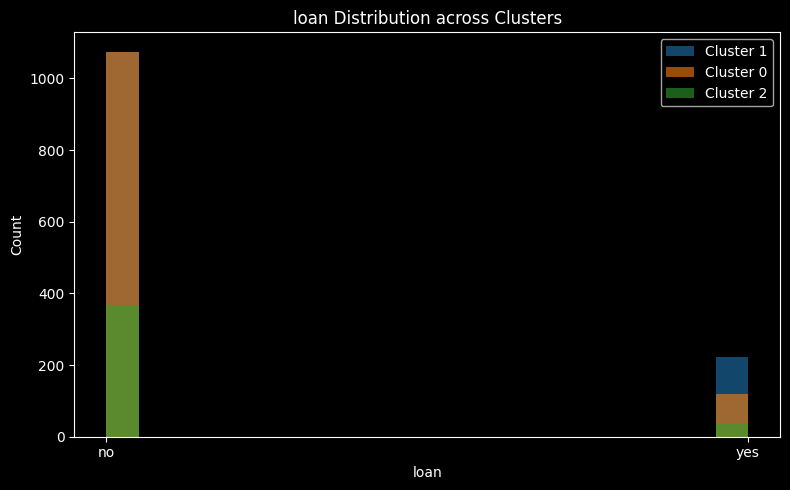

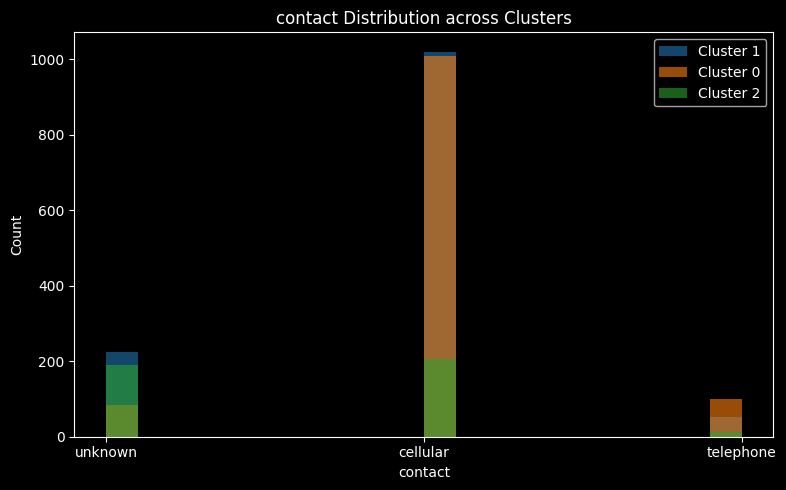

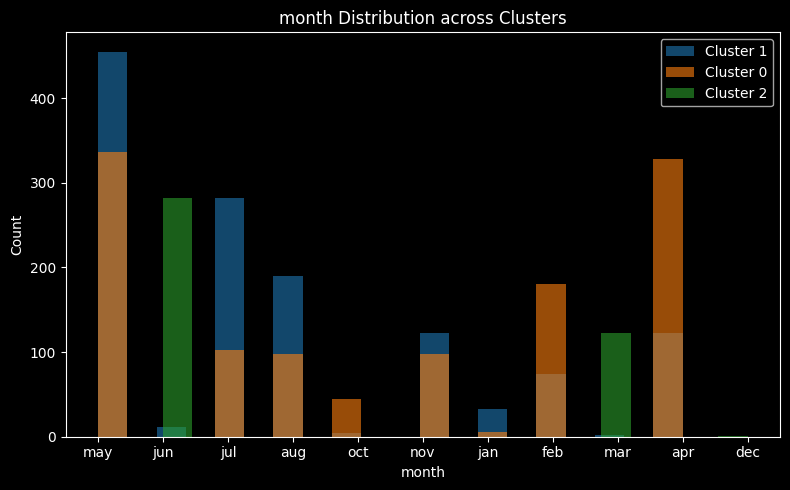

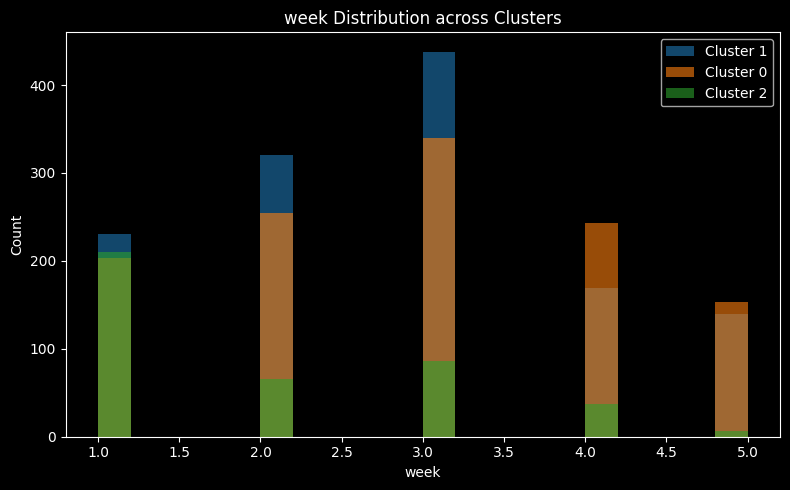

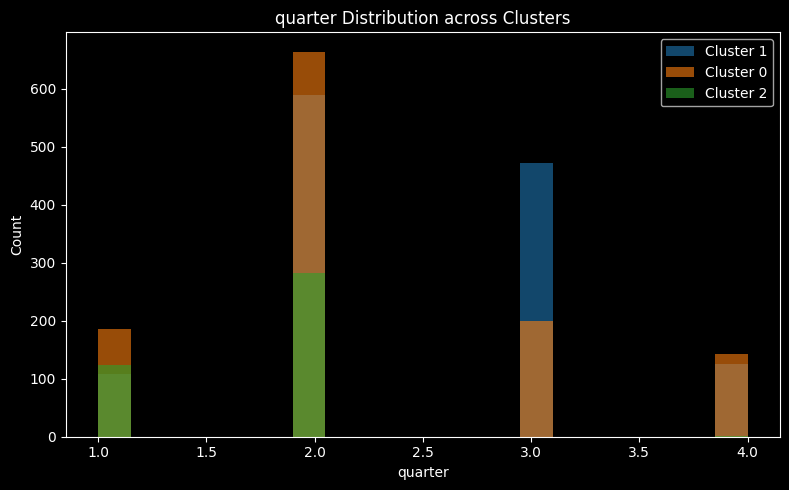

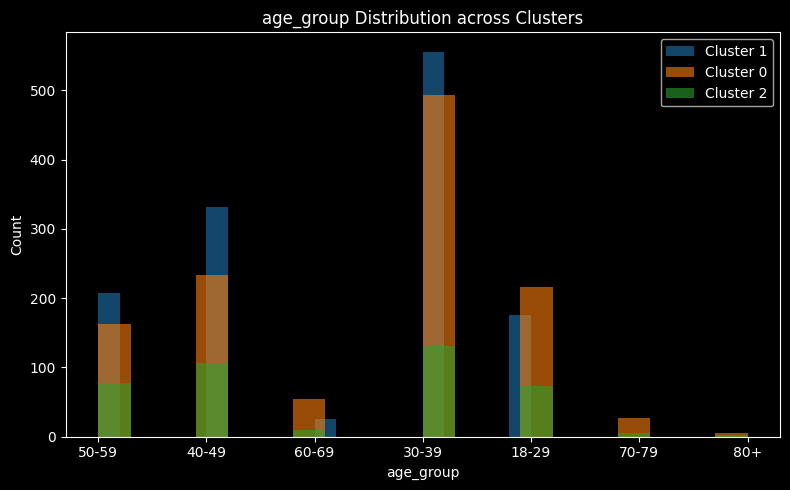

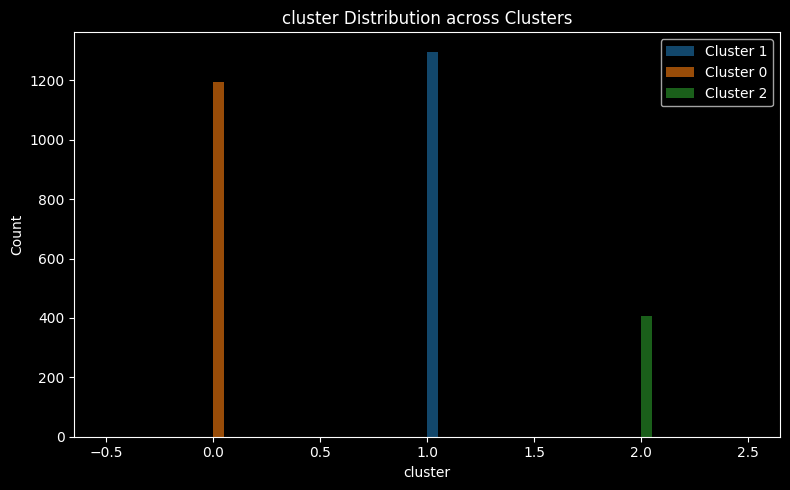

In [370]:
## plotting with decoded features
import matplotlib.cm as cm
colors = cm.get_cmap('tab10')
for idx, feature in enumerate(subscribed_customers_features_final_original_scale):
    plt.figure(figsize=(8, 5))
    clusters = subscribed_customers_features_final_original_scale['cluster'].unique()
    for i, cluster in enumerate(clusters):
        subset = subscribed_customers_features_final_original_scale[subscribed_customers_features_final_original_scale['cluster'] == cluster]
        plt.hist(subset[feature], bins=20, alpha=0.6, label=f'Cluster {cluster}', color=colors(i % 10))
    plt.title(f'{feature} Distribution across Clusters')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../../reports/figures/cluster_distribution_{feature}_scaled.png')
    plt.show()

## 🧩 Key Findings from Clustering (k = 3)

Our analysis reveals **three distinct and meaningful customer segments** among term deposit subscribers. Each tribe has unique characteristics that demand tailored engagement strategies.

---

### 🎯 **Cluster 0: The Established Professionals** (The Affluent Achievers)

**Demographics & Status:**
- **Age Profile:** Predominantly middle-aged (35-50 years)
- **Profession:** Strong presence of management and technician roles
- **Financial Standing:** Highest account balances, minimal loan burden
- **Campaign Response:** Moderate engagement levels

**Key Characteristics:**
- These are financially secure, career-established individuals
- High account balances indicate strong savings discipline
- Low loan counts suggest financial stability and independence
- Represent the "sweet spot" for term deposit products

**Strategic Implications:**
- Focus on **wealth preservation and growth** messaging
- Emphasize **higher interest rates** and **premium service tiers**
- Target with exclusive offers and personalized relationship management
- Best candidates for upselling investment products

---

### 💼 **Cluster 1: The Cautious Accumulators** (The Prudent Savers)

**Demographics & Status:**
- **Age Profile:** Younger to middle-aged (25-45 years)
- **Profession:** Mixed roles, diverse economic backgrounds
- **Financial Standing:** Moderate balances, some loan activity
- **Campaign Response:** Balanced engagement

**Key Characteristics:**
- Building financial foundations, not yet at peak earning
- More sensitive to financial obligations (loans, housing costs)
- Responsive to campaigns but need clear value propositions
- Represent growth potential as they advance in careers

**Strategic Implications:**
- Emphasize **safety and reliability** of term deposits
- Offer **flexible terms** and **lower minimum deposits**
- Educational content about long-term wealth building
- Position term deposits as stepping stones to financial security

---

### 🌱 **Cluster 2: The Emerging Subscribers** (The New Entrants)

**Demographics & Status:**
- **Age Profile:** Younger demographic (under 35)
- **Profession:** Early career stages, students, entry-level positions
- **Financial Standing:** Lower balances, building credit history
- **Campaign Response:** High engagement (responsive to outreach)

**Key Characteristics:**
- Early in their financial journey
- More likely to be first-time term deposit subscribers
- High campaign engagement suggests openness to new products
- Represent future growth as earnings increase

**Strategic Implications:**
- Focus on **financial education** and **accessibility**
- Offer **starter products** with low barriers to entry
- Digital-first engagement (mobile apps, online platforms)
- Build **long-term loyalty** through positive early experiences
- Cross-sell opportunities as they mature financially

---

### 📊 **Cross-Cluster Insights:**

1. **Age correlates strongly with financial capacity** - targeting should consider life stage
2. **Job type is a strong predictor** of cluster membership (management → Cluster 0, students → Cluster 2)
3. **Balance levels** differentiate clusters most clearly
4. **Campaign intensity** varies - some segments need nurturing, others are self-motivated

---

### 🎯 **Recommended Next Steps:**

1. **Segment-Specific Campaigns:** Create tailored messaging for each cluster
2. **Product Differentiation:** Design term deposit variants matching each segment's needs
3. **Resource Allocation:** Prioritize Cluster 0 (high-value) while nurturing Cluster 2 (future potential)
4. **Retention Strategies:** Different engagement approaches for each tribe

---

# 📖 **The End... and The Beginning** 🚀

---

## 🎬 **Epilogue: The Three Paths to Term Deposit Success**

Our journey through the Bank Marketing dataset has revealed a story written in numbers - one of prediction, segmentation, and strategic insight.

---

### 🏆 **Chapter Recap: What We Discovered**

#### **Part I: The Classification Quest**
We trained four powerful algorithms to predict term deposit subscriptions:
- **Logistic Regression** - the linear baseline
- **Decision Tree** - the interpretable branching logic
- **Random Forest** - the ensemble wisdom
- **XGBoost** - the gradient boosting champion

Each model brought unique strengths, with **ensemble methods** proving most effective at capturing the complex patterns of customer behavior.

#### **Part II: The Clustering Revelation**
Among subscribers, we uncovered **three distinct tribes** (k=3):
1. **The Established Professionals** - affluent achievers seeking wealth preservation
2. **The Cautious Accumulators** - prudent savers building financial foundations
3. **The Emerging Subscribers** - young entrants beginning their journey

These segments aren't just statistical artifacts - they're **actionable customer archetypes** demanding tailored strategies.

---

### 💡 **Strategic Playbook: The Three-Segment Approach**

#### 🎯 **For Cluster 0: The Established Professionals**
**"Exclusivity & Premium Value"**
- **Messaging:** "Maximize your wealth with premier rates"
- **Channels:** Personalized relationship managers, exclusive events
- **Products:** High-balance tiers with premium interest rates
- **Retention:** VIP treatment, priority service, investment consultations
- **Why it works:** They have the capital and seek the best returns

#### 💼 **For Cluster 1: The Cautious Accumulators**
**"Security & Growth"**
- **Messaging:** "Safe, steady growth for your financial future"
- **Channels:** Email campaigns, educational webinars, mobile notifications
- **Products:** Flexible terms (6, 12, 24 months), moderate minimums
- **Retention:** Financial planning resources, milestone rewards
- **Why it works:** They value stability but need flexible options

#### 🌱 **For Cluster 2: The Emerging Subscribers**
**"Accessibility & Education"**
- **Messaging:** "Start building your savings habit today"
- **Channels:** Social media, mobile apps, digital-first platforms
- **Products:** Low-entry minimums, short-term commitments, easy withdrawals
- **Retention:** Gamification, financial literacy content, tiered achievements
- **Why it works:** Capture them early, grow with them over time

---

### 🔍 **Key Lessons Learned**

1. **One Size Doesn't Fit All:** The 3-cluster structure proves customers need differentiated approaches
2. **Balance is King:** Account balance emerged as the strongest differentiator across segments
3. **Age = Life Stage:** Younger subscribers behave fundamentally differently from established professionals
4. **Campaign Optimization:** High engagement in Cluster 2 suggests untapped potential in younger demographics
5. **Lifetime Value Thinking:** Today's Cluster 2 becomes tomorrow's Cluster 0 - invest in the journey

---

### 📈 **Business Impact: Turning Insights into Action**

#### **Immediate Wins (0-3 months):**
- Launch segment-specific email campaigns using cluster profiles
- Adjust product offerings: create "Starter," "Builder," and "Premium" tiers
- Retrain marketing team on the three archetypes

#### **Medium-term Strategy (3-12 months):**
- Develop predictive models for cluster transition (e.g., Cluster 2 → Cluster 1)
- Implement dynamic pricing based on segment and predicted lifetime value
- Create automated journeys that evolve as customers move between clusters

#### **Long-term Vision (12+ months):**
- Build a **customer lifecycle platform** tracking movement through segments
- Develop **predictive retention models** for each cluster
- Integrate clustering insights into CRM systems for real-time personalization

---

### 🧠 **Technical Reflections**

**What Worked:**
- K-Means provided clean, interpretable segments
- Elbow Method + Silhouette Analysis converged on k=3 beautifully
- Feature engineering (balance bins, loan counts, campaign intensity) enhanced clustering quality

**Challenges Overcome:**
- Scaling features ensured numerical dominance didn't bias clusters
- Encoding categorical variables preserved important job/education patterns
- Dimensionality reduction (PCA) helped with visualization


---

### 🎓 **Final Wisdom**

> *"In data, we found not just numbers, but narratives. Not just clusters, but communities. Not just predictions, but possibilities."*

The Bank Marketing dataset taught us that behind every subscription decision lies a human story - one of financial aspirations, life circumstances, and carefully weighed choices.

By combining **predictive power** (classification) with **descriptive insight** (clustering), we've built a framework that doesn't just ask "Will they subscribe?" but also "**Who are they, and what do they need?**"

---

### 🚀 **Your Turn**

This analysis is a **starting point, not an endpoint**. The three-segment framework provides the foundation - now it's time to:
- **Test** these strategies in A/B campaigns
- **Validate** cluster characteristics with actual customer feedback
- **Iterate** as new data reveals evolving patterns

---

## 🌟 **The Journey Continues...**

Every dataset tells a story. This one told us about three tribes of term deposit subscribers, each walking a different financial path.

**The question now:** How will you use these insights to transform marketing strategy?

---

*"May your models be accurate, your clusters meaningful, and your business impact undeniable."* ✨

---

**THE END** 📚